# **IE Sustainability Datathon 2023:** 05b_ML Models (15mins - XGBoost - All sectors)



## 0. GENERAL CONFIG

### Modules & Libraries

In [12]:
#conda update scikit-learn

In [13]:
!pip install category_encoders

In [14]:
!pip install optuna

In [15]:
!pip install shap

In [16]:
# IMPORT MODULES

# Base -----------------------------------------------------------
import pandas as pd
import numpy as np
import pathlib
import datetime as dt
from scipy.stats import norm
from datetime import datetime
#import pandas_profiling
from math import *

pd.options.display.float_format = "{:,.4f}".format

# Viz ------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm
import seaborn as sns
import plotly
import plotnine
from plotnine import *
#import patchworklib as pw
from mizani.formatters import date_format
from dateutil import tz
import shap

%matplotlib inline

In [17]:
import time
from datetime import timedelta

In [18]:
import sklearn
import matplotlib
import scipy
import statsmodels
import mlxtend
import category_encoders
import seaborn
import xgboost

In [19]:
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OrdinalEncoder
from category_encoders import OrdinalEncoder

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [21]:
import optuna

In [22]:
#importing all the plot functions
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

### Prepared Functions

In [23]:
def miss_info(df_data):

    # MISSING VALUES INFO (BY COLUMNS)

    df_colsnan = pd.DataFrame()
    df_colsnan['dtypes'] = df_data.apply(lambda x: x.dtypes)
    df_colsnan['nan'] = df_data.isnull().sum()
    df_colsnan['perc_nan'] = (df_data.isnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_nan'] = df_colsnan['perc_nan'].round(2)
    df_colsnan['not_nan'] = df_data.notnull().sum()
    df_colsnan['perc_not_nan'] = (df_data.notnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_not_nan'] = df_colsnan['perc_not_nan'].round(2)
    df_colsnan['unique_values'] = df_data.apply(lambda x: len(x.unique()) )
    df_colsnan['neg_values'] = df_data.apply(lambda x: x.lt(0).sum() if x.dtypes == 'float64' else 'NA')
    df_colsnan.reset_index(inplace=True)
    df_colsnan.rename(columns={'index':'col_name'}, inplace=True)

    return df_colsnan

In [24]:
def RowKey_transf(x):
    myDate = str(x.date())
    return dt.datetime.strptime(myDate, '%Y-%m-%d').strftime('%Y-%m-%dT00:00:00.000Z')

In [25]:
def mape_corr(y_true, y_pred):

  mape_value = mean_absolute_percentage_error(y_true, y_pred)
  if mape_value > 1500 and (y_true-y_pred).mean()<1:
    mape_value = 0

  return mape_value

In [26]:
def mape_corr_multi(y_true, y_pred):

  mape_value = mean_absolute_percentage_error(y_true, y_pred)

  if mape_value > 1500: #and (y_true-y_pred).mean()<1:
    mape_value = 0

  return mape_value

In [27]:
def df_cols2rows(df_data, datetime_col):

  sel_cols = [x for x in list(df_data.columns) if x!=datetime_col]

  for x in sel_cols:

    ind_x = sel_cols.index(x)
    #col_name = 'V_' + x.replace(' ','-')

    if ind_x==0:
      df_viz = df_data[[datetime_col,x]].copy()
      df_viz.rename({x:'INF_Value'}, axis=1, inplace=True)
      df_viz['STA_Name'] = x
    else:
      df_aux = df_data[[datetime_col,x]].copy()
      df_aux.rename({x:'INF_Value'}, axis=1, inplace=True)
      df_aux.reset_index(drop=True, inplace=True)
      df_aux['STA_Name'] = x

      df_viz = pd.concat([df_viz,df_aux], axis=0)
      df_viz.reset_index(drop=True, inplace=True)

  return df_viz


### General info & Code

In [28]:
'''
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)

num_vars = list(df_model.select_dtypes(include=["number"]).columns)


# DATE COLUMN
df_model['settlementDate'] = pd.to_datetime(df_model['settlementDate'])


# Transforming date to CATEGORICAL ORDINAL
order = list(df_model['settlementDate'].unique())
order.sort()
data = df_model['settlementDate']
df_model['settlementDate'] = pd.Categorical(data, order, ordered=True)


# CATEGORICAL NOMINAL
# Column "recordtype"
data = df_model['recordtype']
df_model['recordtype'] = pd.Categorical(data, ordered=False)


'''

'\ncat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)\n\nnum_vars = list(df_model.select_dtypes(include=["number"]).columns)\n\n\n# DATE COLUMN\ndf_model[\'settlementDate\'] = pd.to_datetime(df_model[\'settlementDate\'])\n\n\n# Transforming date to CATEGORICAL ORDINAL\norder = list(df_model[\'settlementDate\'].unique())\norder.sort()\ndata = df_model[\'settlementDate\']\ndf_model[\'settlementDate\'] = pd.Categorical(data, order, ordered=True)\n\n\n# CATEGORICAL NOMINAL\n# Column "recordtype"\ndata = df_model[\'recordtype\']\ndf_model[\'recordtype\'] = pd.Categorical(data, ordered=False)\n\n\n'

## 1. LOADING & PREPARING DATASET

### Loading dataset

In [29]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


In [30]:
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"

In [31]:
df_1mins76 = pd.read_csv(file_path)
df_1mins76

RowKey RowKey_Date RowKey_Time DiaSem Clasif_Lab  \
0      2021-08-02 00:15:00+00:00  2021-08-02    00:15:00  Lunes  Laborable   
1      2021-08-02 00:30:00+00:00  2021-08-02    00:30:00  Lunes  Laborable   
2      2021-08-02 00:45:00+00:00  2021-08-02    00:45:00  Lunes  Laborable   
3      2021-08-02 01:00:00+00:00  2021-08-02    01:00:00  Lunes  Laborable   
4      2021-08-02 01:15:00+00:00  2021-08-02    01:15:00  Lunes  Laborable   
...                          ...         ...         ...    ...        ...   
47735  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00  Lunes  Laborable   
47736  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00  Lunes  Laborable   
47737  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00  Lunes  Laborable   
47738  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00  Lunes  Laborable   
47739  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00  Lunes  Laborable   

      Clasif_Fest  N_DiaMes  N_Mes  N_Ano  Lab_PrevioFest  ...  precip  \
0      No Festivo         2      8   2021               0  ...  0.0000   
1      No Festivo         2      8   2021               0  ...  0.0000   
2      No Festivo         2      8   2021               0  ...  0.0000   
3      No Festivo         2      8   2021               0  ...  0.0000   
4      No Festivo         2      8   2021               0  ...  0.0000   
...           ...       ...    ...    ...             ...  ...     ...   
47735  No Festivo        12     12   2022               0  ...  3.4000   
47736  No Festivo        12     12   2022               0  ...  3.4000   
47737  No Festivo        12     12   2022               0  ...  3.4000   
47738  No Festivo        12     12   2022               0  ...  3.4000   
47739  No Festivo        12     12   2022               0  ...  3.4000   

       solarradiation  sealevelpressure     dew  humidity  precipcover  \
0            452.7000        1,014.1000  3.8000   27.8700       0.0000   
1            452.7000        1,014.1000  3.8000   27.8700       0.0000   
2            452.7000        1,014.1000  3.8000   27.8700       0.0000   
3            452.7000        1,014.1000  3.8000   27.8700       0.0000   
4            452.7000        1,014.1000  3.8000   27.8700       0.0000   
...               ...               ...     ...       ...          ...   
47735         87.4000        1,009.8000 12.1000   86.1200      12.5000   
47736         87.4000        1,009.8000 12.1000   86.1200      12.5000   
47737         87.4000        1,009.8000 12.1000   86.1200      12.5000   
47738         87.4000        1,009.8000 12.1000   86.1200      12.5000   
47739         87.4000        1,009.8000 12.1000   86.1200      12.5000   

       cond_Partially-cloudy  cond_Clear  cond_Rain  cond_Overcast  
0                          1           0          0              0  
1                          1           0          0              0  
2                          1           0          0              0  
3                          1           0          0              0  
4                          1           0          0              0  
...                      ...         ...        ...            ...  
47735                      0           0          1              1  
47736                      0           0          1              1  
47737                      0           0          1              1  
47738                      0           0          1              1  
47739                      0           0          1              1  

[47740 rows x 42 columns]

In [32]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47740 entries, 0 to 47739
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey                 47740 non-null  object 
 1   RowKey_Date            47740 non-null  object 
 2   RowKey_Time            47740 non-null  object 
 3   DiaSem                 47740 non-null  object 
 4   Clasif_Lab             47740 non-null  object 
 5   Clasif_Fest            47740 non-null  object 
 6   N_DiaMes               47740 non-null  int64  
 7   N_Mes                  47740 non-null  int64  
 8   N_Ano                  47740 non-null  int64  
 9   Lab_PrevioFest         47740 non-null  int64  
 10  Lab_PostFest           47740 non-null  int64  
 11  DiaSem_SIN             47740 non-null  float64
 12  DiaSem_COS             47740 non-null  float64
 13  Dia_SIN                47740 non-null  float64
 14  Dia_COS                47740 non-null  float64
 15  Me

In [33]:
df_1mins76.describe()

N_DiaMes       N_Mes       N_Ano  Lab_PrevioFest  Lab_PostFest  \
count 47,740.0000 47,740.0000 47,740.0000     47,740.0000   47,740.0000   
mean      15.5412      7.3749  2,021.6943          0.0201        0.0282   
std        8.8132      3.3385      0.4607          0.1404        0.1654   
min        1.0000      1.0000  2,021.0000          0.0000        0.0000   
25%        8.0000      5.0000  2,021.0000          0.0000        0.0000   
50%       15.0000      8.0000  2,022.0000          0.0000        0.0000   
75%       23.0000     10.0000  2,022.0000          0.0000        0.0000   
max       31.0000     12.0000  2,022.0000          1.0000        1.0000   

       DiaSem_SIN  DiaSem_COS     Dia_SIN     Dia_COS     Mes_SIN  ...  \
count 47,740.0000 47,740.0000 47,740.0000 47,740.0000 47,740.0000  ...   
mean      -0.0000      0.0006      0.0156      0.0071     -0.2109  ...   
std        0.7069      0.7073      0.7089      0.7051      0.7043  ...   
min       -0.9749     -0.9010     -1.0000     -1.0000     -1.0000  ...   
25%       -0.7818     -0.9010     -0.7248     -0.6691     -0.8660  ...   
50%        0.0000     -0.2225      0.0000     -0.0506     -0.5000  ...   
75%        0.7818      0.6235      0.7248      0.6890      0.5000  ...   
max        0.9749      1.0000      1.0000      1.0000      1.0000  ...   

           precip  solarradiation  sealevelpressure         dew    humidity  \
count 47,740.0000     47,740.0000       47,740.0000 47,740.0000 47,740.0000   
mean       0.6435        327.9043        1,018.1784      6.5815     57.9125   
std        3.0995        122.9250            5.4777      4.0867     21.1477   
min        0.0000         55.1000        1,001.8000     -6.4000     10.4900   
25%        0.0000        243.4000        1,014.3000      3.9000     39.5300   
50%        0.0000        341.2000        1,017.7000      6.9000     60.0000   
75%        0.0000        436.6000        1,021.5000      9.2000     76.1700   
max       37.2000        557.6000        1,033.1000     16.7000     97.7800   

       precipcover  cond_Partially-cloudy  cond_Clear   cond_Rain  \
count  47,740.0000            47,740.0000 47,740.0000 47,740.0000   
mean        2.1763                 0.6214      0.3137      0.1594   
std         7.3627                 0.4851      0.4640      0.3661   
min         0.0000                 0.0000      0.0000      0.0000   
25%         0.0000                 0.0000      0.0000      0.0000   
50%         0.0000                 1.0000      0.0000      0.0000   
75%         0.0000                 1.0000      1.0000      0.0000   
max        79.1700                 1.0000      1.0000      1.0000   

       cond_Overcast  
count    47,740.0000  
mean          0.0629  
std           0.2428  
min           0.0000  
25%           0.0000  
50%           0.0000  
75%           0.0000  
max           1.0000  

[8 rows x 36 columns]

### Dataset preparation

In [34]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47740 entries, 0 to 47739
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey                 47740 non-null  object 
 1   RowKey_Date            47740 non-null  object 
 2   RowKey_Time            47740 non-null  object 
 3   DiaSem                 47740 non-null  object 
 4   Clasif_Lab             47740 non-null  object 
 5   Clasif_Fest            47740 non-null  object 
 6   N_DiaMes               47740 non-null  int64  
 7   N_Mes                  47740 non-null  int64  
 8   N_Ano                  47740 non-null  int64  
 9   Lab_PrevioFest         47740 non-null  int64  
 10  Lab_PostFest           47740 non-null  int64  
 11  DiaSem_SIN             47740 non-null  float64
 12  DiaSem_COS             47740 non-null  float64
 13  Dia_SIN                47740 non-null  float64
 14  Dia_COS                47740 non-null  float64
 15  Me

In [35]:
df_1mins76.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem', 'Clasif_Lab',
       'Clasif_Fest', 'N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
       'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS',
       'Mes_SIN', 'Mes_COS', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca',
       'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
       'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint',
       'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity',
       'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain',
       'cond_Overcast'],
      dtype='object')

In [36]:
selcols_order = ['RowKey', 'RowKey_Date', 'RowKey_Time', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
                 'DiaSem', 'Clasif_Lab', 'Clasif_Fest','N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
                 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS','Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure',
                 'dew', 'humidity', 'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [37]:
df_1mins76 = df_1mins76[selcols_order].copy()
df_1mins76

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-02 00:15:00+00:00  2021-08-02    00:15:00            1.1001   
1      2021-08-02 00:30:00+00:00  2021-08-02    00:30:00            1.2300   
2      2021-08-02 00:45:00+00:00  2021-08-02    00:45:00            1.1099   
3      2021-08-02 01:00:00+00:00  2021-08-02    01:00:00            1.1299   
4      2021-08-02 01:15:00+00:00  2021-08-02    01:15:00            1.1304   
...                          ...         ...         ...               ...   
47735  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00            0.1504   
47736  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00            0.1568   
47737  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00            0.1553   
47738  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00            0.1624   
47739  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00            0.1639   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        1.5938     11.1875        1.6474    2.7969      1.7381      5.2681   
1        1.6562     10.3750        1.6715    2.7188      1.7109      5.3650   
2        1.6250     10.0000        1.4910    2.7344      1.6826      4.9631   
3        1.6875      9.1250        1.4754    2.2500      1.4775      4.3450   
4        1.4375      8.3125        1.4107    1.9375      1.6621      4.7119   
...         ...         ...           ...       ...         ...         ...   
47735    1.2891      0.8026        0.5800    1.5898      0.0025      6.3750   
47736    1.2268      0.5308        0.5900    1.6428      0.3573      6.8750   
47737    1.2660      0.5320        0.6700    1.7458      0.4748      7.2500   
47738    1.2557      1.4712        0.7200    1.9044      0.5197      8.2500   
47739    1.2594      1.7625        0.7900    2.1161      0.6935      8.7500   

       ...  precip solarradiation sealevelpressure     dew  humidity  \
0      ...  0.0000       452.7000       1,014.1000  3.8000   27.8700   
1      ...  0.0000       452.7000       1,014.1000  3.8000   27.8700   
2      ...  0.0000       452.7000       1,014.1000  3.8000   27.8700   
3      ...  0.0000       452.7000       1,014.1000  3.8000   27.8700   
4      ...  0.0000       452.7000       1,014.1000  3.8000   27.8700   
...    ...     ...            ...              ...     ...       ...   
47735  ...  3.4000        87.4000       1,009.8000 12.1000   86.1200   
47736  ...  3.4000        87.4000       1,009.8000 12.1000   86.1200   
47737  ...  3.4000        87.4000       1,009.8000 12.1000   86.1200   
47738  ...  3.4000        87.4000       1,009.8000 12.1000   86.1200   
47739  ...  3.4000        87.4000       1,009.8000 12.1000   86.1200   

       precipcover  cond_Partially-cloudy  cond_Clear  cond_Rain  \
0           0.0000                      1           0          0   
1           0.0000                      1           0          0   
2           0.0000                      1           0          0   
3           0.0000                      1           0          0   
4           0.0000                      1           0          0   
...            ...                    ...         ...        ...   
47735      12.5000                      0           0          1   
47736      12.5000                      0           0          1   
47737      12.5000                      0           0          1   
47738      12.5000                      0           0          1   
47739      12.5000                      0           0          1   

       cond_Overcast  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
47735              1  
47736              1  
47737              1  
47738              1  
47739              1  

[47740 rows x 42 columns]

In [38]:
df_1mins76.describe()

V_Carretera-Urda    V_Centro  V_Churruca  V_Gasolinera    V_Planta  \
count       47,740.0000 47,740.0000 47,740.0000   47,740.0000 47,740.0000   
mean             0.4873      1.5427      9.0942        1.5242      2.9857   
std              0.6936      1.1364      6.5099        0.9929      2.2192   
min              0.0000      0.0000      0.0000        0.0000      0.0000   
25%              0.0698      0.3229      1.4645        0.8900      1.3500   
50%              0.1702      1.6875      9.8750        1.3200      3.1301   
75%              0.5391      2.3594     14.1250        1.9600      4.5625   
max              4.9800      8.4023     31.5000        8.6100     17.4805   

       V_Poligono  V_Sur-Este  V_Valladolid    N_DiaMes       N_Mes  ...  \
count 47,740.0000 47,740.0000   47,740.0000 47,740.0000 47,740.0000  ...   
mean       1.0406      6.7242        9.4714     15.5412      7.3749  ...   
std        0.7482      2.4506        4.4319      8.8132      3.3385  ...   
min        0.0000      0.0000        0.0000      1.0000      1.0000  ...   
25%        0.5476      5.1250        6.8984      8.0000      5.0000  ...   
50%        0.7675      6.5000        9.2500     15.0000      8.0000  ...   
75%        1.3294      8.2500       12.3750     23.0000     10.0000  ...   
max        7.9275     37.6250       42.0999     31.0000     12.0000  ...   

           precip  solarradiation  sealevelpressure         dew    humidity  \
count 47,740.0000     47,740.0000       47,740.0000 47,740.0000 47,740.0000   
mean       0.6435        327.9043        1,018.1784      6.5815     57.9125   
std        3.0995        122.9250            5.4777      4.0867     21.1477   
min        0.0000         55.1000        1,001.8000     -6.4000     10.4900   
25%        0.0000        243.4000        1,014.3000      3.9000     39.5300   
50%        0.0000        341.2000        1,017.7000      6.9000     60.0000   
75%        0.0000        436.6000        1,021.5000      9.2000     76.1700   
max       37.2000        557.6000        1,033.1000     16.7000     97.7800   

       precipcover  cond_Partially-cloudy  cond_Clear   cond_Rain  \
count  47,740.0000            47,740.0000 47,740.0000 47,740.0000   
mean        2.1763                 0.6214      0.3137      0.1594   
std         7.3627                 0.4851      0.4640      0.3661   
min         0.0000                 0.0000      0.0000      0.0000   
25%         0.0000                 0.0000      0.0000      0.0000   
50%         0.0000                 1.0000      0.0000      0.0000   
75%         0.0000                 1.0000      1.0000      0.0000   
max        79.1700                 1.0000      1.0000      1.0000   

       cond_Overcast  
count    47,740.0000  
mean          0.0629  
std           0.2428  
min           0.0000  
25%           0.0000  
50%           0.0000  
75%           0.0000  
max           1.0000  

[8 rows x 36 columns]

In [39]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_1mins76['RowKey_Date'] = pd.to_datetime(df_1mins76['RowKey_Date'])


In [40]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df_1mins76['DiaSem']
df_1mins76['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df_1mins76['Clasif_Lab']
df_1mins76['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df_1mins76['Clasif_Fest']
df_1mins76['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [41]:
# NUMERICAL DISCRETE
'''
N_DiaMes
N_Mes
N_Ano
Lab_PrevioFest
Lab_PostFest
'''

# Column "N_DiaMes"
df_1mins76['N_DiaMes'] = df_1mins76['N_DiaMes'].astype('int64')

# Column "N_Mes"
df_1mins76['N_Mes'] = df_1mins76['N_Mes'].astype('int64')

# Column "N_Ano"
df_1mins76['N_Ano'] = df_1mins76['N_Ano'].astype('int64')

# Column "Lab_PrevioFest"
df_1mins76['Lab_PrevioFest'] = df_1mins76['Lab_PrevioFest'].astype('int64')

# Column "Lab_PostFest"
df_1mins76['Lab_PostFest'] = df_1mins76['Lab_PostFest'].astype('int64')


In [42]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47740 entries, 0 to 47739
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RowKey                 47740 non-null  object        
 1   RowKey_Date            47740 non-null  datetime64[ns]
 2   RowKey_Time            47740 non-null  object        
 3   V_Carretera-Urda       47740 non-null  float64       
 4   V_Centro               47740 non-null  float64       
 5   V_Churruca             47740 non-null  float64       
 6   V_Gasolinera           47740 non-null  float64       
 7   V_Planta               47740 non-null  float64       
 8   V_Poligono             47740 non-null  float64       
 9   V_Sur-Este             47740 non-null  float64       
 10  V_Valladolid           47740 non-null  float64       
 11  DiaSem                 47740 non-null  category      
 12  Clasif_Lab             47740 non-null  category      
 13  C

In [43]:
miss_info(df_1mins76)

col_name          dtypes  nan  perc_nan  not_nan  \
0                  RowKey          object    0    0.0000    47740   
1             RowKey_Date  datetime64[ns]    0    0.0000    47740   
2             RowKey_Time          object    0    0.0000    47740   
3        V_Carretera-Urda         float64    0    0.0000    47740   
4                V_Centro         float64    0    0.0000    47740   
5              V_Churruca         float64    0    0.0000    47740   
6            V_Gasolinera         float64    0    0.0000    47740   
7                V_Planta         float64    0    0.0000    47740   
8              V_Poligono         float64    0    0.0000    47740   
9              V_Sur-Este         float64    0    0.0000    47740   
10           V_Valladolid         float64    0    0.0000    47740   
11                 DiaSem        category    0    0.0000    47740   
12             Clasif_Lab        category    0    0.0000    47740   
13            Clasif_Fest        category    0    0.0000    47740   
14               N_DiaMes           int64    0    0.0000    47740   
15                  N_Mes           int64    0    0.0000    47740   
16                  N_Ano           int64    0    0.0000    47740   
17         Lab_PrevioFest           int64    0    0.0000    47740   
18           Lab_PostFest           int64    0    0.0000    47740   
19             DiaSem_SIN         float64    0    0.0000    47740   
20             DiaSem_COS         float64    0    0.0000    47740   
21                Dia_SIN         float64    0    0.0000    47740   
22                Dia_COS         float64    0    0.0000    47740   
23                Mes_SIN         float64    0    0.0000    47740   
24                Mes_COS         float64    0    0.0000    47740   
25                   wdir         float64    0    0.0000    47740   
26                   temp         float64    0    0.0000    47740   
27                   maxt         float64    0    0.0000    47740   
28             visibility         float64    0    0.0000    47740   
29                   wspd         float64    0    0.0000    47740   
30            solarenergy         float64    0    0.0000    47740   
31                   mint         float64    0    0.0000    47740   
32                 precip         float64    0    0.0000    47740   
33         solarradiation         float64    0    0.0000    47740   
34       sealevelpressure         float64    0    0.0000    47740   
35                    dew         float64    0    0.0000    47740   
36               humidity         float64    0    0.0000    47740   
37            precipcover         float64    0    0.0000    47740   
38  cond_Partially-cloudy           int64    0    0.0000    47740   
39             cond_Clear           int64    0    0.0000    47740   
40              cond_Rain           int64    0    0.0000    47740   
41          cond_Overcast           int64    0    0.0000    47740   

    perc_not_nan  unique_values neg_values  
0       100.0000          47740         NA  
1       100.0000            498         NA  
2       100.0000             96         NA  
3       100.0000           1633          0  
4       100.0000          10281          0  
5       100.0000           6372          0  
6       100.0000           1089          0  
7       100.0000          15045          0  
8       100.0000          29039          0  
9       100.0000            948          0  
10      100.0000           1803          0  
11      100.0000              7         NA  
12      100.0000              2         NA  
13      100.0000              2         NA  
14      100.0000             31         NA  
15      100.0000             12         NA  
16      100.0000              2         NA  
17      100.0000              2         NA  
18      100.0000              2         NA  
19      100.0000              7      20448  
20      100.0000              7      27264  
21      100.0000             81      22272  
22      100.00

In [44]:
df_1mins76.describe()

V_Carretera-Urda    V_Centro  V_Churruca  V_Gasolinera    V_Planta  \
count       47,740.0000 47,740.0000 47,740.0000   47,740.0000 47,740.0000   
mean             0.4873      1.5427      9.0942        1.5242      2.9857   
std              0.6936      1.1364      6.5099        0.9929      2.2192   
min              0.0000      0.0000      0.0000        0.0000      0.0000   
25%              0.0698      0.3229      1.4645        0.8900      1.3500   
50%              0.1702      1.6875      9.8750        1.3200      3.1301   
75%              0.5391      2.3594     14.1250        1.9600      4.5625   
max              4.9800      8.4023     31.5000        8.6100     17.4805   

       V_Poligono  V_Sur-Este  V_Valladolid    N_DiaMes       N_Mes  ...  \
count 47,740.0000 47,740.0000   47,740.0000 47,740.0000 47,740.0000  ...   
mean       1.0406      6.7242        9.4714     15.5412      7.3749  ...   
std        0.7482      2.4506        4.4319      8.8132      3.3385  ...   
min        0.0000      0.0000        0.0000      1.0000      1.0000  ...   
25%        0.5476      5.1250        6.8984      8.0000      5.0000  ...   
50%        0.7675      6.5000        9.2500     15.0000      8.0000  ...   
75%        1.3294      8.2500       12.3750     23.0000     10.0000  ...   
max        7.9275     37.6250       42.0999     31.0000     12.0000  ...   

           precip  solarradiation  sealevelpressure         dew    humidity  \
count 47,740.0000     47,740.0000       47,740.0000 47,740.0000 47,740.0000   
mean       0.6435        327.9043        1,018.1784      6.5815     57.9125   
std        3.0995        122.9250            5.4777      4.0867     21.1477   
min        0.0000         55.1000        1,001.8000     -6.4000     10.4900   
25%        0.0000        243.4000        1,014.3000      3.9000     39.5300   
50%        0.0000        341.2000        1,017.7000      6.9000     60.0000   
75%        0.0000        436.6000        1,021.5000      9.2000     76.1700   
max       37.2000        557.6000        1,033.1000     16.7000     97.7800   

       precipcover  cond_Partially-cloudy  cond_Clear   cond_Rain  \
count  47,740.0000            47,740.0000 47,740.0000 47,740.0000   
mean        2.1763                 0.6214      0.3137      0.1594   
std         7.3627                 0.4851      0.4640      0.3661   
min         0.0000                 0.0000      0.0000      0.0000   
25%         0.0000                 0.0000      0.0000      0.0000   
50%         0.0000                 1.0000      0.0000      0.0000   
75%         0.0000                 1.0000      1.0000      0.0000   
max        79.1700                 1.0000      1.0000      1.0000   

       cond_Overcast  
count    47,740.0000  
mean          0.0629  
std           0.2428  
min           0.0000  
25%           0.0000  
50%           0.0000  
75%           0.0000  
max           1.0000  

[8 rows x 36 columns]

### Categoric nominal variables

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [46]:
#df_model = df_1mins76.copy()

In [47]:
num_vars = list(df_1mins76.select_dtypes(include=["number"]).columns)
num_vars

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [48]:
num_cols = df_1mins76[num_vars].copy()
num_cols.head()

V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  \
0            1.1001    1.5938     11.1875        1.6474    2.7969      1.7381   
1            1.2300    1.6562     10.3750        1.6715    2.7188      1.7109   
2            1.1099    1.6250     10.0000        1.4910    2.7344      1.6826   
3            1.1299    1.6875      9.1250        1.4754    2.2500      1.4775   
4            1.1304    1.4375      8.3125        1.4107    1.9375      1.6621   

   V_Sur-Este  V_Valladolid  N_DiaMes  N_Mes  ...  precip  solarradiation  \
0      5.2681        9.6875         2      8  ...  0.0000        452.7000   
1      5.3650        9.6875         2      8  ...  0.0000        452.7000   
2      4.9631        9.1875         2      8  ...  0.0000        452.7000   
3      4.3450        8.8125         2      8  ...  0.0000        452.7000   
4      4.7119        8.8125         2      8  ...  0.0000        452.7000   

   sealevelpressure    dew  humidity  precipcover  cond_Partially-cloudy  \
0        1,014.1000 3.8000   27.8700       0.0000                      1   
1        1,014.1000 3.8000   27.8700       0.0000                      1   
2        1,014.1000 3.8000   27.8700       0.0000                      1   
3        1,014.1000 3.8000   27.8700       0.0000                      1   
4        1,014.1000 3.8000   27.8700       0.0000                      1   

   cond_Clear  cond_Rain  cond_Overcast  
0           0          0              0  
1           0          0              0  
2           0          0              0  
3           0          0              0  
4           0          0              0  

[5 rows x 36 columns]

In [49]:
cat_vars = df_1mins76.select_dtypes(exclude=["number"]).columns
cat_vars

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem', 'Clasif_Lab',
       'Clasif_Fest'],
      dtype='object')

In [50]:
# Separating between categorical nominal and categorical ordinal

LabelEncoder_vars = ['DiaSem', 'Clasif_Lab', 'Clasif_Fest']
OrdinalEncoder_vars = []

In [51]:
cat_cols = df_1mins76[LabelEncoder_vars].copy()
#cat_cols = cat_cols.drop(columns=['RowKey_Date'], axis=1)
cat_cols.head(7)

DiaSem Clasif_Lab Clasif_Fest
0  Lunes  Laborable  No Festivo
1  Lunes  Laborable  No Festivo
2  Lunes  Laborable  No Festivo
3  Lunes  Laborable  No Festivo
4  Lunes  Laborable  No Festivo
5  Lunes  Laborable  No Festivo
6  Lunes  Laborable  No Festivo

In [52]:
categories_list = []

for x in LabelEncoder_vars:
  aux_list1 = list(cat_cols[x].unique())
  aux_list1.sort()

  aux_list2 = []

  for y in aux_list1:
    cat_name = x + '_' + y
    aux_list2.append(cat_name)

  categories_list = categories_list + aux_list2


In [53]:
categories_list

['DiaSem_Domingo',
 'DiaSem_Jueves',
 'DiaSem_Lunes',
 'DiaSem_Martes',
 'DiaSem_Miercoles',
 'DiaSem_Sabado',
 'DiaSem_Viernes',
 'Clasif_Lab_Laborable',
 'Clasif_Lab_No Laborable',
 'Clasif_Fest_Festivo',
 'Clasif_Fest_No Festivo']

In [54]:

categories_dict = {}

for x in categories_list:
  index_x = categories_list.index(x)
  categories_dict[index_x] = x

categories_dict


{0: 'DiaSem_Domingo',
 1: 'DiaSem_Jueves',
 2: 'DiaSem_Lunes',
 3: 'DiaSem_Martes',
 4: 'DiaSem_Miercoles',
 5: 'DiaSem_Sabado',
 6: 'DiaSem_Viernes',
 7: 'Clasif_Lab_Laborable',
 8: 'Clasif_Lab_No Laborable',
 9: 'Clasif_Fest_Festivo',
 10: 'Clasif_Fest_No Festivo'}

In [55]:
ohe = OneHotEncoder(sparse=False)

In [56]:
ohe.fit(cat_cols)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


OneHotEncoder(sparse=False, sparse_output=False)

In [57]:
cat_cols_values = ohe.transform(cat_cols)

In [58]:
cat_cols_enc = pd.DataFrame(cat_cols_values)
cat_cols_enc.rename(categories_dict, axis=1, inplace=True)
cat_cols_enc

DiaSem_Domingo  DiaSem_Jueves  DiaSem_Lunes  DiaSem_Martes  \
0              0.0000         0.0000        1.0000         0.0000   
1              0.0000         0.0000        1.0000         0.0000   
2              0.0000         0.0000        1.0000         0.0000   
3              0.0000         0.0000        1.0000         0.0000   
4              0.0000         0.0000        1.0000         0.0000   
...               ...            ...           ...            ...   
47735          0.0000         0.0000        1.0000         0.0000   
47736          0.0000         0.0000        1.0000         0.0000   
47737          0.0000         0.0000        1.0000         0.0000   
47738          0.0000         0.0000        1.0000         0.0000   
47739          0.0000         0.0000        1.0000         0.0000   

       DiaSem_Miercoles  DiaSem_Sabado  DiaSem_Viernes  Clasif_Lab_Laborable  \
0                0.0000         0.0000          0.0000                1.0000   
1                0.0000         0.0000          0.0000                1.0000   
2                0.0000         0.0000          0.0000                1.0000   
3                0.0000         0.0000          0.0000                1.0000   
4                0.0000         0.0000          0.0000                1.0000   
...                 ...            ...             ...                   ...   
47735            0.0000         0.0000          0.0000                1.0000   
47736            0.0000         0.0000          0.0000                1.0000   
47737            0.0000         0.0000          0.0000                1.0000   
47738            0.0000         0.0000          0.0000                1.0000   
47739            0.0000         0.0000          0.0000                1.0000   

       Clasif_Lab_No Laborable  Clasif_Fest_Festivo  Clasif_Fest_No Festivo  
0                       0.0000               0.0000                  1.0000  
1                       0.0000               0.0000                  1.0000  
2                       0.0000               0.0000                  1.0000  
3                       0.0000               0.0000                  1.0000  
4                       0.0000               0.0000                  1.0000  
...                        ...                  ...                     ...  
47735                   0.0000               0.0000                  1.0000  
47736                   0.0000               0.0000                  1.0000  
47737                   0.0000               0.0000                  1.0000  
47738                   0.0000               0.0000                  1.0000  
47739                   0.0000               0.0000                  1.0000  

[47740 rows x 11 columns]

In [59]:
df_1mins76.iloc[:,range(9,40)]

V_Sur-Este  V_Valladolid DiaSem Clasif_Lab Clasif_Fest  N_DiaMes  \
0          5.2681        9.6875  Lunes  Laborable  No Festivo         2   
1          5.3650        9.6875  Lunes  Laborable  No Festivo         2   
2          4.9631        9.1875  Lunes  Laborable  No Festivo         2   
3          4.3450        8.8125  Lunes  Laborable  No Festivo         2   
4          4.7119        8.8125  Lunes  Laborable  No Festivo         2   
...           ...           ...    ...        ...         ...       ...   
47735      6.3750        7.1992  Lunes  Laborable  No Festivo        12   
47736      6.8750        7.4638  Lunes  Laborable  No Festivo        12   
47737      7.2500        8.1185  Lunes  Laborable  No Festivo        12   
47738      8.2500        9.3019  Lunes  Laborable  No Festivo        12   
47739      8.7500       10.0126  Lunes  Laborable  No Festivo        12   

       N_Mes  N_Ano  Lab_PrevioFest  Lab_PostFest  ...  solarenergy    mint  \
0          8   2021               0             0  ...      24.4000 14.2000   
1          8   2021               0             0  ...      24.4000 14.2000   
2          8   2021               0             0  ...      24.4000 14.2000   
3          8   2021               0             0  ...      24.4000 14.2000   
4          8   2021               0             0  ...      24.4000 14.2000   
...      ...    ...             ...           ...  ...          ...     ...   
47735     12   2022               0             0  ...       3.1000 12.6000   
47736     12   2022               0             0  ...       3.1000 12.6000   
47737     12   2022               0             0  ...       3.1000 12.6000   
47738     12   2022               0             0  ...       3.1000 12.6000   
47739     12   2022               0             0  ...       3.1000 12.6000   

       precip  solarradiation  sealevelpressure     dew  humidity  \
0      0.0000        452.7000        1,014.1000  3.8000   27.8700   
1      0.0000        452.7000        1,014.1000  3.8000   27.8700   
2      0.0000        452.7000        1,014.1000  3.8000   27.8700   
3      0.0000        452.7000        1,014.1000  3.8000   27.8700   
4      0.0000        452.7000        1,014.1000  3.8000   27.8700   
...       ...             ...               ...     ...       ...   
47735  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47736  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47737  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47738  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47739  3.4000         87.4000        1,009.8000 12.1000   86.1200   

       precipcover  cond_Partially-cloudy  cond_Clear  
0           0.0000                      1           0  
1           0.0000                      1           0  
2           0.0000                      1           0  
3           0.0000                      1           0  
4           0.0000                      1           0  
...            ...                    ...         ...  
47735      12.5000                      0           0  
47736      12.5000                      0           0  
47737      12.5000                      0           0  
47738      12.5000                      0           0  
47739      12.5000                      0           0  

[47740 rows x 31 columns]

In [60]:
df_enc = cat_cols_enc.join(num_cols)
df_enc = df_1mins76[['RowKey','RowKey_Date', 'RowKey_Time']].join(df_enc)
df_enc.head()

RowKey RowKey_Date RowKey_Time  DiaSem_Domingo  \
0  2021-08-02 00:15:00+00:00  2021-08-02    00:15:00          0.0000   
1  2021-08-02 00:30:00+00:00  2021-08-02    00:30:00          0.0000   
2  2021-08-02 00:45:00+00:00  2021-08-02    00:45:00          0.0000   
3  2021-08-02 01:00:00+00:00  2021-08-02    01:00:00          0.0000   
4  2021-08-02 01:15:00+00:00  2021-08-02    01:15:00          0.0000   

   DiaSem_Jueves  DiaSem_Lunes  DiaSem_Martes  DiaSem_Miercoles  \
0         0.0000        1.0000         0.0000            0.0000   
1         0.0000        1.0000         0.0000            0.0000   
2         0.0000        1.0000         0.0000            0.0000   
3         0.0000        1.0000         0.0000            0.0000   
4         0.0000        1.0000         0.0000            0.0000   

   DiaSem_Sabado  DiaSem_Viernes  ...  precip  solarradiation  \
0         0.0000          0.0000  ...  0.0000        452.7000   
1         0.0000          0.0000  ...  0.0000        452.7000   
2         0.0000          0.0000  ...  0.0000        452.7000   
3         0.0000          0.0000  ...  0.0000        452.7000   
4         0.0000          0.0000  ...  0.0000        452.7000   

   sealevelpressure    dew  humidity  precipcover  cond_Partially-cloudy  \
0        1,014.1000 3.8000   27.8700       0.0000                      1   
1        1,014.1000 3.8000   27.8700       0.0000                      1   
2        1,014.1000 3.8000   27.8700       0.0000                      1   
3        1,014.1000 3.8000   27.8700       0.0000                      1   
4        1,014.1000 3.8000   27.8700       0.0000                      1   

   cond_Clear  cond_Rain  cond_Overcast  
0           0          0              0  
1           0          0              0  
2           0          0              0  
3           0          0              0  
4           0          0              0  

[5 rows x 50 columns]

In [61]:
df_enc.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem_Domingo',
       'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles',
       'DiaSem_Sabado', 'DiaSem_Viernes', 'Clasif_Lab_Laborable',
       'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo',
       'Clasif_Fest_No Festivo', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca',
       'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
       'N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest',
       'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
       'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint',
       'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity',
       'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain',
       'cond_Overcast'],
      dtype='object')

In [62]:
selcols_order = ['RowKey','RowKey_Date', 'RowKey_Time', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
                 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
                 'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes', 'N_Ano',
                 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity', 'precipcover',
                 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [63]:
df_enc = df_enc[selcols_order].copy()
df_enc

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-02 00:15:00+00:00  2021-08-02    00:15:00            1.1001   
1      2021-08-02 00:30:00+00:00  2021-08-02    00:30:00            1.2300   
2      2021-08-02 00:45:00+00:00  2021-08-02    00:45:00            1.1099   
3      2021-08-02 01:00:00+00:00  2021-08-02    01:00:00            1.1299   
4      2021-08-02 01:15:00+00:00  2021-08-02    01:15:00            1.1304   
...                          ...         ...         ...               ...   
47735  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00            0.1504   
47736  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00            0.1568   
47737  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00            0.1553   
47738  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00            0.1624   
47739  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00            0.1639   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        1.5938     11.1875        1.6474    2.7969      1.7381      5.2681   
1        1.6562     10.3750        1.6715    2.7188      1.7109      5.3650   
2        1.6250     10.0000        1.4910    2.7344      1.6826      4.9631   
3        1.6875      9.1250        1.4754    2.2500      1.4775      4.3450   
4        1.4375      8.3125        1.4107    1.9375      1.6621      4.7119   
...         ...         ...           ...       ...         ...         ...   
47735    1.2891      0.8026        0.5800    1.5898      0.0025      6.3750   
47736    1.2268      0.5308        0.5900    1.6428      0.3573      6.8750   
47737    1.2660      0.5320        0.6700    1.7458      0.4748      7.2500   
47738    1.2557      1.4712        0.7200    1.9044      0.5197      8.2500   
47739    1.2594      1.7625        0.7900    2.1161      0.6935      8.7500   

       ...  precip  solarradiation  sealevelpressure     dew  humidity  \
0      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
1      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
2      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
3      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
4      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
...    ...     ...             ...               ...     ...       ...   
47735  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47736  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47737  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47738  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47739  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   

       precipcover  cond_Partially-cloudy  cond_Clear  cond_Rain  \
0           0.0000                      1           0          0   
1           0.0000                      1           0          0   
2           0.0000                      1           0          0   
3           0.0000                      1           0          0   
4           0.0000                      1           0          0   
...            ...                    ...         ...        ...   
47735      12.5000                      0           0          1   
47736      12.5000                      0           0          1   
47737      12.5000                      0           0          1   
47738      12.5000                      0           0          1   
47739      12.5000                      0           0          1   

       cond_Overcast  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
47735              1  
47736              1  
47737              1  
47738              1  
47739              1  

[47740 rows x 50 columns]

### Adding shifting variables (volume 7/14 days, weather data 7 days)

In [64]:
df_enc

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-02 00:15:00+00:00  2021-08-02    00:15:00            1.1001   
1      2021-08-02 00:30:00+00:00  2021-08-02    00:30:00            1.2300   
2      2021-08-02 00:45:00+00:00  2021-08-02    00:45:00            1.1099   
3      2021-08-02 01:00:00+00:00  2021-08-02    01:00:00            1.1299   
4      2021-08-02 01:15:00+00:00  2021-08-02    01:15:00            1.1304   
...                          ...         ...         ...               ...   
47735  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00            0.1504   
47736  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00            0.1568   
47737  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00            0.1553   
47738  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00            0.1624   
47739  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00            0.1639   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        1.5938     11.1875        1.6474    2.7969      1.7381      5.2681   
1        1.6562     10.3750        1.6715    2.7188      1.7109      5.3650   
2        1.6250     10.0000        1.4910    2.7344      1.6826      4.9631   
3        1.6875      9.1250        1.4754    2.2500      1.4775      4.3450   
4        1.4375      8.3125        1.4107    1.9375      1.6621      4.7119   
...         ...         ...           ...       ...         ...         ...   
47735    1.2891      0.8026        0.5800    1.5898      0.0025      6.3750   
47736    1.2268      0.5308        0.5900    1.6428      0.3573      6.8750   
47737    1.2660      0.5320        0.6700    1.7458      0.4748      7.2500   
47738    1.2557      1.4712        0.7200    1.9044      0.5197      8.2500   
47739    1.2594      1.7625        0.7900    2.1161      0.6935      8.7500   

       ...  precip  solarradiation  sealevelpressure     dew  humidity  \
0      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
1      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
2      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
3      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
4      ...  0.0000        452.7000        1,014.1000  3.8000   27.8700   
...    ...     ...             ...               ...     ...       ...   
47735  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47736  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47737  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47738  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   
47739  ...  3.4000         87.4000        1,009.8000 12.1000   86.1200   

       precipcover  cond_Partially-cloudy  cond_Clear  cond_Rain  \
0           0.0000                      1           0          0   
1           0.0000                      1           0          0   
2           0.0000                      1           0          0   
3           0.0000                      1           0          0   
4           0.0000                      1           0          0   
...            ...                    ...         ...        ...   
47735      12.5000                      0           0          1   
47736      12.5000                      0           0          1   
47737      12.5000                      0           0          1   
47738      12.5000                      0           0          1   
47739      12.5000                      0           0          1   

       cond_Overcast  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
47735              1  
47736              1  
47737              1  
47738              1  
47739              1  

[47740 rows x 50 columns]

In [65]:
df_encshift = df_enc.copy()

In [66]:
target_cols = [x for x in list(df_encshift.columns) if x.startswith('V_')]
target_cols

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid']

In [67]:
clima_vars = list(df_encshift.columns)[33:]
clima_vars

['wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [68]:
for x in target_cols:
  new_col = x.replace('V_','V7_')
  df_encshift[new_col] = df_encshift[x].shift(periods=672)
  new_col = x.replace('V_','V14_')
  df_encshift[new_col] = df_encshift[x].shift(periods=1344)
  new_col = x.replace('V_','V21_')
  df_encshift[new_col] = df_encshift[x].shift(periods=1344)
  #new_col = x.replace('V_','V21_')
  #df_encshift[new_col] = df_encshift[x].shift(periods=21)

In [69]:
for x in clima_vars:
  new_col = x + '_7'
  df_encshift[new_col] = df_encshift[x].shift(periods=672)

df_encshift.drop(clima_vars, axis=1, inplace=True)

In [70]:
df_enc.head()

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0  2021-08-02 00:15:00+00:00  2021-08-02    00:15:00            1.1001   
1  2021-08-02 00:30:00+00:00  2021-08-02    00:30:00            1.2300   
2  2021-08-02 00:45:00+00:00  2021-08-02    00:45:00            1.1099   
3  2021-08-02 01:00:00+00:00  2021-08-02    01:00:00            1.1299   
4  2021-08-02 01:15:00+00:00  2021-08-02    01:15:00            1.1304   

   V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  ...  \
0    1.5938     11.1875        1.6474    2.7969      1.7381      5.2681  ...   
1    1.6562     10.3750        1.6715    2.7188      1.7109      5.3650  ...   
2    1.6250     10.0000        1.4910    2.7344      1.6826      4.9631  ...   
3    1.6875      9.1250        1.4754    2.2500      1.4775      4.3450  ...   
4    1.4375      8.3125        1.4107    1.9375      1.6621      4.7119  ...   

   precip  solarradiation  sealevelpressure    dew  humidity  precipcover  \
0  0.0000        452.7000        1,014.1000 3.8000   27.8700       0.0000   
1  0.0000        452.7000        1,014.1000 3.8000   27.8700       0.0000   
2  0.0000        452.7000        1,014.1000 3.8000   27.8700       0.0000   
3  0.0000        452.7000        1,014.1000 3.8000   27.8700       0.0000   
4  0.0000        452.7000        1,014.1000 3.8000   27.8700       0.0000   

   cond_Partially-cloudy  cond_Clear  cond_Rain  cond_Overcast  
0                      1           0          0              0  
1                      1           0          0              0  
2                      1           0          0              0  
3                      1           0          0              0  
4                      1           0          0              0  

[5 rows x 50 columns]

In [71]:
sel_cols = [0] + list(range(32,df_encshift.shape[1]))

df_aux = df_encshift.iloc[:,sel_cols]
df_aux[df_aux['V7_Carretera-Urda'].notna()]

RowKey  Mes_COS  V7_Carretera-Urda  \
672    2021-08-09 00:15:00+00:00  -0.8660             1.1001   
673    2021-08-09 00:30:00+00:00  -0.8660             1.2300   
674    2021-08-09 00:45:00+00:00  -0.8660             1.1099   
675    2021-08-09 01:00:00+00:00  -0.8660             1.1299   
676    2021-08-09 01:15:00+00:00  -0.8660             1.1304   
...                          ...      ...                ...   
47735  2022-12-12 06:00:00+00:00   0.8660             0.1504   
47736  2022-12-12 06:15:00+00:00   0.8660             0.1602   
47737  2022-12-12 06:30:00+00:00   0.8660             0.1484   
47738  2022-12-12 06:45:00+00:00   0.8660             0.1602   
47739  2022-12-12 07:00:00+00:00   0.8660             0.1914   

       V14_Carretera-Urda  V21_Carretera-Urda  V7_Centro  V14_Centro  \
672                   NaN                 NaN     1.5938         NaN   
673                   NaN                 NaN     1.6562         NaN   
674                   NaN                 NaN     1.6250         NaN   
675                   NaN                 NaN     1.6875         NaN   
676                   NaN                 NaN     1.4375         NaN   
...                   ...                 ...        ...         ...   
47735              0.1309              0.1309     1.1016      1.0508   
47736              0.1309              0.1309     1.1680      1.1680   
47737              0.1191              0.1191     1.2422      1.2891   
47738              0.1406              0.1406     1.2188      1.2930   
47739              0.1289              0.1289     1.2617      1.1875   

       V21_Centro  V7_Churruca  V14_Churruca  ...  precip_7  solarradiation_7  \
672           NaN      11.1875           NaN  ...    0.0000          452.7000   
673           NaN      10.3750           NaN  ...    0.0000          452.7000   
674           NaN      10.0000           NaN  ...    0.0000          452.7000   
675           NaN       9.1250           NaN  ...    0.0000          452.7000   
676           NaN       8.3125           NaN  ...    0.0000          452.7000   
...           ...          ...           ...  ...       ...               ...   
47735      1.0508       0.3212        0.0563  ...    2.6000           63.2000   
47736      1.1680       0.0000        0.1437  ...    2.6000           63.2000   
47737      1.2891       0.5498        0.1437  ...    2.6000           63.2000   
47738      1.2930       1.4750        0.1437  ...    2.6000           63.2000   
47739      1.1875       1.7625        0.1437  ...    2.6000           63.2000   

       sealevelpressure_7  dew_7  humidity_7  precipcover_7  \
672            1,014.1000 3.8000     27.8700         0.0000   
673            1,014.1000 3.8000     27.8700         0.0000   
674            1,014.1000 3.8000     27.8700         0.0000   
675            1,014.1000 3.8000     27.8700         0.0000   
676            1,014.1000 3.8000     27.8700         0.0000   
...                   ...    ...         ...            ...   
47735          1,012.0000 8.1000     94.9100        35.2900   
47736          1,012.0000 8.1000     94.9100        35.2900   
47737          1,012.0000 8.1000     94.9100        35.2900   
47738          1,012.0000 8.1000     94.9100        35.2900   
47739          1,012.0000 8.1000     94.9100        35.2900   

       cond_Partially-cloudy_7  cond_Clear_7  cond_Rain_7  cond_Overcast_7  
672                     1.0000        0.0000       0.0000           0.0000  
673                     1.0000        0.0000       0.0000           0.0000  
674                     1.0000        0.0000       0.0000           0.0000  
675                     1.0000        0.0000       0.0000           0.0000  
676                     1.0000        0.0000       0.0000           0.0000  
...                        ...           ...          ...              ...  
47735                   1.0000        0.0000       1.0000           0.0000  
47736                   1.0000        0.0000  

In [72]:
#df_encshift.drop(list(range(0,672)), axis=0, inplace=True)
#df_encshift.drop(list(range(0,1344)), axis=0, inplace=True)
df_encshift.drop(list(range(0,2016)), axis=0, inplace=True)
df_encshift.reset_index(drop=True, inplace=True)
df_encshift.head(20)

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0   2021-08-23 00:15:00+00:00  2021-08-23    00:15:00            0.3599   
1   2021-08-23 00:30:00+00:00  2021-08-23    00:30:00            0.3799   
2   2021-08-23 00:45:00+00:00  2021-08-23    00:45:00            0.7500   
3   2021-08-23 01:00:00+00:00  2021-08-23    01:00:00            0.3901   
4   2021-08-23 01:15:00+00:00  2021-08-23    01:15:00            0.3398   
5   2021-08-23 01:30:00+00:00  2021-08-23    01:30:00            0.4204   
6   2021-08-23 01:45:00+00:00  2021-08-23    01:45:00            0.4199   
7   2021-08-23 02:00:00+00:00  2021-08-23    02:00:00            0.3398   
8   2021-08-23 02:15:00+00:00  2021-08-23    02:15:00            0.3398   
9   2021-08-23 02:30:00+00:00  2021-08-23    02:30:00            0.3301   
10  2021-08-23 02:45:00+00:00  2021-08-23    02:45:00            0.3301   
11  2021-08-23 03:00:00+00:00  2021-08-23    03:00:00            0.3301   
12  2021-08-23 03:15:00+00:00  2021-08-23    03:15:00            0.3398   
13  2021-08-23 03:30:00+00:00  2021-08-23    03:30:00            0.3301   
14  2021-08-23 03:45:00+00:00  2021-08-23    03:45:00            0.3301   
15  2021-08-23 04:00:00+00:00  2021-08-23    04:00:00            0.3301   
16  2021-08-23 04:15:00+00:00  2021-08-23    04:15:00            0.3301   
17  2021-08-23 04:30:00+00:00  2021-08-23    04:30:00            0.3398   
18  2021-08-23 04:45:00+00:00  2021-08-23    04:45:00            0.3398   
19  2021-08-23 05:00:00+00:00  2021-08-23    05:00:00            0.3403   

    V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  ...  \
0     2.0000     11.5000        1.2300    3.0938      1.5216      4.8125  ...   
1     1.8438     11.0000        1.2800    2.8750      1.5239      4.9375  ...   
2     1.7500     10.5000        1.0700    2.7188      1.3401      4.5000  ...   
3     1.5938      9.8750        1.1100    2.5000      1.2925      4.4375  ...   
4     1.8438      9.1875        1.0900    2.1250      1.3253      4.4375  ...   
5     1.6875      8.9375        0.9300    2.0000      1.2393      3.8125  ...   
6     1.5937      8.6875        0.8800    1.9062      1.6804      5.3750  ...   
7     1.4688      8.8750        1.2500    2.5000      1.6625      3.9375  ...   
8     1.4375      9.1875        1.3100    2.9688      1.4303      3.8125  ...   
9     1.3438      8.8125        1.3300    2.9688      1.3647      3.7500  ...   
10    1.2812      7.6250        1.2500    1.7812      1.3391      3.6875  ...   
11    1.3125      7.3125        1.2100    1.6562      1.3200      3.6250  ...   
12    1.2500      7.2500        1.2200    1.6562      1.3201      3.5625  ...   
13    1.1875      7.2500        1.2100    1.6562      1.3115      3.6250  ...   
14    1.2500      7.0625        1.2400    1.5312      1.4032      3.7500  ...   
15    1.1875      7.1250        1.1900    1.5000      1.3600      3.6875  ...   
16    1.2500      7.0625        1.2000    1.5312      1.3651      3.7500  ...   
17    1.2188      7.2500        1.2200    1.6250      1.3785      3.6875  ...   
18    1.2500      7.0625        0.8800    1.5312      1.3565      3.6875  ...   
19    1.2500      7.3125        0.8400    1.5938      1.3725      3.6875  ...   

    precip_7  solarradiation_7  sealevelpressure_7   dew_7  humidity_7  \
0     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
1     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
2     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
3     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
4     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
5     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
6     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
7     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
8     0.0000          493.9000          1,015.4000 -4.7000     10.4900   
9    

### Last row

In [73]:
df_encshift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45724 entries, 0 to 45723
Data columns (total 74 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RowKey                   45724 non-null  object        
 1   RowKey_Date              45724 non-null  datetime64[ns]
 2   RowKey_Time              45724 non-null  object        
 3   V_Carretera-Urda         45724 non-null  float64       
 4   V_Centro                 45724 non-null  float64       
 5   V_Churruca               45724 non-null  float64       
 6   V_Gasolinera             45724 non-null  float64       
 7   V_Planta                 45724 non-null  float64       
 8   V_Poligono               45724 non-null  float64       
 9   V_Sur-Este               45724 non-null  float64       
 10  V_Valladolid             45724 non-null  float64       
 11  DiaSem_Domingo           45724 non-null  float64       
 12  DiaSem_Jueves            45724 n

In [74]:
df_encshift.tail(10)

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
45714  2022-12-12 04:45:00+00:00  2022-12-12    04:45:00            0.1602   
45715  2022-12-12 05:00:00+00:00  2022-12-12    05:00:00            0.1484   
45716  2022-12-12 05:15:00+00:00  2022-12-12    05:15:00            0.1699   
45717  2022-12-12 05:30:00+00:00  2022-12-12    05:30:00            0.1504   
45718  2022-12-12 05:45:00+00:00  2022-12-12    05:45:00            0.1602   
45719  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00            0.1504   
45720  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00            0.1568   
45721  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00            0.1553   
45722  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00            0.1624   
45723  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00            0.1639   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
45714    1.1992      0.7808        0.5400    1.3086      0.0694      6.3750   
45715    1.1875      0.7770        0.5800    1.3516      0.0025      6.5000   
45716    1.2305      0.7545        0.6100    1.3906      0.1573      6.3750   
45717    1.2227      0.7783        0.5500    1.3594      0.0663      6.5000   
45718    1.1875      0.7783        0.5600    1.4687      0.0811      6.5000   
45719    1.2891      0.8026        0.5800    1.5898      0.0025      6.3750   
45720    1.2268      0.5308        0.5900    1.6428      0.3573      6.8750   
45721    1.2660      0.5320        0.6700    1.7458      0.4748      7.2500   
45722    1.2557      1.4712        0.7200    1.9044      0.5197      8.2500   
45723    1.2594      1.7625        0.7900    2.1161      0.6935      8.7500   

       ...  precip_7  solarradiation_7  sealevelpressure_7  dew_7  humidity_7  \
45714  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45715  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45716  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45717  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45718  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45719  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45720  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45721  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45722  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   
45723  ...    2.6000           63.2000          1,012.0000 8.1000     94.9100   

       precipcover_7  cond_Partially-cloudy_7  cond_Clear_7  cond_Rain_7  \
45714        35.2900                   1.0000        0.0000       1.0000   
45715        35.2900                   1.0000        0.0000       1.0000   
45716        35.2900                   1.0000        0.0000       1.0000   
45717        35.2900                   1.0000        0.0000       1.0000   
45718        35.2900                   1.0000        0.0000       1.0000   
45719        35.2900                   1.0000        0.0000       1.0000   
45720        35.2900                   1.0000        0.0000       1.0000   
45721        35.2900                   1.0000        0.0000       1.0000   
45722        35.2900                   1.0000        0.0000       1.0000   
45723        35.2900                   1.0000        0.0000       1.0000   

       cond_Overcast_7  
45714           0.0000  
45715           0.0000  
45716           0.0000  
45717           0.0000  
45718           0.0000  
45719           0.0000  
45720           0.0000  
45721           0.0000  
45722           0.0000  
45723           0.0000  

[10 rows x 74 columns]

In [75]:
#df_encshift.drop(df_encshift.shape[0]-1, axis=0, inplace=True)
#df_encshift

### Correlation

In [ ]:
df_encshift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46396 entries, 0 to 46395
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RowKey                   46396 non-null  object        
 1   RowKey_Date              46396 non-null  datetime64[ns]
 2   RowKey_Time              46396 non-null  object        
 3   V_Carretera-Urda         46396 non-null  float64       
 4   V_Centro                 46396 non-null  float64       
 5   V_Churruca               46396 non-null  float64       
 6   V_Gasolinera             46396 non-null  float64       
 7   V_Planta                 46396 non-null  float64       
 8   V_Poligono               46396 non-null  float64       
 9   V_Sur-Este               46396 non-null  float64       
 10  V_Valladolid             46396 non-null  float64       
 11  DiaSem_Domingo           46396 non-null  float64       
 12  DiaSem_Jueves            46396 n

<Axes: >

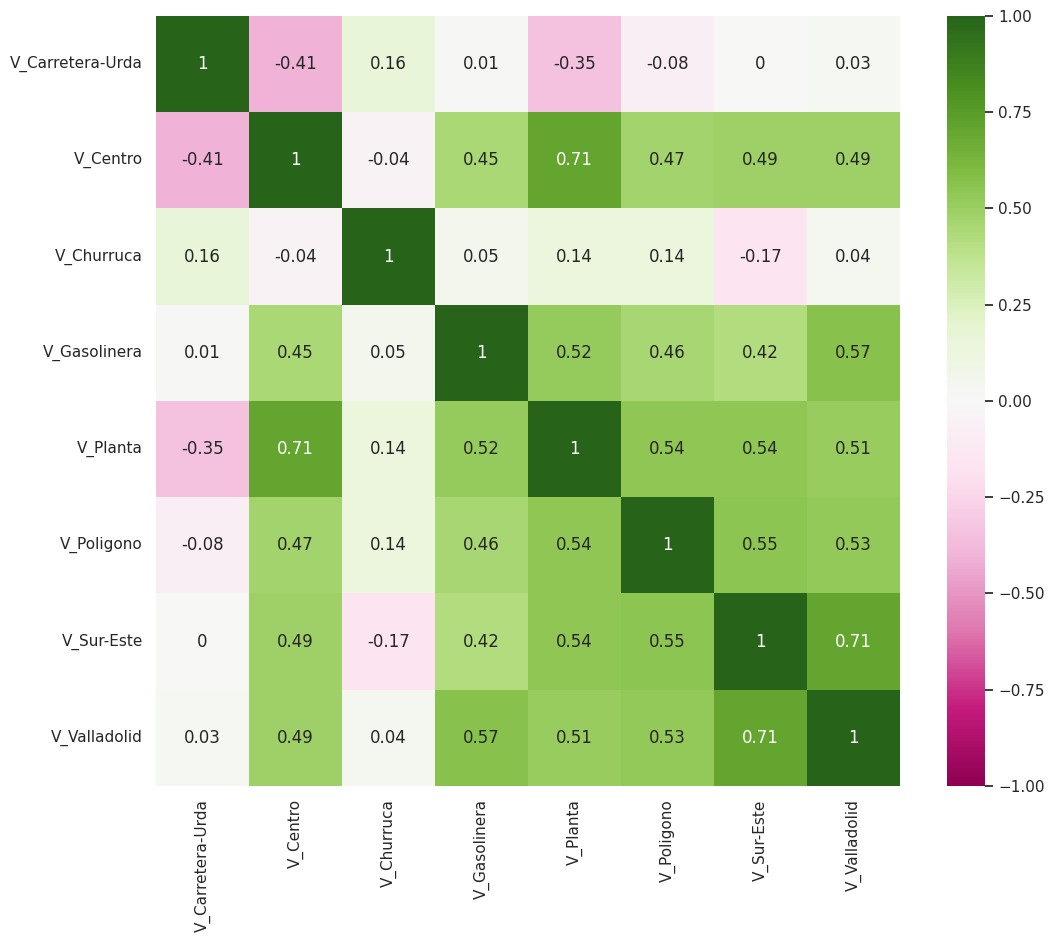

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(3,11))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

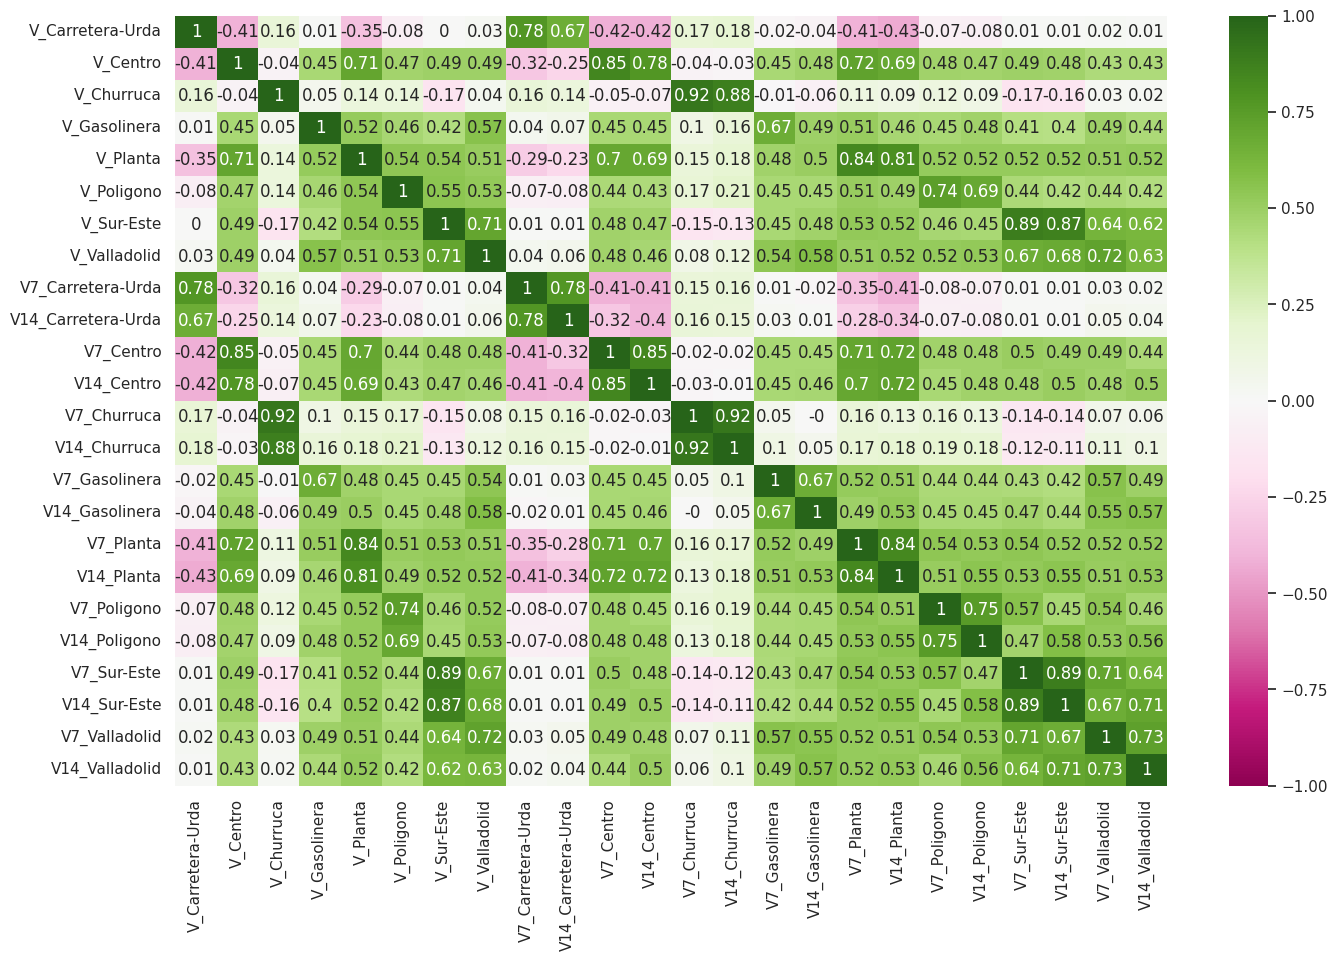

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
cols = list(range(3,11)) + list(range(33,49))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

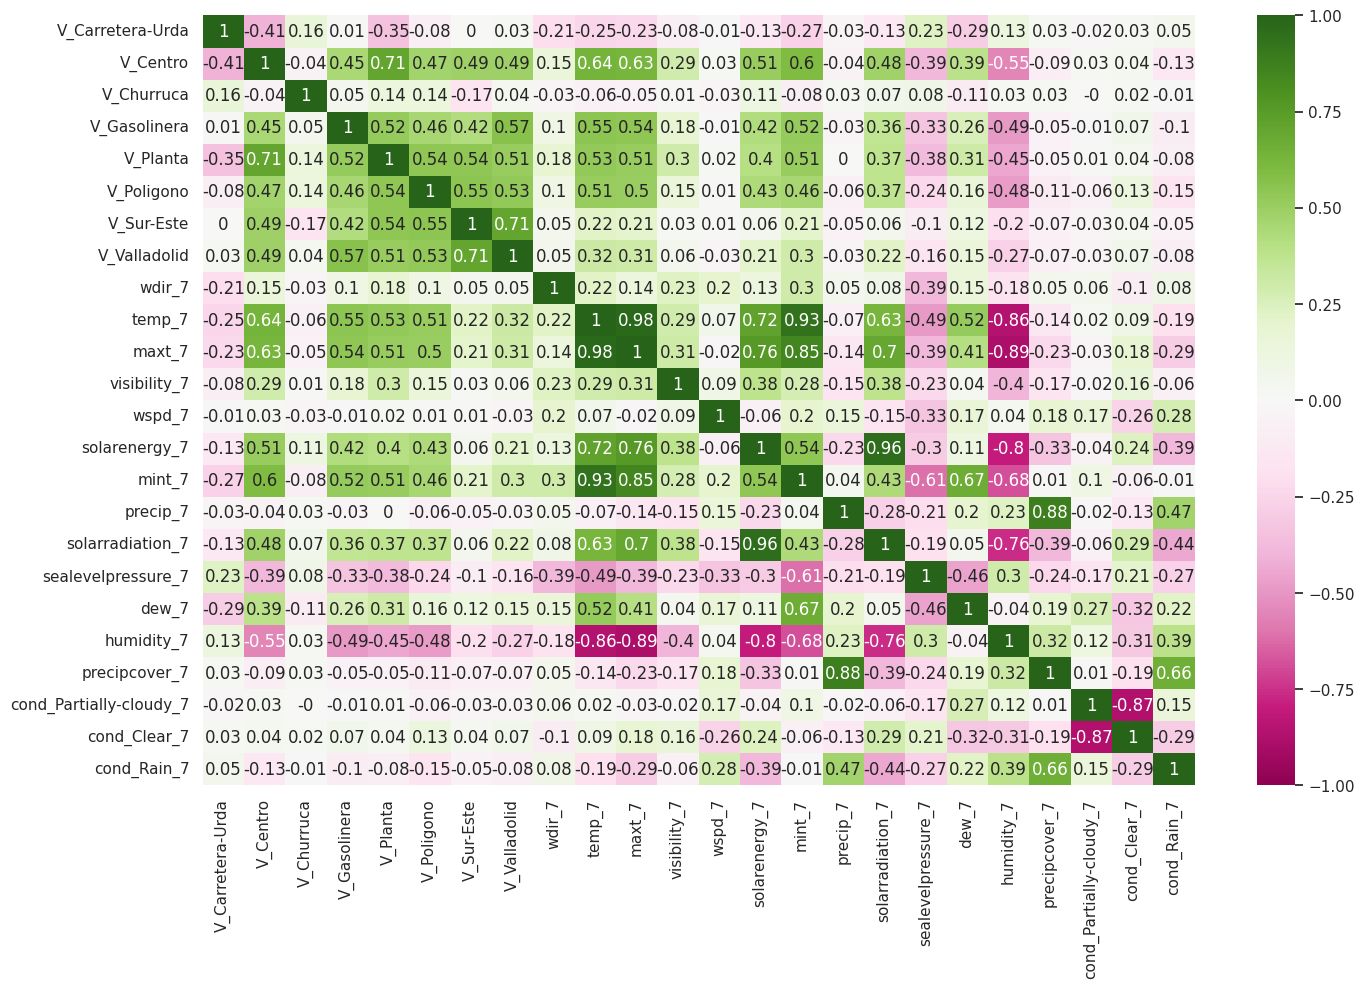

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
cols = list(range(3,11)) + list(range(49,65))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

In [ ]:
#'temp_7','maxt_7', 'solarenergy_7', 'mint_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'humidity_7'

In [ ]:
df_encshift.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'V_Carretera-Urda', 'V_Centro',
       'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este',
       'V_Valladolid', 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes',
       'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
       'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable',
       'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes',
       'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS',
       'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS', 'V7_Carretera-Urda',
       'V14_Carretera-Urda', 'V7_Centro', 'V14_Centro', 'V7_Churruca',
       'V14_Churruca', 'V7_Gasolinera', 'V14_Gasolinera', 'V7_Planta',
       'V14_Planta', 'V7_Poligono', 'V14_Poligono', 'V7_Sur-Este',
       'V14_Sur-Este', 'V7_Valladolid', 'V14_Valladolid', 'wdir_7', 'temp_7',
       'maxt_7', 'visibility_7', 'wspd_7', 'solarenergy_7', 'mint_7',
       'precip_7', 'solarradiation_7', 'sealevelp

In [ ]:
sel_cols = ['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
            'V7_Carretera-Urda', 'V7_Centro', 'V7_Churruca', 'V7_Gasolinera', 'V7_Planta', 'V7_Poligono', 'V7_Sur-Este', 'V7_Valladolid',
            'wdir_7', 'temp_7', 'maxt_7', 'visibility_7', 'solarenergy_7', 'mint_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'humidity_7',
            'N_Mes', 'N_Ano', 'Mes_SIN', 'Mes_COS']

In [ ]:
df_sel = df_encshift[sel_cols].copy()
df_sel

V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  \
0                1.0200    1.7812     11.1250        1.0900    2.4531   
1                0.9199    1.5625     11.0000        1.1100    2.5156   
2                0.9502    1.5312     10.0000        1.1800    2.4375   
3                0.8901    1.5000      9.3750        0.9700    2.1719   
4                0.8599    1.5312      9.1250        0.9400    2.0781   
...                 ...       ...         ...           ...       ...   
46391            0.1504    1.2891      0.8026        0.5800    1.5898   
46392            0.1568    1.2268      0.5308        0.5900    1.6428   
46393            0.1553    1.2660      0.5320        0.6700    1.7458   
46394            0.1624    1.2557      1.4712        0.7200    1.9044   
46395            0.1639    1.2594      1.7625        0.7900    2.1161   

       V_Poligono  V_Sur-Este  V_Valladolid  V7_Carretera-Urda  V7_Centro  \
0          1.7251      5.5625        9.6875             0.4399     1.7500   
1          1.8049      5.7500        9.9375             0.5200     1.8125   
2          1.7511      5.2500        9.5625             0.3901     1.5937   
3          1.7725      4.8750        8.8125             0.4302     1.4375   
4          1.6115      4.5625        8.3750             0.3599     1.4375   
...           ...         ...           ...                ...        ...   
46391      0.0025      6.3750        7.1992             0.1504     1.1016   
46392      0.3573      6.8750        7.4638             0.1602     1.1680   
46393      0.4748      7.2500        8.1185             0.1484     1.2422   
46394      0.5197      8.2500        9.3019             0.1602     1.2188   
46395      0.6935      8.7500       10.0126             0.1914     1.2617   

       ...  solarenergy_7  mint_7  solarradiation_7  sealevelpressure_7  \
0      ...        25.0000 15.2000          463.1000          1,014.5000   
1      ...        25.0000 15.2000          463.1000          1,014.5000   
2      ...        25.0000 15.2000          463.1000          1,014.5000   
3      ...        25.0000 15.2000          463.1000          1,014.5000   
4      ...        25.0000 15.2000          463.1000          1,014.5000   
...    ...            ...     ...               ...                 ...   
46391  ...         2.3000  4.0000           63.2000          1,012.0000   
46392  ...         2.3000  4.0000           63.2000          1,012.0000   
46393  ...         2.3000  4.0000           63.2000          1,012.0000   
46394  ...         2.3000  4.0000           63.2000          1,012.0000   
46395  ...         2.3000  4.0000           63.2000          1,012.0000   

        dew_7  humidity_7  N_Mes  N_Ano  Mes_SIN  Mes_COS  
0     11.8000     46.6400      8   2021  -0.5000  -0.8660  
1     11.8000     46.6400      8   2021  -0.5000  -0.8660  
2     11.8000     46.6400      8   2021  -0.5000  -0.8660  
3     11.8000     46.6400      8   2021  -0.5000  -0.8660  
4     11.8000     46.6400      8   2021  -0.5000  -0.8660  
...       ...         ...    ...    ...      ...      ...  
46391  8.1000     94.9100     12   2022  -0.5000   0.8660  
46392  8.1000     94.9100     12   2022  -0.5000   0.8660  
46393  8.1000     94.9100     12   2022  -0.5000   0.8660  
46394  8.1000     94.9100     12   2022  -0.5000   0.8660  
46395  8.1000     94.9100     12   2022  -0.5000   0.8660  

[46396 rows x 30 columns]

<Axes: >

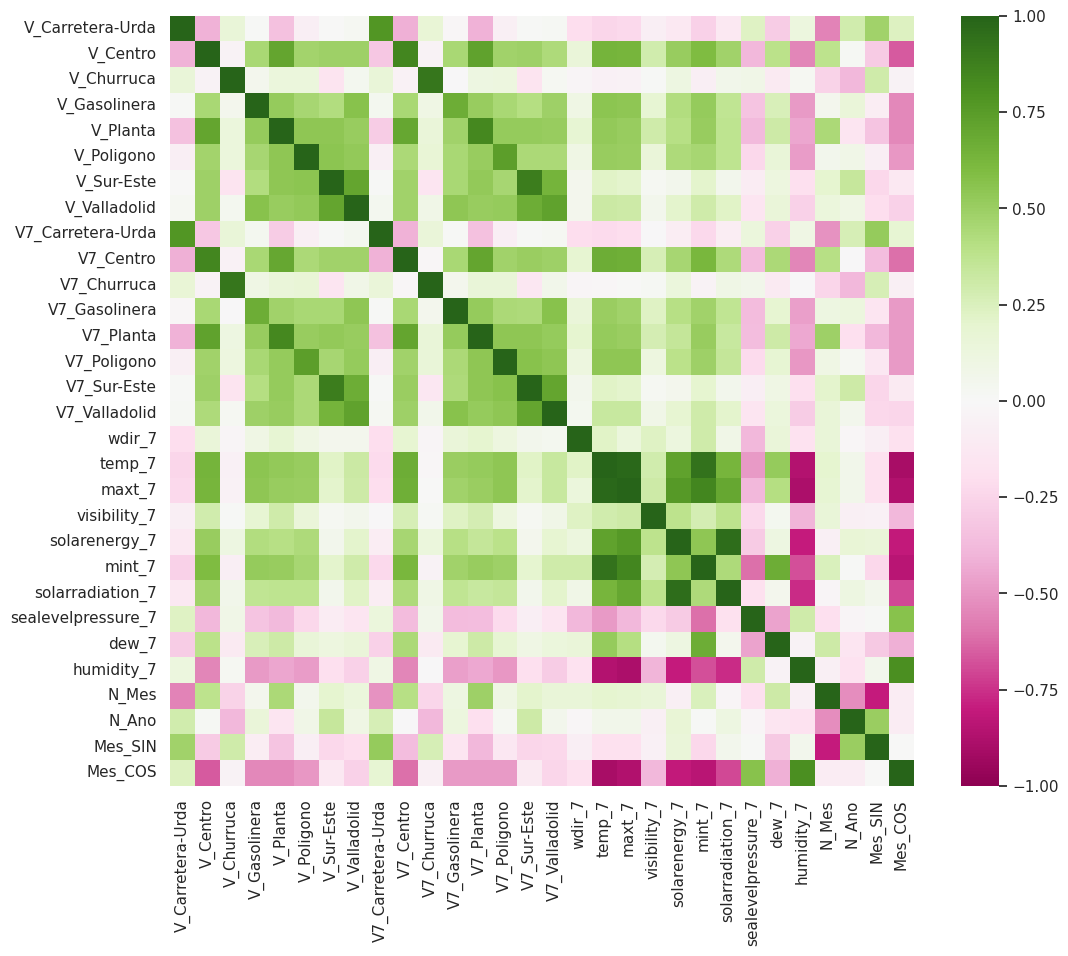

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
df_corr = df_sel.copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=False, cmap="PiYG")

## 2. ML MODEL: XGBOOST

### Target & Predictor variables

In [113]:
df_model = df_encshift.copy()
df_model

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-23 00:15:00+00:00  2021-08-23    00:15:00            0.3599   
1      2021-08-23 00:30:00+00:00  2021-08-23    00:30:00            0.3799   
2      2021-08-23 00:45:00+00:00  2021-08-23    00:45:00            0.7500   
3      2021-08-23 01:00:00+00:00  2021-08-23    01:00:00            0.3901   
4      2021-08-23 01:15:00+00:00  2021-08-23    01:15:00            0.3398   
...                          ...         ...         ...               ...   
45719  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00            0.1504   
45720  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00            0.1568   
45721  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00            0.1553   
45722  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00            0.1624   
45723  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00            0.1639   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        2.0000     11.5000        1.2300    3.0938      1.5216      4.8125   
1        1.8438     11.0000        1.2800    2.8750      1.5239      4.9375   
2        1.7500     10.5000        1.0700    2.7188      1.3401      4.5000   
3        1.5938      9.8750        1.1100    2.5000      1.2925      4.4375   
4        1.8438      9.1875        1.0900    2.1250      1.3253      4.4375   
...         ...         ...           ...       ...         ...         ...   
45719    1.2891      0.8026        0.5800    1.5898      0.0025      6.3750   
45720    1.2268      0.5308        0.5900    1.6428      0.3573      6.8750   
45721    1.2660      0.5320        0.6700    1.7458      0.4748      7.2500   
45722    1.2557      1.4712        0.7200    1.9044      0.5197      8.2500   
45723    1.2594      1.7625        0.7900    2.1161      0.6935      8.7500   

       ...  precip_7  solarradiation_7  sealevelpressure_7   dew_7  \
0      ...    0.0000          493.9000          1,015.4000 -4.7000   
1      ...    0.0000          493.9000          1,015.4000 -4.7000   
2      ...    0.0000          493.9000          1,015.4000 -4.7000   
3      ...    0.0000          493.9000          1,015.4000 -4.7000   
4      ...    0.0000          493.9000          1,015.4000 -4.7000   
...    ...       ...               ...                 ...     ...   
45719  ...    2.6000           63.2000          1,012.0000  8.1000   
45720  ...    2.6000           63.2000          1,012.0000  8.1000   
45721  ...    2.6000           63.2000          1,012.0000  8.1000   
45722  ...    2.6000           63.2000          1,012.0000  8.1000   
45723  ...    2.6000           63.2000          1,012.0000  8.1000   

       humidity_7  precipcover_7  cond_Partially-cloudy_7  cond_Clear_7  \
0         10.4900         0.0000                   0.0000        1.0000   
1         10.4900         0.0000                   0.0000        1.0000   
2         10.4900         0.0000                   0.0000        1.0000   
3         10.4900         0.0000                   0.0000        1.0000   
4         10.4900         0.0000                   0.0000        1.0000   
...           ...            ...                      ...           ...   
45719     94.9100        35.2900                   1.0000        0.0000   
45720     94.9100        35.2900                   1.0000        0.0000   
45721     94.9100        35.2900                   1.0000        0.0000   
45722     94.9100        35.2900                   1.0000        0.0000   
45723     94.9100        35.2900                   1.0000        0.0000   

       cond_Rain_7  cond_Overcast_7  
0           0.0000           0.0000  
1           0.0000           0.0000  
2           0.0000           0.0000  
3           0.0000           0.0000  
4           0.0000           0.0000  
...            ...              ...  
45719       1.0000           0.0000  
45720       1.0000           0.0000  
45721       1.0000           0.0000  
45722       1.0000

In [114]:
target_cols = [x for x in list(df_model.columns) if x.startswith('V_')]
#target_cols = list(set(target_cols) - set(untarget_cols))
target_cols

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid']

In [115]:
#filter_list = ''

In [116]:
unselect_comvars = []

try:
  print(filter_list[0])

except:
  filter_list = []
  print('"filter_dict" created')


DiaSem_Domingo


In [117]:

data_cols = list(df_model.columns)
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)

del_cols = list(target_cols + unselect_comvars + filter_list + cat_vars)
select_vars = [x for x in list(df_model.columns) if x not in del_cols]
select_vars

print(select_vars)


['N_DiaMes', 'N_Mes', 'N_Ano', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS', 'V7_Centro', 'V7_Churruca', 'V14_Churruca', 'V7_Gasolinera', 'V14_Gasolinera', 'V7_Planta', 'V7_Sur-Este', 'V14_Sur-Este', 'V7_Valladolid', 'V14_Valladolid', 'temp_7', 'solarenergy_7', 'mint_7', 'dew_7', 'precipcover_7']


### Test dates

In [118]:

#start_date = dt.date(2022, 12, 1)
start_date = dt.date(2022, 12, 3)
end_date = dt.date(2022, 12, 3)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta

test_dates = []
i = 0

for x in range(delta.days + 1):
  day = start_date + dt.timedelta(days=x)
  test_dates.append(str(day))

test_dates[:5]


['2022-12-03']

### Model definition

In [119]:
ML_model = XGBRegressor(nthread=-1, verbosity=1)  # objective='reg:tweedie' # n_estimators=100, max_depth=6, eta=0.3

In [120]:
train_dict = {}
test_dict = {}

for y in test_dates:

  train_dict[y] = {}
  test_dict[y] = {}

  print('\n')
  print(f'Model XGBoost (Test "{y}")')
  print('_'*70)

  day = dt.datetime.strptime(y, '%Y-%m-%d')
  y7 = str(day + dt.timedelta(days=6))

  start = time.time()

  X_train = df_model[(df_model['RowKey_Date']<y)][select_vars]
  y_train = df_model[(df_model['RowKey_Date']<y)][target_cols].copy()
  y_train.reset_index(drop=True, inplace=True)
  #y_train.rename("y_true", inplace=True)

  X_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][select_vars]
  y_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][target_cols].copy()
  y_test.reset_index(drop=True, inplace=True)
  #y_test.rename("y_true", inplace=True)

  ML_model.fit(X_train, y_train)
  y_trainpred = pd.DataFrame(ML_model.predict(X_train), columns=[x.replace('V_','PredV_') for x in target_cols])
  for k, v in y_trainpred.items():
    v[v < 0] = 0
  #y_trainpred[y_trainpred<0] = 0
  y_testpred = pd.DataFrame(ML_model.predict(X_test), columns=[x.replace('V_','PredV_') for x in target_cols])
  for k, v in y_testpred.items():
    v[v < 0] = 0
  #y_testpred[y_testpred<0] = 0

  df_auxtrain = df_model[(df_model['RowKey_Date']<y)][['RowKey','RowKey_Date','RowKey_Time']].copy()
  df_auxtrain.reset_index(drop=True, inplace=True)
  train_res = pd.concat([df_auxtrain, y_train, y_trainpred], axis=1)
  df_auxtest = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][['RowKey','RowKey_Date','RowKey_Time']].copy()
  df_auxtest.reset_index(drop=True, inplace=True)
  test_res = pd.concat([df_auxtest, y_test, y_testpred], axis=1).reset_index(drop=True)
  train_dict[y] = train_res
  test_dict[y] = test_res

  df_aux = pd.DataFrame(columns=['RowKey_Date'])
  #df_aux = pd.DataFrame(columns=cols)
  df_aux = pd.concat([df_aux, pd.DataFrame(ML_model.feature_importances_, index=select_vars).transpose()], axis=1)
  #df_aux.loc[:,'STA_Label'] = x
  df_aux.loc[:,'RowKey_Date'] = y

  if test_dates.index(y)==0:
    imp_df = df_aux.copy()
  else:
    imp_df = pd.concat([imp_df, df_aux], axis=0)
    #imp_df = pd.concat([imp_df, df_aux], axis=0)
    imp_df.reset_index(drop=True,inplace=True)
    imp_df

  end = time.time()
  #print('_'*35)
  print(f'-Train/Test completed ({timedelta(minutes=end-start)}))')
  #print('\n')




Model XGBoost (Test "2022-12-03")
______________________________________________________________________
-Train/Test completed (0:08:23.922873))


In [121]:
train_dict.keys()

dict_keys(['2022-12-03'])

In [122]:
train_dict['2022-12-03']

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-23 00:15:00+00:00  2021-08-23    00:15:00            0.3599   
1      2021-08-23 00:30:00+00:00  2021-08-23    00:30:00            0.3799   
2      2021-08-23 00:45:00+00:00  2021-08-23    00:45:00            0.7500   
3      2021-08-23 01:00:00+00:00  2021-08-23    01:00:00            0.3901   
4      2021-08-23 01:15:00+00:00  2021-08-23    01:15:00            0.3398   
...                          ...         ...         ...               ...   
44827  2022-12-02 23:00:00+00:00  2022-12-02    23:00:00            0.1602   
44828  2022-12-02 23:15:00+00:00  2022-12-02    23:15:00            0.2109   
44829  2022-12-02 23:30:00+00:00  2022-12-02    23:30:00            0.1992   
44830  2022-12-02 23:45:00+00:00  2022-12-02    23:45:00            0.2012   
44831  2022-12-03 00:00:00+00:00  2022-12-02    00:00:00            0.2383   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        2.0000     11.5000        1.2300    3.0938      1.5216      4.8125   
1        1.8438     11.0000        1.2800    2.8750      1.5239      4.9375   
2        1.7500     10.5000        1.0700    2.7188      1.3401      4.5000   
3        1.5938      9.8750        1.1100    2.5000      1.2925      4.4375   
4        1.8438      9.1875        1.0900    2.1250      1.3253      4.4375   
...         ...         ...           ...       ...         ...         ...   
44827    1.8086      3.0688        1.0700    2.4609      0.6550      8.6250   
44828    1.7695      2.9625        0.9400    2.3086      0.6579      8.5000   
44829    1.7500      2.2662        0.8900    2.3125      0.5035      8.2500   
44830    1.6719      1.2806        0.8400    2.0781      0.5186      7.7500   
44831    1.7578      0.5650        0.6900    1.9922      0.4950      7.5000   

       V_Valladolid  PredV_Carretera-Urda  PredV_Centro  PredV_Churruca  \
0            9.3125                0.3236        2.1895         11.4447   
1            9.3125                0.3526        1.9014         10.9197   
2            8.5000                0.4131        1.8587         10.4410   
3            8.5000                0.3262        1.7414          9.8355   
4            8.3125                0.3262        1.8319          9.3366   
...             ...                   ...           ...             ...   
44827       10.4023                0.2451        1.8845          3.2501   
44828       10.0977                0.2175        1.8142          2.5574   
44829        9.6992                0.1861        1.6901          2.3221   
44830        9.1016                0.2039        1.7924          1.6980   
44831        8.6016                0.1755        1.5480          1.6656   

       PredV_Gasolinera  PredV_Planta  PredV_Poligono  PredV_Sur-Este  \
0                1.1934        2.8533          1.4110          4.7398   
1                1.2002        2.7048          1.5238          5.0185   
2                1.2336        2.5639          1.4824          4.4527   
3                1.0291        2.3355          1.3962          4.2792   
4                1.0291        2.2700          1.3284          4.3034   
...                 ...           ...             ...             ...   
44827            1.1236        2.2027          0.6758          8.7883   
44828            0.9661        2.1870          0.6918          8.5050   
44829            1.0076        2.6247          0.7038          8.0138   
44830            1.0103        2.6516          0.6768          7.9678   
44831            0.9869        2.6249          0.6890          7.7307   

       PredV_Valladolid  
0                9.4666  
1                9.5713  
2                8.6494  
3                7.9123  
4                7.6661  
...                 ...  
44827           11.1498  
44828           10.5390  
44829            9.9617  
44830            9.3847  
44831            9.3187  

[44832 rows x 19 columns]

In [123]:
test_dict.keys()

dict_keys(['2022-12-03'])

In [124]:
test_dict['2022-12-03']

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0    2022-12-03 00:15:00+00:00  2022-12-03    00:15:00            0.1602   
1    2022-12-03 00:30:00+00:00  2022-12-03    00:30:00            0.1816   
2    2022-12-03 00:45:00+00:00  2022-12-03    00:45:00            0.1484   
3    2022-12-03 01:00:00+00:00  2022-12-03    01:00:00            0.1602   
4    2022-12-03 01:15:00+00:00  2022-12-03    01:15:00            0.2012   
..                         ...         ...         ...               ...   
667  2022-12-09 23:00:00+00:00  2022-12-09    23:00:00            0.2207   
668  2022-12-09 23:15:00+00:00  2022-12-09    23:15:00            0.2793   
669  2022-12-09 23:30:00+00:00  2022-12-09    23:30:00            0.1602   
670  2022-12-09 23:45:00+00:00  2022-12-09    23:45:00            0.1797   
671  2022-12-10 00:00:00+00:00  2022-12-09    00:00:00            0.1797   

     V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0      1.6797      1.4225        0.7400    2.0391      0.4091      6.7500   
1      1.5820      1.2162        0.6700    1.9102      0.4505      7.1250   
2      1.4102      0.7398        0.6900    1.9492      0.4611      7.0000   
3      1.3711      0.3319        0.6800    1.9492      0.4925      6.8750   
4      1.3281      0.3319        0.6200    1.8828      0.5232      6.7500   
..        ...         ...           ...       ...         ...         ...   
667    1.6211      2.3506        0.9600    2.5078      0.6000      8.8750   
668    1.8906      2.4106        0.8800    2.8984      0.6476      8.6250   
669    1.8477      2.6575        0.9300    2.5508      0.4491      8.2500   
670    1.6797      2.3419        0.7600    2.4023      0.4562      8.2500   
671    1.7617      1.7581        0.7600    2.3281      0.4100      7.6250   

     V_Valladolid  PredV_Carretera-Urda  PredV_Centro  PredV_Churruca  \
0          7.8984                0.1230        1.5444          1.0778   
1          8.1992                0.1220        1.3812          0.6035   
2          7.9023                0.1214        1.3740          0.4633   
3          7.6992                0.1220        1.3132          0.8486   
4          7.5977                0.1224        1.5091          0.8297   
..            ...                   ...           ...             ...   
667       10.6016                0.2191        1.3411          0.8566   
668       10.3984                0.2308        1.3003          1.1224   
669       10.0000                0.2390        1.2955          0.8471   
670        9.3984                0.1894        1.3018          0.9992   
671        9.1016                0.1981        1.2002          0.6070   

     PredV_Gasolinera  PredV_Planta  PredV_Poligono  PredV_Sur-Este  \
0              0.7223        2.1262          1.0238          7.8004   
1              0.6406        2.1324          1.0144          7.3077   
2              0.5263        1.8478          1.0013          7.0872   
3              0.5002        1.8478          1.1522          7.0872   
4              0.4893        1.8228          1.1275          7.1261   
..                ...           ...             ...             ...   
667            0.9966        2.3708          0.7970          8.5219   
668            0.9112        2.4199          0.8061          8.4956   
669            0.9401        2.4199          0.7714          8.3421   
670            0.8819        2.0363          0.8032          7.8938   
671            0.8210        2.0000          0.7328          7.5380   

     PredV_Valladolid  
0              8.4554  
1              8.3001  
2              7.1389  
3              7.3473  
4              7.1076  
..                ...  
667           10.2408  
668            9.4344  
669            9.5617  
670            8.9060  
671            8.5596  

[672 rows x 19 columns]

In [125]:
imp_df

RowKey_Date  N_DiaMes  N_Mes  N_Ano  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  \
0  2022-12-03    0.0180 0.0608 0.0305   0.0269   0.0093   0.0231   0.0582   

   V7_Centro  V7_Churruca  ...  V7_Planta  V7_Sur-Este  V14_Sur-Este  \
0     0.0114       0.3555  ...     0.0361       0.0510        0.0386   

   V7_Valladolid  V14_Valladolid  temp_7  solarenergy_7  mint_7  dew_7  \
0         0.1304          0.0083  0.0160         0.0087  0.0081 0.0076   

   precipcover_7  
0         0.0069  

[1 rows x 23 columns]

### Feature importance

In [126]:
cols = [x for x in list(df_model.columns) if x in list(imp_df.columns)]
imp_df = imp_df[cols]
imp_df

RowKey_Date  N_DiaMes  N_Mes  N_Ano  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  \
0  2022-12-03    0.0180 0.0608 0.0305   0.0269   0.0093   0.0231   0.0582   

   V7_Centro  V7_Churruca  ...  V7_Planta  V7_Sur-Este  V14_Sur-Este  \
0     0.0114       0.3555  ...     0.0361       0.0510        0.0386   

   V7_Valladolid  V14_Valladolid  temp_7  solarenergy_7  mint_7  dew_7  \
0         0.1304          0.0083  0.0160         0.0087  0.0081 0.0076   

   precipcover_7  
0         0.0069  

[1 rows x 23 columns]

In [127]:
imp_df.iloc[:,range(0,15)]

RowKey_Date  N_DiaMes  N_Mes  N_Ano  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  \
0  2022-12-03    0.0180 0.0608 0.0305   0.0269   0.0093   0.0231   0.0582   

   V7_Centro  V7_Churruca  V14_Churruca  V7_Gasolinera  V14_Gasolinera  \
0     0.0114       0.3555        0.0558         0.0139          0.0249   

   V7_Planta  V7_Sur-Este  
0     0.0361       0.0510

In [128]:
imp_df.iloc[:,list(range(0,1))+list(range(15,23))]

RowKey_Date  V14_Sur-Este  V7_Valladolid  V14_Valladolid  temp_7  \
0  2022-12-03        0.0386         0.1304          0.0083  0.0160   

   solarenergy_7  mint_7  dew_7  precipcover_7  
0         0.0087  0.0081 0.0076         0.0069

In [129]:
#mant_cols = [x.replace('V_','V7_') for x in target_cols] + [x.replace('V_','V14_') for x in target_cols] + [x.replace('V_','V21_') for x in target_cols]
mant_cols = []

pred_cols = [x for x in list(imp_df.columns) if (x!='RowKey_Date') and (x not in mant_cols)]

for y in pred_cols:
  imp_value = imp_df[y].mean()

  if imp_value < 0.006:
    filter_list.append(y)


In [130]:
filter_list

['DiaSem_Domingo',
 'DiaSem_Jueves',
 'DiaSem_Lunes',
 'DiaSem_Martes',
 'DiaSem_Miercoles',
 'DiaSem_Sabado',
 'DiaSem_Viernes',
 'Clasif_Lab_Laborable',
 'Clasif_Lab_No Laborable',
 'Clasif_Fest_Festivo',
 'Clasif_Fest_No Festivo',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'V7_Carretera-Urda',
 'V14_Carretera-Urda',
 'V21_Carretera-Urda',
 'V14_Centro',
 'V21_Centro',
 'V21_Churruca',
 'V21_Gasolinera',
 'V14_Planta',
 'V21_Planta',
 'V7_Poligono',
 'V14_Poligono',
 'V21_Poligono',
 'V21_Sur-Este',
 'V21_Valladolid',
 'wdir_7',
 'maxt_7',
 'visibility_7',
 'wspd_7',
 'precip_7',
 'solarradiation_7',
 'sealevelpressure_7',
 'humidity_7',
 'cond_Partially-cloudy_7',
 'cond_Clear_7',
 'cond_Rain_7',
 'cond_Overcast_7']

### Train/Test scores

In [131]:
train_dict.keys()

dict_keys(['2022-12-03'])

In [132]:
train_dict['2022-12-03']

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-23 00:15:00+00:00  2021-08-23    00:15:00            0.3599   
1      2021-08-23 00:30:00+00:00  2021-08-23    00:30:00            0.3799   
2      2021-08-23 00:45:00+00:00  2021-08-23    00:45:00            0.7500   
3      2021-08-23 01:00:00+00:00  2021-08-23    01:00:00            0.3901   
4      2021-08-23 01:15:00+00:00  2021-08-23    01:15:00            0.3398   
...                          ...         ...         ...               ...   
44827  2022-12-02 23:00:00+00:00  2022-12-02    23:00:00            0.1602   
44828  2022-12-02 23:15:00+00:00  2022-12-02    23:15:00            0.2109   
44829  2022-12-02 23:30:00+00:00  2022-12-02    23:30:00            0.1992   
44830  2022-12-02 23:45:00+00:00  2022-12-02    23:45:00            0.2012   
44831  2022-12-03 00:00:00+00:00  2022-12-02    00:00:00            0.2383   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        2.0000     11.5000        1.2300    3.0938      1.5216      4.8125   
1        1.8438     11.0000        1.2800    2.8750      1.5239      4.9375   
2        1.7500     10.5000        1.0700    2.7188      1.3401      4.5000   
3        1.5938      9.8750        1.1100    2.5000      1.2925      4.4375   
4        1.8438      9.1875        1.0900    2.1250      1.3253      4.4375   
...         ...         ...           ...       ...         ...         ...   
44827    1.8086      3.0688        1.0700    2.4609      0.6550      8.6250   
44828    1.7695      2.9625        0.9400    2.3086      0.6579      8.5000   
44829    1.7500      2.2662        0.8900    2.3125      0.5035      8.2500   
44830    1.6719      1.2806        0.8400    2.0781      0.5186      7.7500   
44831    1.7578      0.5650        0.6900    1.9922      0.4950      7.5000   

       V_Valladolid  PredV_Carretera-Urda  PredV_Centro  PredV_Churruca  \
0            9.3125                0.3236        2.1895         11.4447   
1            9.3125                0.3526        1.9014         10.9197   
2            8.5000                0.4131        1.8587         10.4410   
3            8.5000                0.3262        1.7414          9.8355   
4            8.3125                0.3262        1.8319          9.3366   
...             ...                   ...           ...             ...   
44827       10.4023                0.2451        1.8845          3.2501   
44828       10.0977                0.2175        1.8142          2.5574   
44829        9.6992                0.1861        1.6901          2.3221   
44830        9.1016                0.2039        1.7924          1.6980   
44831        8.6016                0.1755        1.5480          1.6656   

       PredV_Gasolinera  PredV_Planta  PredV_Poligono  PredV_Sur-Este  \
0                1.1934        2.8533          1.4110          4.7398   
1                1.2002        2.7048          1.5238          5.0185   
2                1.2336        2.5639          1.4824          4.4527   
3                1.0291        2.3355          1.3962          4.2792   
4                1.0291        2.2700          1.3284          4.3034   
...                 ...           ...             ...             ...   
44827            1.1236        2.2027          0.6758          8.7883   
44828            0.9661        2.1870          0.6918          8.5050   
44829            1.0076        2.6247          0.7038          8.0138   
44830            1.0103        2.6516          0.6768          7.9678   
44831            0.9869        2.6249          0.6890          7.7307   

       PredV_Valladolid  
0                9.4666  
1                9.5713  
2                8.6494  
3                7.9123  
4                7.6661  
...                 ...  
44827           11.1498  
44828           10.5390  
44829            9.9617  
44830            9.3847  
44831            9.3187  

[44832 rows x 19 columns]

In [133]:
test_dict.keys()

dict_keys(['2022-12-03'])

In [134]:
test_dict['2022-12-03']

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0    2022-12-03 00:15:00+00:00  2022-12-03    00:15:00            0.1602   
1    2022-12-03 00:30:00+00:00  2022-12-03    00:30:00            0.1816   
2    2022-12-03 00:45:00+00:00  2022-12-03    00:45:00            0.1484   
3    2022-12-03 01:00:00+00:00  2022-12-03    01:00:00            0.1602   
4    2022-12-03 01:15:00+00:00  2022-12-03    01:15:00            0.2012   
..                         ...         ...         ...               ...   
667  2022-12-09 23:00:00+00:00  2022-12-09    23:00:00            0.2207   
668  2022-12-09 23:15:00+00:00  2022-12-09    23:15:00            0.2793   
669  2022-12-09 23:30:00+00:00  2022-12-09    23:30:00            0.1602   
670  2022-12-09 23:45:00+00:00  2022-12-09    23:45:00            0.1797   
671  2022-12-10 00:00:00+00:00  2022-12-09    00:00:00            0.1797   

     V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0      1.6797      1.4225        0.7400    2.0391      0.4091      6.7500   
1      1.5820      1.2162        0.6700    1.9102      0.4505      7.1250   
2      1.4102      0.7398        0.6900    1.9492      0.4611      7.0000   
3      1.3711      0.3319        0.6800    1.9492      0.4925      6.8750   
4      1.3281      0.3319        0.6200    1.8828      0.5232      6.7500   
..        ...         ...           ...       ...         ...         ...   
667    1.6211      2.3506        0.9600    2.5078      0.6000      8.8750   
668    1.8906      2.4106        0.8800    2.8984      0.6476      8.6250   
669    1.8477      2.6575        0.9300    2.5508      0.4491      8.2500   
670    1.6797      2.3419        0.7600    2.4023      0.4562      8.2500   
671    1.7617      1.7581        0.7600    2.3281      0.4100      7.6250   

     V_Valladolid  PredV_Carretera-Urda  PredV_Centro  PredV_Churruca  \
0          7.8984                0.1230        1.5444          1.0778   
1          8.1992                0.1220        1.3812          0.6035   
2          7.9023                0.1214        1.3740          0.4633   
3          7.6992                0.1220        1.3132          0.8486   
4          7.5977                0.1224        1.5091          0.8297   
..            ...                   ...           ...             ...   
667       10.6016                0.2191        1.3411          0.8566   
668       10.3984                0.2308        1.3003          1.1224   
669       10.0000                0.2390        1.2955          0.8471   
670        9.3984                0.1894        1.3018          0.9992   
671        9.1016                0.1981        1.2002          0.6070   

     PredV_Gasolinera  PredV_Planta  PredV_Poligono  PredV_Sur-Este  \
0              0.7223        2.1262          1.0238          7.8004   
1              0.6406        2.1324          1.0144          7.3077   
2              0.5263        1.8478          1.0013          7.0872   
3              0.5002        1.8478          1.1522          7.0872   
4              0.4893        1.8228          1.1275          7.1261   
..                ...           ...             ...             ...   
667            0.9966        2.3708          0.7970          8.5219   
668            0.9112        2.4199          0.8061          8.4956   
669            0.9401        2.4199          0.7714          8.3421   
670            0.8819        2.0363          0.8032          7.8938   
671            0.8210        2.0000          0.7328          7.5380   

     PredV_Valladolid  
0              8.4554  
1              8.3001  
2              7.1389  
3              7.3473  
4              7.1076  
..                ...  
667           10.2408  
668            9.4344  
669            9.5617  
670            8.9060  
671            8.5596  

[672 rows x 19 columns]

In [135]:
target_cols[:5]

['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta']

In [136]:
test_dates[:5]

['2022-12-03']

In [137]:
y = '2022-12-02'

In [138]:

df_scores = pd.DataFrame(columns=['RowKey_Date', 'Train_MAPE','Train_MAE','Train_RMSE','Test_MAPE','Test_MAE','Test_RMSE'])
i = 0

for y in test_dates:

  df_scores.loc[i,'RowKey_Date'] = y
  true_cols = [x for x in list(train_dict[y].columns) if x.startswith('V_')]
  pred_cols = [x for x in list(train_dict[y].columns) if x.startswith('PredV_')]

  # TRAIN SCORES
  y_true = train_dict[y].loc[:,true_cols]
  y_pred = train_dict[y].loc[:,pred_cols]
  #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
  mape = round(mape_corr_multi(y_true, y_pred), 4)
  mae = round(mean_absolute_error(y_true, y_pred), 4)
  rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

  df_scores.loc[i,'Train_MAPE'] = mape
  df_scores.loc[i,'Train_MAE'] = mae
  df_scores.loc[i,'Train_RMSE'] = rmse

  # TEST SCORES
  y_true = test_dict[y].loc[:,true_cols]
  y_pred = test_dict[y].loc[:,pred_cols]
  #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
  mape = round(mape_corr_multi(y_true, y_pred), 4)
  mae = round(mean_absolute_error(y_true, y_pred), 4)
  rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

  df_scores.loc[i,'Test_MAPE'] = mape
  df_scores.loc[i,'Test_MAE'] = mae
  df_scores.loc[i,'Test_RMSE'] = rmse

  i += 1


In [139]:
df_scores

RowKey_Date Train_MAPE Train_MAE Train_RMSE Test_MAPE Test_MAE Test_RMSE
0  2022-12-03          0    0.2380     0.3749         0   0.4792    0.7892

In [140]:
final_scores = df_scores.iloc[:,range(1,df_scores.shape[1])].mean()
final_scores

Train_MAPE   0.0000
Train_MAE    0.2380
Train_RMSE   0.3749
Test_MAPE    0.0000
Test_MAE     0.4792
Test_RMSE    0.7892
dtype: float64

In [141]:
df_model.iloc[:,range(0,11)].describe()

V_Carretera-Urda    V_Centro  V_Churruca  V_Gasolinera    V_Planta  \
count       45,724.0000 45,724.0000 45,724.0000   45,724.0000 45,724.0000   
mean             0.4867      1.5152      8.8833        1.5141      2.9293   
std              0.7040      1.1398      6.4247        1.0053      2.2071   
min              0.0000      0.0000      0.0000        0.0000      0.0000   
25%              0.0605      0.1959      1.1217        0.8800      1.3093   
50%              0.1699      1.6562      9.6250        1.2900      3.0700   
75%              0.5117      2.3477     14.0000        1.9500      4.5000   
max              4.9800      8.4023     31.5000        8.6100     17.4805   

       V_Poligono  V_Sur-Este  V_Valladolid  
count 45,724.0000 45,724.0000   45,724.0000  
mean       0.9989      6.7127        9.2992  
std        0.7060      2.4455        4.3395  
min        0.0000      0.0000        0.0000  
25%        0.5372      5.1250        6.7500  
50%        0.7414      6.5000        9.1875  
75%        1.2536      8.2500       12.1250  
max        7.2550     37.6250       42.0999

In [142]:

for y in test_dates:

  true_cols = [x for x in list(train_dict[y].columns) if x.startswith('V_')]
  pred_cols = [x for x in list(train_dict[y].columns) if x.startswith('PredV_')]

  df_train = train_dict[y]
  df_test = test_dict[y]

  if test_dates.index(y)==0:
    preds_train = df_train.copy()
    preds_test = df_test.copy()
  else:
    preds_train = pd.concat([preds_train, df_train], axis=0)
    preds_train.reset_index(drop=True,inplace=True)

    preds_test = pd.concat([preds_test, df_test], axis=0)
    preds_test.reset_index(drop=True,inplace=True)

for (i,j) in zip(pred_cols,true_cols):
  col_name = j.replace('V_','Resid_')
  preds_train[col_name] = preds_train[i] - preds_train[j]
  preds_test[col_name] = preds_test[i] - preds_test[j]


In [143]:
preds_train

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0      2021-08-23 00:15:00+00:00  2021-08-23    00:15:00            0.3599   
1      2021-08-23 00:30:00+00:00  2021-08-23    00:30:00            0.3799   
2      2021-08-23 00:45:00+00:00  2021-08-23    00:45:00            0.7500   
3      2021-08-23 01:00:00+00:00  2021-08-23    01:00:00            0.3901   
4      2021-08-23 01:15:00+00:00  2021-08-23    01:15:00            0.3398   
...                          ...         ...         ...               ...   
44827  2022-12-02 23:00:00+00:00  2022-12-02    23:00:00            0.1602   
44828  2022-12-02 23:15:00+00:00  2022-12-02    23:15:00            0.2109   
44829  2022-12-02 23:30:00+00:00  2022-12-02    23:30:00            0.1992   
44830  2022-12-02 23:45:00+00:00  2022-12-02    23:45:00            0.2012   
44831  2022-12-03 00:00:00+00:00  2022-12-02    00:00:00            0.2383   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0        2.0000     11.5000        1.2300    3.0938      1.5216      4.8125   
1        1.8438     11.0000        1.2800    2.8750      1.5239      4.9375   
2        1.7500     10.5000        1.0700    2.7188      1.3401      4.5000   
3        1.5938      9.8750        1.1100    2.5000      1.2925      4.4375   
4        1.8438      9.1875        1.0900    2.1250      1.3253      4.4375   
...         ...         ...           ...       ...         ...         ...   
44827    1.8086      3.0688        1.0700    2.4609      0.6550      8.6250   
44828    1.7695      2.9625        0.9400    2.3086      0.6579      8.5000   
44829    1.7500      2.2662        0.8900    2.3125      0.5035      8.2500   
44830    1.6719      1.2806        0.8400    2.0781      0.5186      7.7500   
44831    1.7578      0.5650        0.6900    1.9922      0.4950      7.5000   

       ...  PredV_Sur-Este  PredV_Valladolid  Resid_Carretera-Urda  \
0      ...          4.7398            9.4666               -0.0363   
1      ...          5.0185            9.5713               -0.0273   
2      ...          4.4527            8.6494               -0.3369   
3      ...          4.2792            7.9123               -0.0639   
4      ...          4.3034            7.6661               -0.0136   
...    ...             ...               ...                   ...   
44827  ...          8.7883           11.1498                0.0850   
44828  ...          8.5050           10.5390                0.0065   
44829  ...          8.0138            9.9617               -0.0131   
44830  ...          7.9678            9.3847                0.0027   
44831  ...          7.7307            9.3187               -0.0628   

       Resid_Centro  Resid_Churruca  Resid_Gasolinera  Resid_Planta  \
0            0.1895         -0.0553           -0.0366       -0.2405   
1            0.0577         -0.0803           -0.0798       -0.1702   
2            0.1087         -0.0590            0.1636       -0.1548   
3            0.1477         -0.0395           -0.0809       -0.1645   
4           -0.0119          0.1491           -0.0609        0.1450   
...             ...             ...               ...           ...   
44827        0.0759          0.1813            0.0536       -0.2582   
44828        0.0447         -0.4051            0.0261       -0.1216   
44829       -0.0599          0.0558            0.1176        0.3122   
44830        0.1205          0.4174            0.1703        0.5735   
44831       -0.2098          1.1006            0.2969        0.6327   

       Resid_Poligono  Resid_Sur-Este  Resid_Valladolid  
0             -0.1106         -0.0727            0.1541  
1             -0.0002          0.0810            0.2588  
2              0.1423         -0.0473            0.1494  
3              0.1037         -0.1583           -0.5877  
4              0.0031         -0.1341           -0.6464  
...               ...             ...               ...  
44827          0.0208          0.1633   

In [144]:
resid_cols = [x for x in list(preds_train.columns) if x.startswith('Resid_')]
resid_train = pd.DataFrame()

for x in resid_cols:
  df_aux = preds_train[(preds_train[x]<-10)|(preds_train[x]>10)].copy()
  resid_train = pd.concat([resid_train,df_aux], axis=0)

resid_train

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
10231  2021-12-07 14:00:00+00:00  2021-12-07    14:00:00            0.0195   
10234  2021-12-07 14:45:00+00:00  2021-12-07    14:45:00            0.0400   
41592  2022-10-30 06:15:00+00:00  2022-10-30    06:15:00            0.1992   
10231  2021-12-07 14:00:00+00:00  2021-12-07    14:00:00            0.0195   
10232  2021-12-07 14:15:00+00:00  2021-12-07    14:15:00            0.0903   
10234  2021-12-07 14:45:00+00:00  2021-12-07    14:45:00            0.0400   
41588  2022-10-30 05:15:00+00:00  2022-10-30    05:15:00            0.9805   

       V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
10231    1.6902      0.0000        0.9000    0.0000      1.0625      6.3125   
10234    1.9684      0.0000        0.9000    0.0000      1.1922      6.8750   
41592    1.6719      0.2050        0.5700    1.5898      2.2094     37.6250   
10231    1.6902      0.0000        0.9000    0.0000      1.0625      6.3125   
10232    1.7551      0.0000        0.9100    0.0000      1.1360      6.1875   
10234    1.9684      0.0000        0.9000    0.0000      1.1922      6.8750   
41588    8.4023      0.0000        0.4600    6.6914      1.7944      7.3750   

       ...  PredV_Sur-Este  PredV_Valladolid  Resid_Carretera-Urda  \
10231  ...          5.9698           13.1168                0.0496   
10234  ...          5.8827           12.4531                0.0290   
41592  ...         17.7553            8.7791                0.0260   
10231  ...          5.9698           13.1168                0.0496   
10232  ...          5.7850           11.5724               -0.0104   
10234  ...          5.8827           12.4531                0.0290   
41588  ...          8.4783           25.4160               -0.6458   

       Resid_Centro  Resid_Churruca  Resid_Gasolinera  Resid_Planta  \
10231       -1.0995         11.0393            0.0756        3.0455   
10234       -1.2281         11.4267            0.0865        3.3315   
41592        0.3584         -0.0244           -0.0452        0.0767   
10231       -1.0995         11.0393            0.0756        3.0455   
10232       -1.0671          8.8262            0.0277        2.8761   
10234       -1.2281         11.4267            0.0865        3.3315   
41588       -3.9371          0.2179            0.0989       -4.4185   

       Resid_Poligono  Resid_Sur-Este  Resid_Valladolid  
10231         -0.1548         -0.3427          -13.8832  
10234         -0.3908         -0.9923          -10.2969  
41592         -1.1163        -19.8697           -0.2209  
10231         -0.1548         -0.3427          -13.8832  
10232         -0.3891         -0.4025          -12.6151  
10234         -0.3908         -0.9923          -10.2969  
41588         -0.8195          1.1033          -16.6838  

[7 rows x 27 columns]

In [145]:
preds_test

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0    2022-12-03 00:15:00+00:00  2022-12-03    00:15:00            0.1602   
1    2022-12-03 00:30:00+00:00  2022-12-03    00:30:00            0.1816   
2    2022-12-03 00:45:00+00:00  2022-12-03    00:45:00            0.1484   
3    2022-12-03 01:00:00+00:00  2022-12-03    01:00:00            0.1602   
4    2022-12-03 01:15:00+00:00  2022-12-03    01:15:00            0.2012   
..                         ...         ...         ...               ...   
667  2022-12-09 23:00:00+00:00  2022-12-09    23:00:00            0.2207   
668  2022-12-09 23:15:00+00:00  2022-12-09    23:15:00            0.2793   
669  2022-12-09 23:30:00+00:00  2022-12-09    23:30:00            0.1602   
670  2022-12-09 23:45:00+00:00  2022-12-09    23:45:00            0.1797   
671  2022-12-10 00:00:00+00:00  2022-12-09    00:00:00            0.1797   

     V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0      1.6797      1.4225        0.7400    2.0391      0.4091      6.7500   
1      1.5820      1.2162        0.6700    1.9102      0.4505      7.1250   
2      1.4102      0.7398        0.6900    1.9492      0.4611      7.0000   
3      1.3711      0.3319        0.6800    1.9492      0.4925      6.8750   
4      1.3281      0.3319        0.6200    1.8828      0.5232      6.7500   
..        ...         ...           ...       ...         ...         ...   
667    1.6211      2.3506        0.9600    2.5078      0.6000      8.8750   
668    1.8906      2.4106        0.8800    2.8984      0.6476      8.6250   
669    1.8477      2.6575        0.9300    2.5508      0.4491      8.2500   
670    1.6797      2.3419        0.7600    2.4023      0.4562      8.2500   
671    1.7617      1.7581        0.7600    2.3281      0.4100      7.6250   

     ...  PredV_Sur-Este  PredV_Valladolid  Resid_Carretera-Urda  \
0    ...          7.8004            8.4554               -0.0372   
1    ...          7.3077            8.3001               -0.0597   
2    ...          7.0872            7.1389               -0.0270   
3    ...          7.0872            7.3473               -0.0382   
4    ...          7.1261            7.1076               -0.0787   
..   ...             ...               ...                   ...   
667  ...          8.5219           10.2408               -0.0016   
668  ...          8.4956            9.4344               -0.0485   
669  ...          8.3421            9.5617                0.0789   
670  ...          7.8938            8.9060                0.0097   
671  ...          7.5380            8.5596                0.0184   

     Resid_Centro  Resid_Churruca  Resid_Gasolinera  Resid_Planta  \
0         -0.1353         -0.3447           -0.0177        0.0871   
1         -0.2008         -0.6127           -0.0294        0.2222   
2         -0.0361         -0.2765           -0.1637       -0.1014   
3         -0.0579          0.5168           -0.1798       -0.1014   
4          0.1809          0.4979           -0.1307       -0.0600   
..            ...             ...               ...           ...   
667       -0.2800         -1.4940            0.0366       -0.1370   
668       -0.5903         -1.2882            0.0312       -0.4785   
669       -0.5521         -1.8104            0.0101       -0.1309   
670       -0.3779         -1.3426            0.1219       -0.3660   
671       -0.5615         -1.1511            0.0610       -0.3281   

     Resid_Poligono  Resid_Sur-Este  Resid_Valladolid  
0            0.6147          1.0504            0.5570  
1            0.5638          0.1827            0.1009  
2            0.5402          0.0872           -0.7635  
3            0.6597          0.2122           -0.3519  
4            0.6043          0.3761           -0.4901  
..              ...             ...               ...  
667          0.1970         -0.3531           -0.3608  
668          0.1585         -0.1294           -0.9641  
669          0.3223          0.0921 

In [146]:
resid_cols = [x for x in list(preds_test.columns) if x.startswith('Resid_')]
resid_test = pd.DataFrame()

for x in resid_cols:
  df_aux = preds_test[(preds_test[x]<-10)|(preds_test[x]>10)].copy()
  resid_test = pd.concat([resid_test,df_aux], axis=0)

resid_test

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
132  2022-12-04 09:15:00+00:00  2022-12-04    09:15:00            0.1602   
133  2022-12-04 09:30:00+00:00  2022-12-04    09:30:00            0.1699   

     V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
132    2.3125     11.1754        1.1900    0.1484      0.7937     10.2500   
133    2.1172     11.4926        1.3800    3.4219      0.6360     10.2500   

     ...  PredV_Sur-Este  PredV_Valladolid  Resid_Carretera-Urda  \
132  ...         10.2033           11.5485                0.1196   
133  ...         10.3426           11.9227                0.1463   

     Resid_Centro  Resid_Churruca  Resid_Gasolinera  Resid_Planta  \
132       -0.0235        -11.0137            0.0213        3.9764   
133       -0.0815        -10.6789           -0.2594        0.7427   

     Resid_Poligono  Resid_Sur-Este  Resid_Valladolid  
132         -0.1303         -0.0467           -0.6507  
133          0.1446          0.0926           -0.6788  

[2 rows x 27 columns]

In [147]:
true_cols = [x for x in list(train_dict[y].columns) if x.startswith('V_')]
pred_cols = [x for x in list(train_dict[y].columns) if x.startswith('PredV_')]


Train_MAPE = mape_corr_multi(preds_train[true_cols], preds_train[pred_cols])*100
Train_MAE = mean_absolute_error(preds_train[true_cols], preds_train[pred_cols])
Train_RMSE = mean_squared_error(preds_train[true_cols], preds_train[pred_cols], squared=False)

Test_MAPE = mape_corr_multi(preds_test[true_cols], preds_test[pred_cols])*100
Test_MAE = mean_absolute_error(preds_test[true_cols], preds_test[pred_cols])
Test_RMSE = mean_squared_error(preds_test[true_cols], preds_test[pred_cols], squared=False)

In [179]:
df_aux = preds_test.drop([132,133],axis=0)

Test_MAPE = mean_absolute_percentage_error(df_aux[true_cols], df_aux[pred_cols])*100
Test_MAPE

2.4886584779382944e+16

In [148]:
mean_absolute_percentage_error(preds_train[true_cols], preds_train[pred_cols])*100

2977180474664793.0

### MAPE*

In [150]:
final_i = preds_test.shape[0]

true_cols = [x for x in list(train_dict[y].columns) if x.startswith('V_')]
pred_cols = [x for x in list(train_dict[y].columns) if x.startswith('PredV_')]

aux_df = preds_test.copy()

for i in range(0,final_i):

  mape = mean_absolute_percentage_error(aux_df.loc[i,true_cols], aux_df.loc[i,pred_cols])*100
  aux_df.loc[i,'MAPE'] = mape


In [151]:
aux_df

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0    2022-12-03 00:15:00+00:00  2022-12-03    00:15:00            0.1602   
1    2022-12-03 00:30:00+00:00  2022-12-03    00:30:00            0.1816   
2    2022-12-03 00:45:00+00:00  2022-12-03    00:45:00            0.1484   
3    2022-12-03 01:00:00+00:00  2022-12-03    01:00:00            0.1602   
4    2022-12-03 01:15:00+00:00  2022-12-03    01:15:00            0.2012   
..                         ...         ...         ...               ...   
667  2022-12-09 23:00:00+00:00  2022-12-09    23:00:00            0.2207   
668  2022-12-09 23:15:00+00:00  2022-12-09    23:15:00            0.2793   
669  2022-12-09 23:30:00+00:00  2022-12-09    23:30:00            0.1602   
670  2022-12-09 23:45:00+00:00  2022-12-09    23:45:00            0.1797   
671  2022-12-10 00:00:00+00:00  2022-12-09    00:00:00            0.1797   

     V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0      1.6797      1.4225        0.7400    2.0391      0.4091      6.7500   
1      1.5820      1.2162        0.6700    1.9102      0.4505      7.1250   
2      1.4102      0.7398        0.6900    1.9492      0.4611      7.0000   
3      1.3711      0.3319        0.6800    1.9492      0.4925      6.8750   
4      1.3281      0.3319        0.6200    1.8828      0.5232      6.7500   
..        ...         ...           ...       ...         ...         ...   
667    1.6211      2.3506        0.9600    2.5078      0.6000      8.8750   
668    1.8906      2.4106        0.8800    2.8984      0.6476      8.6250   
669    1.8477      2.6575        0.9300    2.5508      0.4491      8.2500   
670    1.6797      2.3419        0.7600    2.4023      0.4562      8.2500   
671    1.7617      1.7581        0.7600    2.3281      0.4100      7.6250   

     ...  PredV_Valladolid  Resid_Carretera-Urda  Resid_Centro  \
0    ...            8.4554               -0.0372       -0.1353   
1    ...            8.3001               -0.0597       -0.2008   
2    ...            7.1389               -0.0270       -0.0361   
3    ...            7.3473               -0.0382       -0.0579   
4    ...            7.1076               -0.0787        0.1809   
..   ...               ...                   ...           ...   
667  ...           10.2408               -0.0016       -0.2800   
668  ...            9.4344               -0.0485       -0.5903   
669  ...            9.5617                0.0789       -0.5521   
670  ...            8.9060                0.0097       -0.3779   
671  ...            8.5596                0.0184       -0.5615   

     Resid_Churruca  Resid_Gasolinera  Resid_Planta  Resid_Poligono  \
0           -0.3447           -0.0177        0.0871          0.6147   
1           -0.6127           -0.0294        0.2222          0.5638   
2           -0.2765           -0.1637       -0.1014          0.5402   
3            0.5168           -0.1798       -0.1014          0.6597   
4            0.4979           -0.1307       -0.0600          0.6043   
..              ...               ...           ...             ...   
667         -1.4940            0.0366       -0.1370          0.1970   
668         -1.2882            0.0312       -0.4785          0.1585   
669         -1.8104            0.0101       -0.1309          0.3223   
670         -1.3426            0.1219       -0.3660          0.3469   
671         -1.1511            0.0610       -0.3281          0.3228   

     Resid_Sur-Este  Resid_Valladolid    MAPE  
0            1.0504            0.5570 29.3801  
1            0.1827            0.1009 30.1113  
2            0.0872           -0.7635 26.8906  
3            0.2122           -0.3519 44.6271  
4            0.3761           -0.4901 44.3229  
..              ...               ...     ...  
667         -0.3531           -0.3608 16.3832  
668         -0.1294           -0.9641 19.6659  
669          0.0921           -0.4383 28.8415  
670         -0.3562           -0.4925 25.2653  
671         

In [154]:
aux_df[aux_df['MAPE']<100]

RowKey RowKey_Date RowKey_Time  V_Carretera-Urda  \
0    2022-12-03 00:15:00+00:00  2022-12-03    00:15:00            0.1602   
1    2022-12-03 00:30:00+00:00  2022-12-03    00:30:00            0.1816   
2    2022-12-03 00:45:00+00:00  2022-12-03    00:45:00            0.1484   
3    2022-12-03 01:00:00+00:00  2022-12-03    01:00:00            0.1602   
4    2022-12-03 01:15:00+00:00  2022-12-03    01:15:00            0.2012   
..                         ...         ...         ...               ...   
667  2022-12-09 23:00:00+00:00  2022-12-09    23:00:00            0.2207   
668  2022-12-09 23:15:00+00:00  2022-12-09    23:15:00            0.2793   
669  2022-12-09 23:30:00+00:00  2022-12-09    23:30:00            0.1602   
670  2022-12-09 23:45:00+00:00  2022-12-09    23:45:00            0.1797   
671  2022-12-10 00:00:00+00:00  2022-12-09    00:00:00            0.1797   

     V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
0      1.6797      1.4225        0.7400    2.0391      0.4091      6.7500   
1      1.5820      1.2162        0.6700    1.9102      0.4505      7.1250   
2      1.4102      0.7398        0.6900    1.9492      0.4611      7.0000   
3      1.3711      0.3319        0.6800    1.9492      0.4925      6.8750   
4      1.3281      0.3319        0.6200    1.8828      0.5232      6.7500   
..        ...         ...           ...       ...         ...         ...   
667    1.6211      2.3506        0.9600    2.5078      0.6000      8.8750   
668    1.8906      2.4106        0.8800    2.8984      0.6476      8.6250   
669    1.8477      2.6575        0.9300    2.5508      0.4491      8.2500   
670    1.6797      2.3419        0.7600    2.4023      0.4562      8.2500   
671    1.7617      1.7581        0.7600    2.3281      0.4100      7.6250   

     ...  PredV_Valladolid  Resid_Carretera-Urda  Resid_Centro  \
0    ...            8.4554               -0.0372       -0.1353   
1    ...            8.3001               -0.0597       -0.2008   
2    ...            7.1389               -0.0270       -0.0361   
3    ...            7.3473               -0.0382       -0.0579   
4    ...            7.1076               -0.0787        0.1809   
..   ...               ...                   ...           ...   
667  ...           10.2408               -0.0016       -0.2800   
668  ...            9.4344               -0.0485       -0.5903   
669  ...            9.5617                0.0789       -0.5521   
670  ...            8.9060                0.0097       -0.3779   
671  ...            8.5596                0.0184       -0.5615   

     Resid_Churruca  Resid_Gasolinera  Resid_Planta  Resid_Poligono  \
0           -0.3447           -0.0177        0.0871          0.6147   
1           -0.6127           -0.0294        0.2222          0.5638   
2           -0.2765           -0.1637       -0.1014          0.5402   
3            0.5168           -0.1798       -0.1014          0.6597   
4            0.4979           -0.1307       -0.0600          0.6043   
..              ...               ...           ...             ...   
667         -1.4940            0.0366       -0.1370          0.1970   
668         -1.2882            0.0312       -0.4785          0.1585   
669         -1.8104            0.0101       -0.1309          0.3223   
670         -1.3426            0.1219       -0.3660          0.3469   
671         -1.1511            0.0610       -0.3281          0.3228   

     Resid_Sur-Este  Resid_Valladolid    MAPE  
0            1.0504            0.5570 29.3801  
1            0.1827            0.1009 30.1113  
2            0.0872           -0.7635 26.8906  
3            0.2122           -0.3519 44.6271  
4            0.3761           -0.4901 44.3229  
..              ...               ...     ...  
667         -0.3531           -0.3608 16.3832  
668         -0.1294           -0.9641 19.6659  
669          0.0921           -0.4383 28.8415  
670         -0.3562           -0.4925 25.2653  
671         

In [156]:
aux_df[aux_df['MAPE']<100]['MAPE'].mean()

22.118492990931955

## 4. METRICS

In [149]:
print('Train scores:')
print(f'MAPE = {Train_MAPE:.4f} %')
print(f'MAE = {Train_MAE:.4f}')
print(f'RMSE = {Train_RMSE:.4f}')

print('Test scores:')
print(f'MAPE = {Test_MAPE:.4f} %')
print(f'MAE = {Test_MAE:.4f}')
print(f'RMSE = {Test_RMSE:.4f}')

Train scores:
MAPE = 0.0000 %
MAE = 0.2380
RMSE = 0.3749
Test scores:
MAPE = 0.0000 %
MAE = 0.4792
RMSE = 0.7892


In [ ]:
print('Train scores:')
print(f'MAPE = {Train_MAPE:.4f} %')
print(f'MAE = {Train_MAE:.4f}')
print(f'RMSE = {Train_RMSE:.4f}')

print('Test scores:')
print(f'MAPE = {Test_MAPE:.4f} %')
print(f'MAE = {Test_MAE:.4f}')
print(f'RMSE = {Test_RMSE:.4f}')

Train scores:
MAPE = 0.0000 %
MAE = 0.2380
RMSE = 0.3749
Test scores:
MAPE = 0.0000 %
MAE = 0.4792
RMSE = 0.7892


### Test results preparation

In [ ]:
file_path = '/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/caudales.csv'

In [ ]:
df1 = pd.read_csv(file_path)
df1

Canonical                    RowKey  \
0                      DEPOSITO  2021-08-01T00:15:00.000Z   
1                      DEPOSITO  2021-08-01T00:30:00.000Z   
2                      DEPOSITO  2021-08-01T00:45:00.000Z   
3                      DEPOSITO  2021-08-01T01:00:00.000Z   
4                      DEPOSITO  2021-08-01T01:15:00.000Z   
...                         ...                       ...   
1024222                DEPOSITO  2022-12-12T08:00:00.000Z   
1024223  DEPOSITO_CAUDAL_SALIDA  2022-12-12T07:45:00.000Z   
1024224  DEPOSITO_CAUDAL_SALIDA  2022-12-12T08:00:00.000Z   
1024225         DEPOSITO_METROS  2022-12-12T07:45:00.000Z   
1024226         DEPOSITO_METROS  2022-12-12T08:00:00.000Z   

                    INF_Label  INF_Value       STA_Label  Sector_Neta  
0         CO:Nivel Deposito %    86.0679  88001 Deposito     22880010  
1         CO:Nivel Deposito %    86.2401  88001 Deposito     22880010  
2         CO:Nivel Deposito %    86.4208  88001 Deposito     22880010  
3         CO:Nivel Deposito %    86.7652  88001 Deposito     22880010  
4         CO:Nivel Deposito %    86.9373  88001 Deposito     22880010  
...                       ...        ...             ...          ...  
1024222   CO:Nivel Deposito %    83.1155  88001 Deposito     22880010  
1024223         Caudal Salida   120.0000  88001 Deposito     22880010  
1024224         Caudal Salida   128.0000  88001 Deposito     22880010  
1024225  AI: Nivel Deposito m     3.2821  88001 Deposito     22880010  
1024226  AI: Nivel Deposito m     3.2415  88001 Deposito     22880010  

[1024227 rows x 6 columns]

In [ ]:
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Carretera Urda", "Carretera_Urda"))
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Sur Este", "Sur_Este"))
df1['STA_Name'] = df1['STA_Label'].apply(lambda x: x.split(' ')[1])
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Carretera_Urda", "Carretera Urda"))
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Sur_Este", "Sur Este"))
df1['STA_Name'] = df1['STA_Name'].apply(lambda x: x.replace("Carretera_Urda", "Carretera Urda"))
df1['STA_Name'] = df1['STA_Name'].apply(lambda x: x.replace("Sur_Este", "Sur Este"))
df1

Canonical                    RowKey  \
0                      DEPOSITO  2021-08-01T00:15:00.000Z   
1                      DEPOSITO  2021-08-01T00:30:00.000Z   
2                      DEPOSITO  2021-08-01T00:45:00.000Z   
3                      DEPOSITO  2021-08-01T01:00:00.000Z   
4                      DEPOSITO  2021-08-01T01:15:00.000Z   
...                         ...                       ...   
1024222                DEPOSITO  2022-12-12T08:00:00.000Z   
1024223  DEPOSITO_CAUDAL_SALIDA  2022-12-12T07:45:00.000Z   
1024224  DEPOSITO_CAUDAL_SALIDA  2022-12-12T08:00:00.000Z   
1024225         DEPOSITO_METROS  2022-12-12T07:45:00.000Z   
1024226         DEPOSITO_METROS  2022-12-12T08:00:00.000Z   

                    INF_Label  INF_Value       STA_Label  Sector_Neta  \
0         CO:Nivel Deposito %    86.0679  88001 Deposito     22880010   
1         CO:Nivel Deposito %    86.2401  88001 Deposito     22880010   
2         CO:Nivel Deposito %    86.4208  88001 Deposito     22880010   
3         CO:Nivel Deposito %    86.7652  88001 Deposito     22880010   
4         CO:Nivel Deposito %    86.9373  88001 Deposito     22880010   
...                       ...        ...             ...          ...   
1024222   CO:Nivel Deposito %    83.1155  88001 Deposito     22880010   
1024223         Caudal Salida   120.0000  88001 Deposito     22880010   
1024224         Caudal Salida   128.0000  88001 Deposito     22880010   
1024225  AI: Nivel Deposito m     3.2821  88001 Deposito     22880010   
1024226  AI: Nivel Deposito m     3.2415  88001 Deposito     22880010   

         STA_Name  
0        Deposito  
1        Deposito  
2        Deposito  
3        Deposito  
4        Deposito  
...           ...  
1024222  Deposito  
1024223  Deposito  
1024224  Deposito  
1024225  Deposito  
1024226  Deposito  

[1024227 rows x 7 columns]

In [ ]:
df1[df1['Canonical']=='TOTALIZADOR']

Canonical                    RowKey      INF_Label    INF_Value  \
2362     TOTALIZADOR  2021-08-01T00:15:00.000Z  LS Valladolid 851,056.4375   
2363     TOTALIZADOR  2021-08-01T00:30:00.000Z  LS Valladolid 851,065.4375   
2364     TOTALIZADOR  2021-08-01T00:45:00.000Z  LS Valladolid 851,073.9375   
2365     TOTALIZADOR  2021-08-01T01:00:00.000Z  LS Valladolid 851,082.5000   
2366     TOTALIZADOR  2021-08-01T01:15:00.000Z  LS Valladolid 851,090.8125   
...              ...                       ...            ...          ...   
958428   TOTALIZADOR  2022-07-03T07:00:00.000Z   LS-V Sureste 972,094.3750   
958515   TOTALIZADOR  2022-03-08T06:45:00.000Z   LS-V Sureste 905,363.8750   
958516   TOTALIZADOR  2022-03-08T07:00:00.000Z   LS-V Sureste 905,369.5625   
1024194  TOTALIZADOR  2022-07-17T06:45:00.000Z   LS-V Sureste 981,724.8750   
1024195  TOTALIZADOR  2022-07-17T07:00:00.000Z   LS-V Sureste 981,731.6875   

                STA_Label  Sector_Neta    STA_Name  
2362     12000 Valladolid     22120000  Valladolid  
2363     12000 Valladolid     22120000  Valladolid  
2364     12000 Valladolid     22120000  Valladolid  
2365     12000 Valladolid     22120000  Valladolid  
2366     12000 Valladolid     22120000  Valladolid  
...                   ...          ...         ...  
958428     12200 Sur Este     22122000    Sur Este  
958515     12200 Sur Este     22122000    Sur Este  
958516     12200 Sur Este     22122000    Sur Este  
1024194    12200 Sur Este     22122000    Sur Este  
1024195    12200 Sur Este     22122000    Sur Este  

[255933 rows x 7 columns]

In [ ]:
sectores_list = list(df1['STA_Name'].unique())
sectores_list.remove('Deposito')
sectores_list

['Valladolid',
 'Gasolinera',
 'Churruca',
 'Carretera Urda',
 'Planta',
 'Centro',
 'Sur Este',
 'Poligono']

In [ ]:
df_add = pd.DataFrame()

for x in sectores_list:
  for i in range(0,df1.shape[0]):

    i_sector = df1.loc[i,'STA_Name']

    if i_sector==x:
      df_aux = df1.loc[i,['INF_Label','STA_Label','Sector_Neta','STA_Name']].copy()
      #print(df_aux)
      df_add = pd.concat([df_add, df_aux], axis=1)

      break

    i += 1

df_add = df_add.transpose()
df_add.reset_index(drop=True, inplace=True)


In [ ]:
df_add

INF_Label             STA_Label Sector_Neta        STA_Name
0  LS Valladolid      12000 Valladolid    22120000      Valladolid
1  LS Gasolinera      12100 Gasolinera    22121000      Gasolinera
2    LS Churruca        13000 Churruca    22130000        Churruca
3        LS Urda  11000 Carretera Urda    22110000  Carretera Urda
4      LS Planta          13100 Planta    22131000          Planta
5      LS Centro          13210 Centro    22132100          Centro
6   LS-V Sureste        12200 Sur Este    22122000        Sur Este
7    LS Poligono        12210 Poligono    22122100        Poligono

In [ ]:
sel_cols = ['RowKey','PredV_Carretera-Urda', 'PredV_Centro', 'PredV_Churruca', 'PredV_Gasolinera', 'PredV_Planta', 'PredV_Poligono', 'PredV_Sur-Este', 'PredV_Valladolid']

In [ ]:
df_aux = preds_test[sel_cols]
df_aux

RowKey  PredV_Carretera-Urda  PredV_Centro  \
0    2022-12-03 00:15:00+00:00                0.1230        1.5444   
1    2022-12-03 00:30:00+00:00                0.1220        1.3812   
2    2022-12-03 00:45:00+00:00                0.1214        1.3740   
3    2022-12-03 01:00:00+00:00                0.1220        1.3132   
4    2022-12-03 01:15:00+00:00                0.1224        1.5091   
..                         ...                   ...           ...   
667  2022-12-09 23:00:00+00:00                0.2191        1.3411   
668  2022-12-09 23:15:00+00:00                0.2308        1.3003   
669  2022-12-09 23:30:00+00:00                0.2390        1.2955   
670  2022-12-09 23:45:00+00:00                0.1894        1.3018   
671  2022-12-10 00:00:00+00:00                0.1981        1.2002   

     PredV_Churruca  PredV_Gasolinera  PredV_Planta  PredV_Poligono  \
0            1.0778            0.7223        2.1262          1.0238   
1            0.6035            0.6406        2.1324          1.0144   
2            0.4633            0.5263        1.8478          1.0013   
3            0.8486            0.5002        1.8478          1.1522   
4            0.8297            0.4893        1.8228          1.1275   
..              ...               ...           ...             ...   
667          0.8566            0.9966        2.3708          0.7970   
668          1.1224            0.9112        2.4199          0.8061   
669          0.8471            0.9401        2.4199          0.7714   
670          0.9992            0.8819        2.0363          0.8032   
671          0.6070            0.8210        2.0000          0.7328   

     PredV_Sur-Este  PredV_Valladolid  
0            7.8004            8.4554  
1            7.3077            8.3001  
2            7.0872            7.1389  
3            7.0872            7.3473  
4            7.1261            7.1076  
..              ...               ...  
667          8.5219           10.2408  
668          8.4956            9.4344  
669          8.3421            9.5617  
670          7.8938            8.9060  
671          7.5380            8.5596  

[672 rows x 9 columns]

In [ ]:
df_test = df_cols2rows(df_aux, 'RowKey')

df_test['STA_Name'] = df_test['STA_Name'].apply(lambda x: x.replace("PredV_", ""))
df_test['STA_Name'] = df_test['STA_Name'].apply(lambda x: x.replace("-", " "))
df_test['Canonical'] = 'TOTALIZADOR'

df_test

RowKey  INF_Value        STA_Name    Canonical
0     2022-12-03 00:15:00+00:00     0.1230  Carretera Urda  TOTALIZADOR
1     2022-12-03 00:30:00+00:00     0.1220  Carretera Urda  TOTALIZADOR
2     2022-12-03 00:45:00+00:00     0.1214  Carretera Urda  TOTALIZADOR
3     2022-12-03 01:00:00+00:00     0.1220  Carretera Urda  TOTALIZADOR
4     2022-12-03 01:15:00+00:00     0.1224  Carretera Urda  TOTALIZADOR
...                         ...        ...             ...          ...
5371  2022-12-09 23:00:00+00:00    10.2408      Valladolid  TOTALIZADOR
5372  2022-12-09 23:15:00+00:00     9.4344      Valladolid  TOTALIZADOR
5373  2022-12-09 23:30:00+00:00     9.5617      Valladolid  TOTALIZADOR
5374  2022-12-09 23:45:00+00:00     8.9060      Valladolid  TOTALIZADOR
5375  2022-12-10 00:00:00+00:00     8.5596      Valladolid  TOTALIZADOR

[5376 rows x 4 columns]

In [ ]:
df_testfinal = pd.merge(df_test, df_add, how='left', left_on=['STA_Name'], right_on=['STA_Name'], suffixes=('','_XXX')).drop('STA_Name', axis=1)
df_testfinal

RowKey  INF_Value    Canonical      INF_Label  \
0     2022-12-03 00:15:00+00:00     0.1230  TOTALIZADOR        LS Urda   
1     2022-12-03 00:30:00+00:00     0.1220  TOTALIZADOR        LS Urda   
2     2022-12-03 00:45:00+00:00     0.1214  TOTALIZADOR        LS Urda   
3     2022-12-03 01:00:00+00:00     0.1220  TOTALIZADOR        LS Urda   
4     2022-12-03 01:15:00+00:00     0.1224  TOTALIZADOR        LS Urda   
...                         ...        ...          ...            ...   
5371  2022-12-09 23:00:00+00:00    10.2408  TOTALIZADOR  LS Valladolid   
5372  2022-12-09 23:15:00+00:00     9.4344  TOTALIZADOR  LS Valladolid   
5373  2022-12-09 23:30:00+00:00     9.5617  TOTALIZADOR  LS Valladolid   
5374  2022-12-09 23:45:00+00:00     8.9060  TOTALIZADOR  LS Valladolid   
5375  2022-12-10 00:00:00+00:00     8.5596  TOTALIZADOR  LS Valladolid   

                 STA_Label Sector_Neta  
0     11000 Carretera Urda    22110000  
1     11000 Carretera Urda    22110000  
2     11000 Carretera Urda    22110000  
3     11000 Carretera Urda    22110000  
4     11000 Carretera Urda    22110000  
...                    ...         ...  
5371      12000 Valladolid    22120000  
5372      12000 Valladolid    22120000  
5373      12000 Valladolid    22120000  
5374      12000 Valladolid    22120000  
5375      12000 Valladolid    22120000  

[5376 rows x 6 columns]

In [ ]:
sel_cols = ['Canonical', 'RowKey',	'INF_Label',	'INF_Value',	'STA_Label',	'Sector_Neta']

In [ ]:
df_testfinal = df_testfinal[sel_cols]
df_testfinal

Canonical                     RowKey      INF_Label  INF_Value  \
0     TOTALIZADOR  2022-12-03 00:15:00+00:00        LS Urda     0.1230   
1     TOTALIZADOR  2022-12-03 00:30:00+00:00        LS Urda     0.1220   
2     TOTALIZADOR  2022-12-03 00:45:00+00:00        LS Urda     0.1214   
3     TOTALIZADOR  2022-12-03 01:00:00+00:00        LS Urda     0.1220   
4     TOTALIZADOR  2022-12-03 01:15:00+00:00        LS Urda     0.1224   
...           ...                        ...            ...        ...   
5371  TOTALIZADOR  2022-12-09 23:00:00+00:00  LS Valladolid    10.2408   
5372  TOTALIZADOR  2022-12-09 23:15:00+00:00  LS Valladolid     9.4344   
5373  TOTALIZADOR  2022-12-09 23:30:00+00:00  LS Valladolid     9.5617   
5374  TOTALIZADOR  2022-12-09 23:45:00+00:00  LS Valladolid     8.9060   
5375  TOTALIZADOR  2022-12-10 00:00:00+00:00  LS Valladolid     8.5596   

                 STA_Label Sector_Neta  
0     11000 Carretera Urda    22110000  
1     11000 Carretera Urda    22110000  
2     11000 Carretera Urda    22110000  
3     11000 Carretera Urda    22110000  
4     11000 Carretera Urda    22110000  
...                    ...         ...  
5371      12000 Valladolid    22120000  
5372      12000 Valladolid    22120000  
5373      12000 Valladolid    22120000  
5374      12000 Valladolid    22120000  
5375      12000 Valladolid    22120000  

[5376 rows x 6 columns]

In [ ]:
#file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/DF_CaudalesTest.csv"
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/03_Results/DF_CaudalesTest.csv"

In [ ]:
#df_testfinal.to_csv(file_path, index=False)

## 5. VISUALIZATIONS

### Data

In [ ]:
data = preds_test.copy()

# Column "FECHA_ALTA_SUMINISTRO"
data['RowKey'] = pd.to_datetime(data['RowKey'])

# Column "FECHA_ALTA_SUMINISTRO"
data['RowKey_Date'] = data['RowKey_Date'].apply(lambda x: str(x))
order = list(data['RowKey_Date'].unique())
order.sort()
data['RowKey_Date'] = pd.Categorical(data['RowKey_Date'], order, ordered=True)

# Column "FECHA_ALTA_SUMINISTRO"
data['RowKey_Time'] = data['RowKey_Time'].apply(lambda x: str(x))
order = list(data['RowKey_Time'].unique())
order.sort()
data['RowKey_Time'] = pd.Categorical(data['RowKey_Time'], order, ordered=True)

In [ ]:
data.head()

RowKey          RowKey_Date RowKey_Time  \
0 2022-12-03 00:15:00+00:00  2022-12-03 00:00:00    00:15:00   
1 2022-12-03 00:30:00+00:00  2022-12-03 00:00:00    00:30:00   
2 2022-12-03 00:45:00+00:00  2022-12-03 00:00:00    00:45:00   
3 2022-12-03 01:00:00+00:00  2022-12-03 00:00:00    01:00:00   
4 2022-12-03 01:15:00+00:00  2022-12-03 00:00:00    01:15:00   

   V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  \
0            0.1602    1.6797      1.4225        0.7400    2.0391      0.4091   
1            0.1816    1.5820      1.2162        0.6700    1.9102      0.4505   
2            0.1484    1.4102      0.7398        0.6900    1.9492      0.4611   
3            0.1602    1.3711      0.3319        0.6800    1.9492      0.4925   
4            0.2012    1.3281      0.3319        0.6200    1.8828      0.5232   

   V_Sur-Este  ...  PredV_Sur-Este  PredV_Valladolid  Resid_Carretera-Urda  \
0      6.7500  ...          7.8004            8.4554               -0.0372   
1      7.1250  ...          7.3077            8.3001               -0.0597   
2      7.0000  ...          7.0872            7.1389               -0.0270   
3      6.8750  ...          7.0872            7.3473               -0.0382   
4      6.7500  ...          7.1261            7.1076               -0.0787   

   Resid_Centro  Resid_Churruca  Resid_Gasolinera  Resid_Planta  \
0       -0.1353         -0.3447           -0.0177        0.0871   
1       -0.2008         -0.6127           -0.0294        0.2222   
2       -0.0361         -0.2765           -0.1637       -0.1014   
3       -0.0579          0.5168           -0.1798       -0.1014   
4        0.1809          0.4979           -0.1307       -0.0600   

   Resid_Poligono  Resid_Sur-Este  Resid_Valladolid  
0          0.6147          1.0504            0.5570  
1          0.5638          0.1827            0.1009  
2          0.5402          0.0872           -0.7635  
3          0.6597          0.2122           -0.3519  
4          0.6043          0.3761           -0.4901  

[5 rows x 27 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   RowKey                672 non-null    datetime64[ns, UTC]
 1   RowKey_Date           672 non-null    category           
 2   RowKey_Time           672 non-null    category           
 3   V_Carretera-Urda      672 non-null    float64            
 4   V_Centro              672 non-null    float64            
 5   V_Churruca            672 non-null    float64            
 6   V_Gasolinera          672 non-null    float64            
 7   V_Planta              672 non-null    float64            
 8   V_Poligono            672 non-null    float64            
 9   V_Sur-Este            672 non-null    float64            
 10  V_Valladolid          672 non-null    float64            
 11  PredV_Carretera-Urda  672 non-null    float32            
 12  PredV_Ce

### True value vs Prediction

In [ ]:
g_dict = {}

for x in target_cols:

  ind = target_cols.index(x)
  plot_title = 'True value vs Prediction (Sector: ' + x.replace('V_','') +')'
  y_true = x
  y_pred = x.replace('V_','PredV_')

  #plot_name =
  lims =  (dt.datetime(2022, 12, 2, 23, 00, tzinfo=None),dt.datetime(2022, 12, 9, 0, 0, tzinfo=None))

  g_aux = (ggplot(data) + aes(x='RowKey', group=1)
           + geom_line(mapping=aes(y=y_true), size=1, color='green')
           + geom_line(mapping=aes(y=y_pred), size=1, color="royalblue")
           + scale_color_manual(values=["blue","red"], breaks=["green","royalblue"])
           #+ scale_color_identity(name="Model fit", breaks=["green", "royalblue"], labels=["y_true", "y_pred"], guide="legend")
           + scale_x_datetime(limits=lims, breaks="24 hour", labels=date_format('%Y/%m/%d - %H:%M'))
           + ggtitle(plot_title)
           + xlab("Date - Time")
           + ylab("Volume")
           + theme_bw()
           + theme(legend_position='top', axis_text_x=element_text(rotation=0), figure_size=(16, 8))
           )


  g_dict[ind] = g_aux


geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


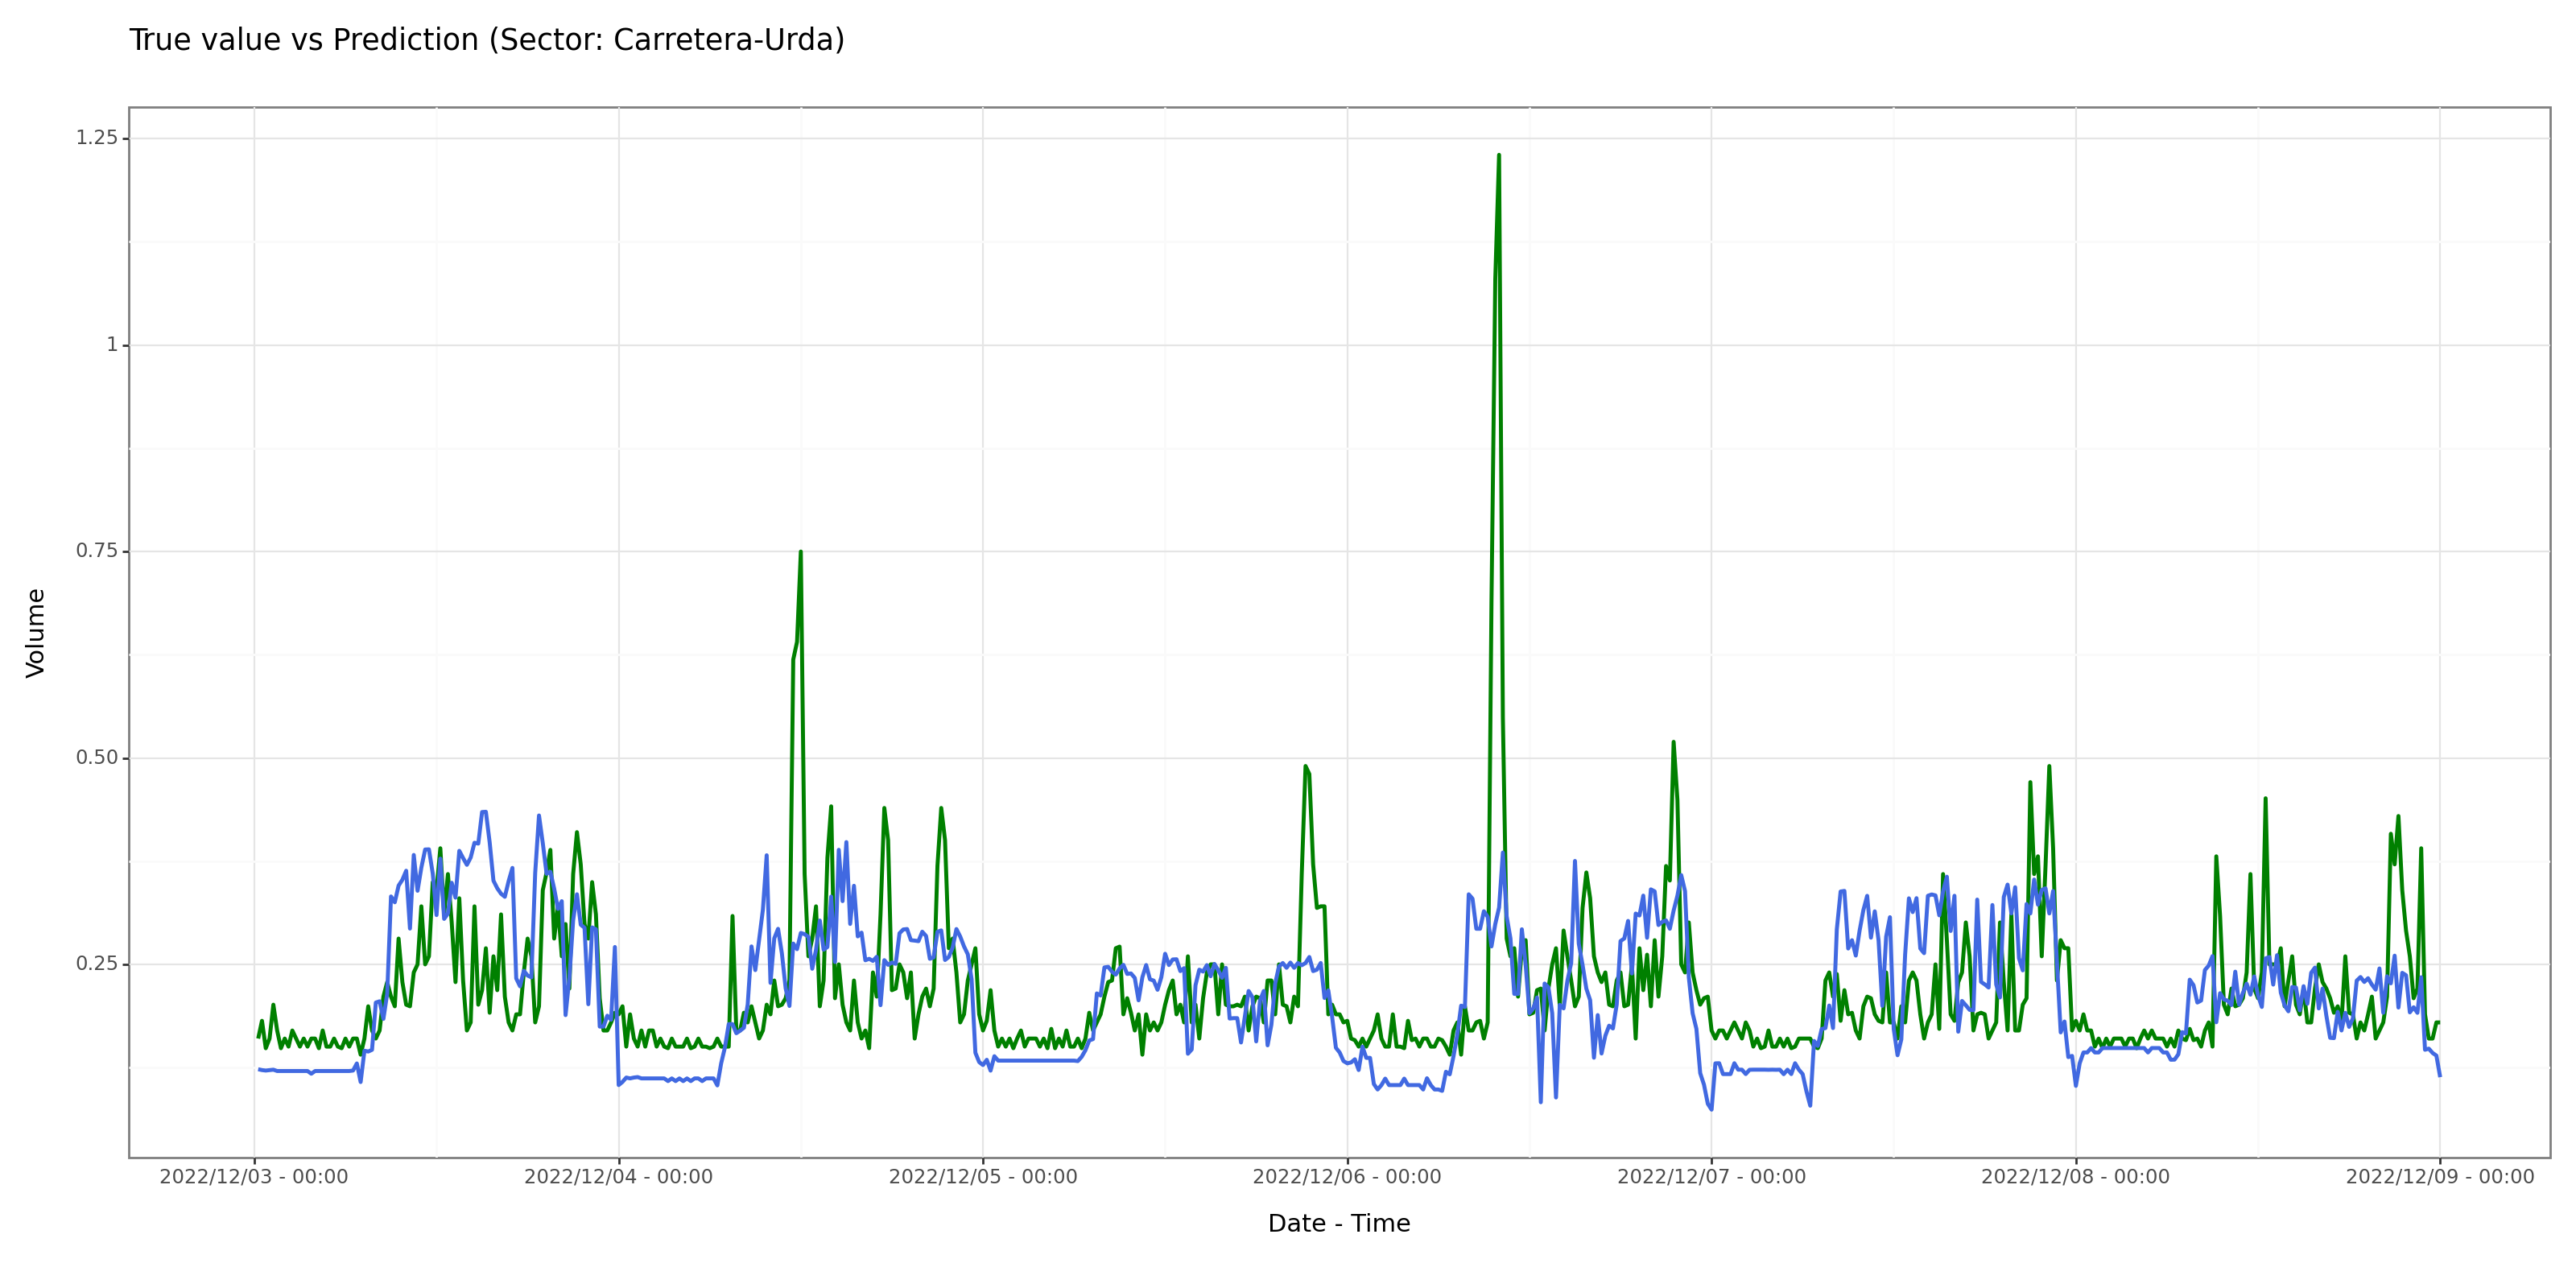

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


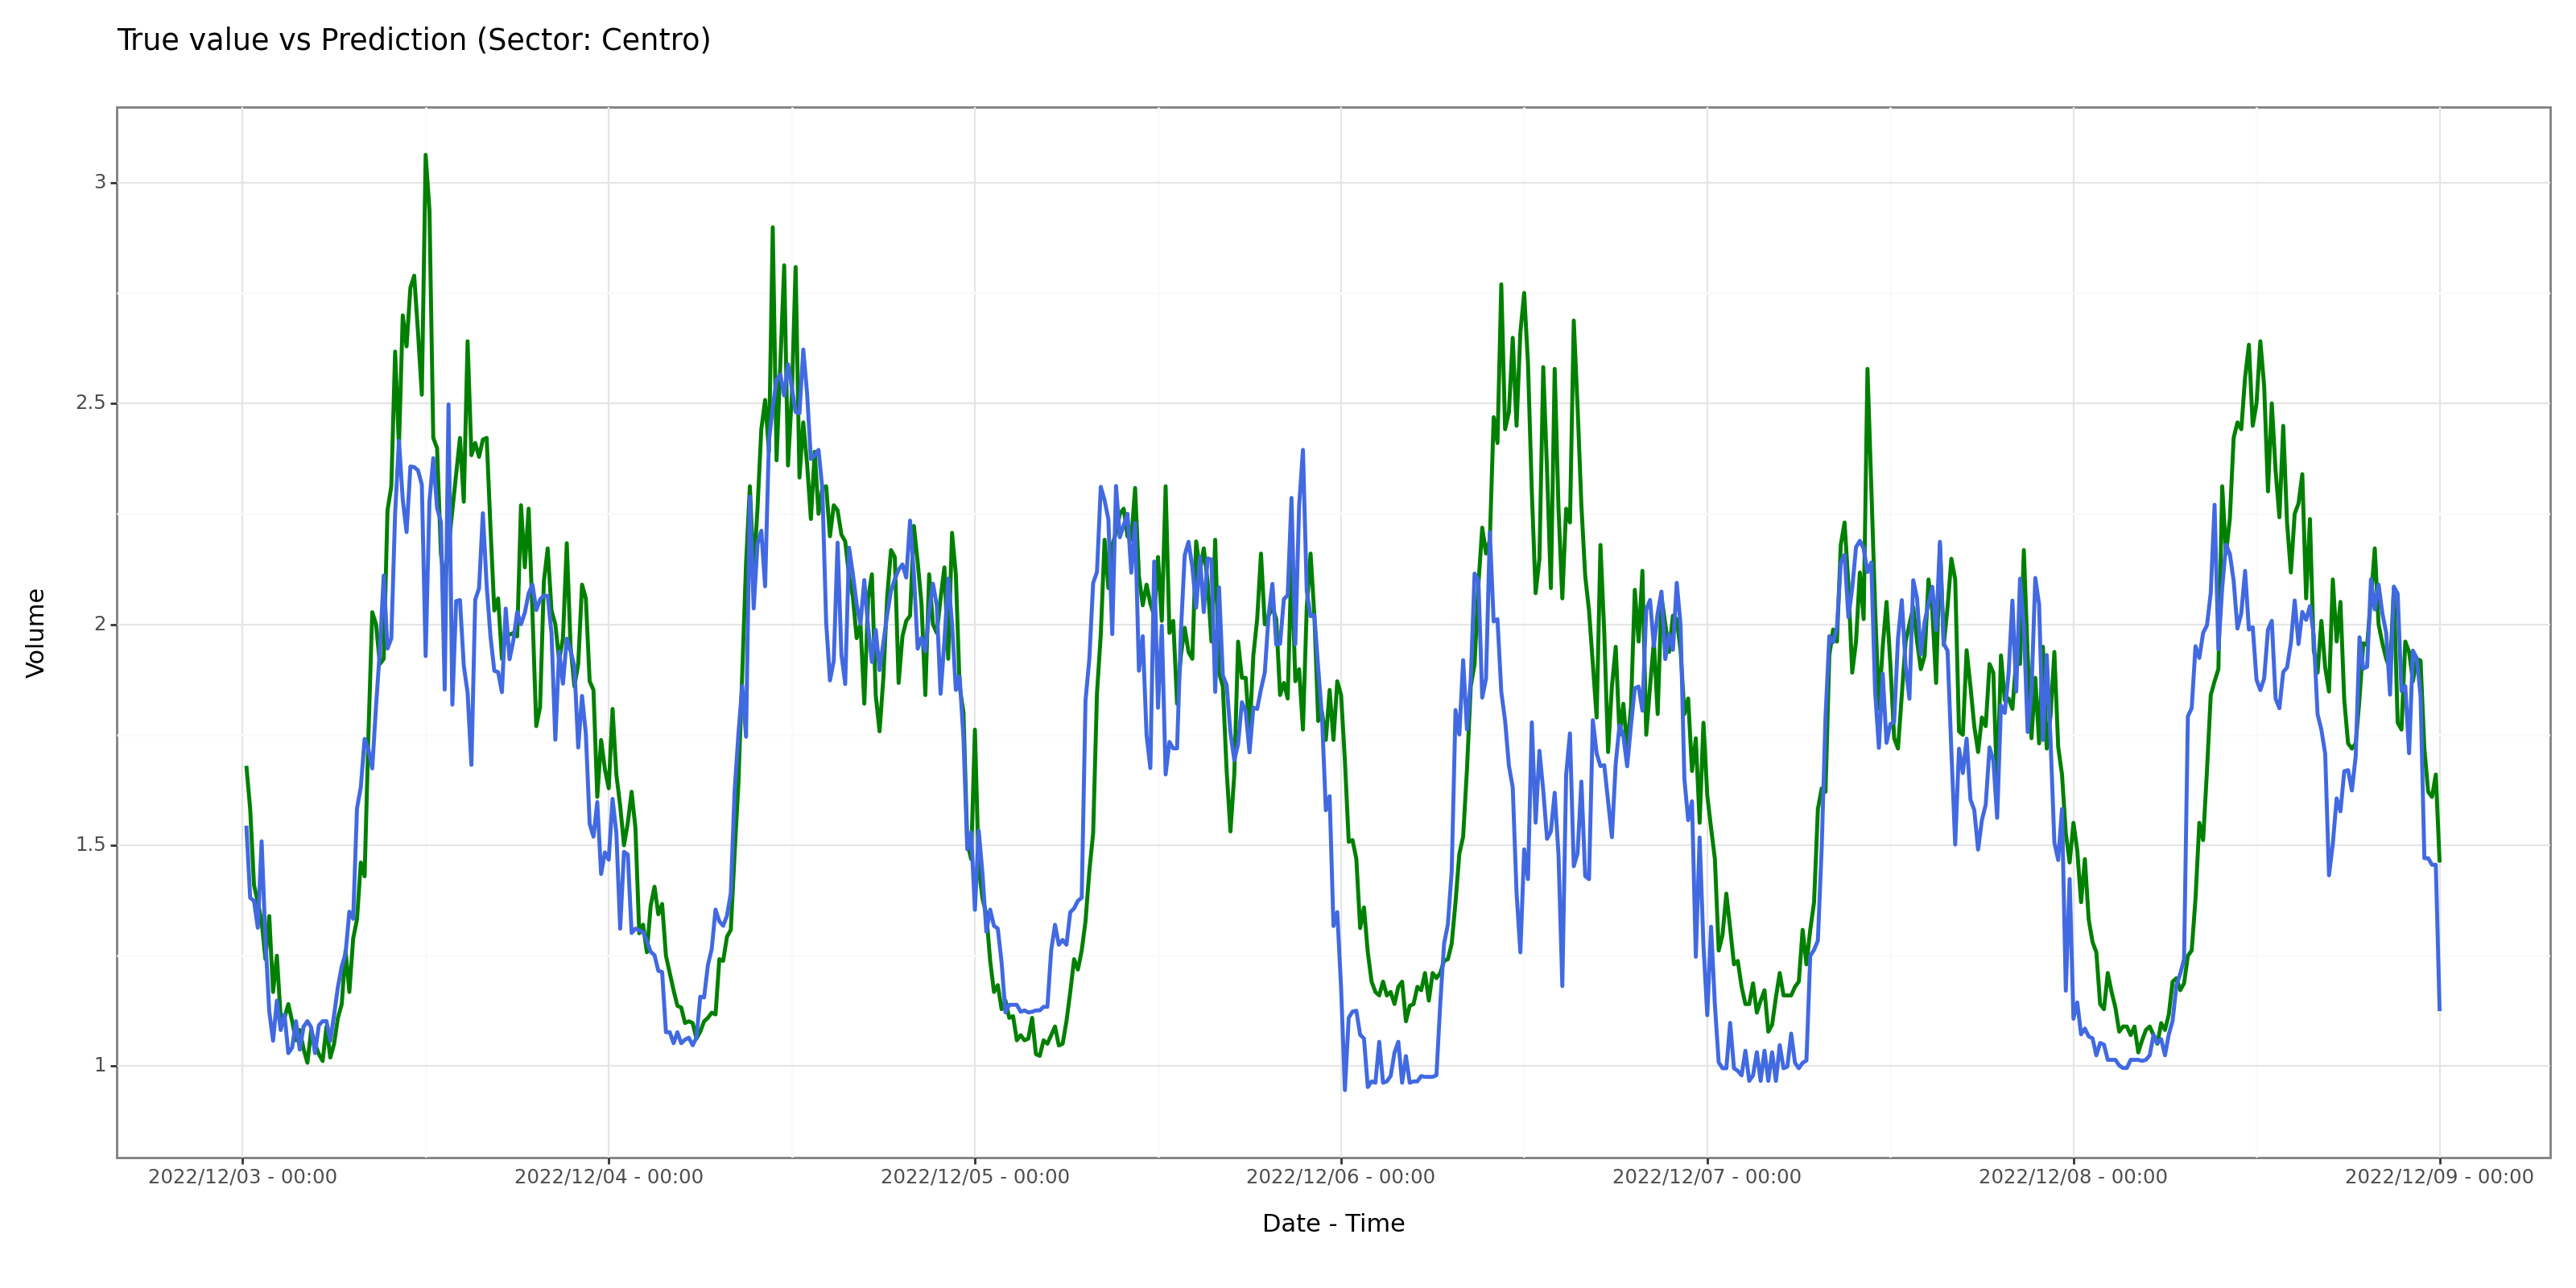

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


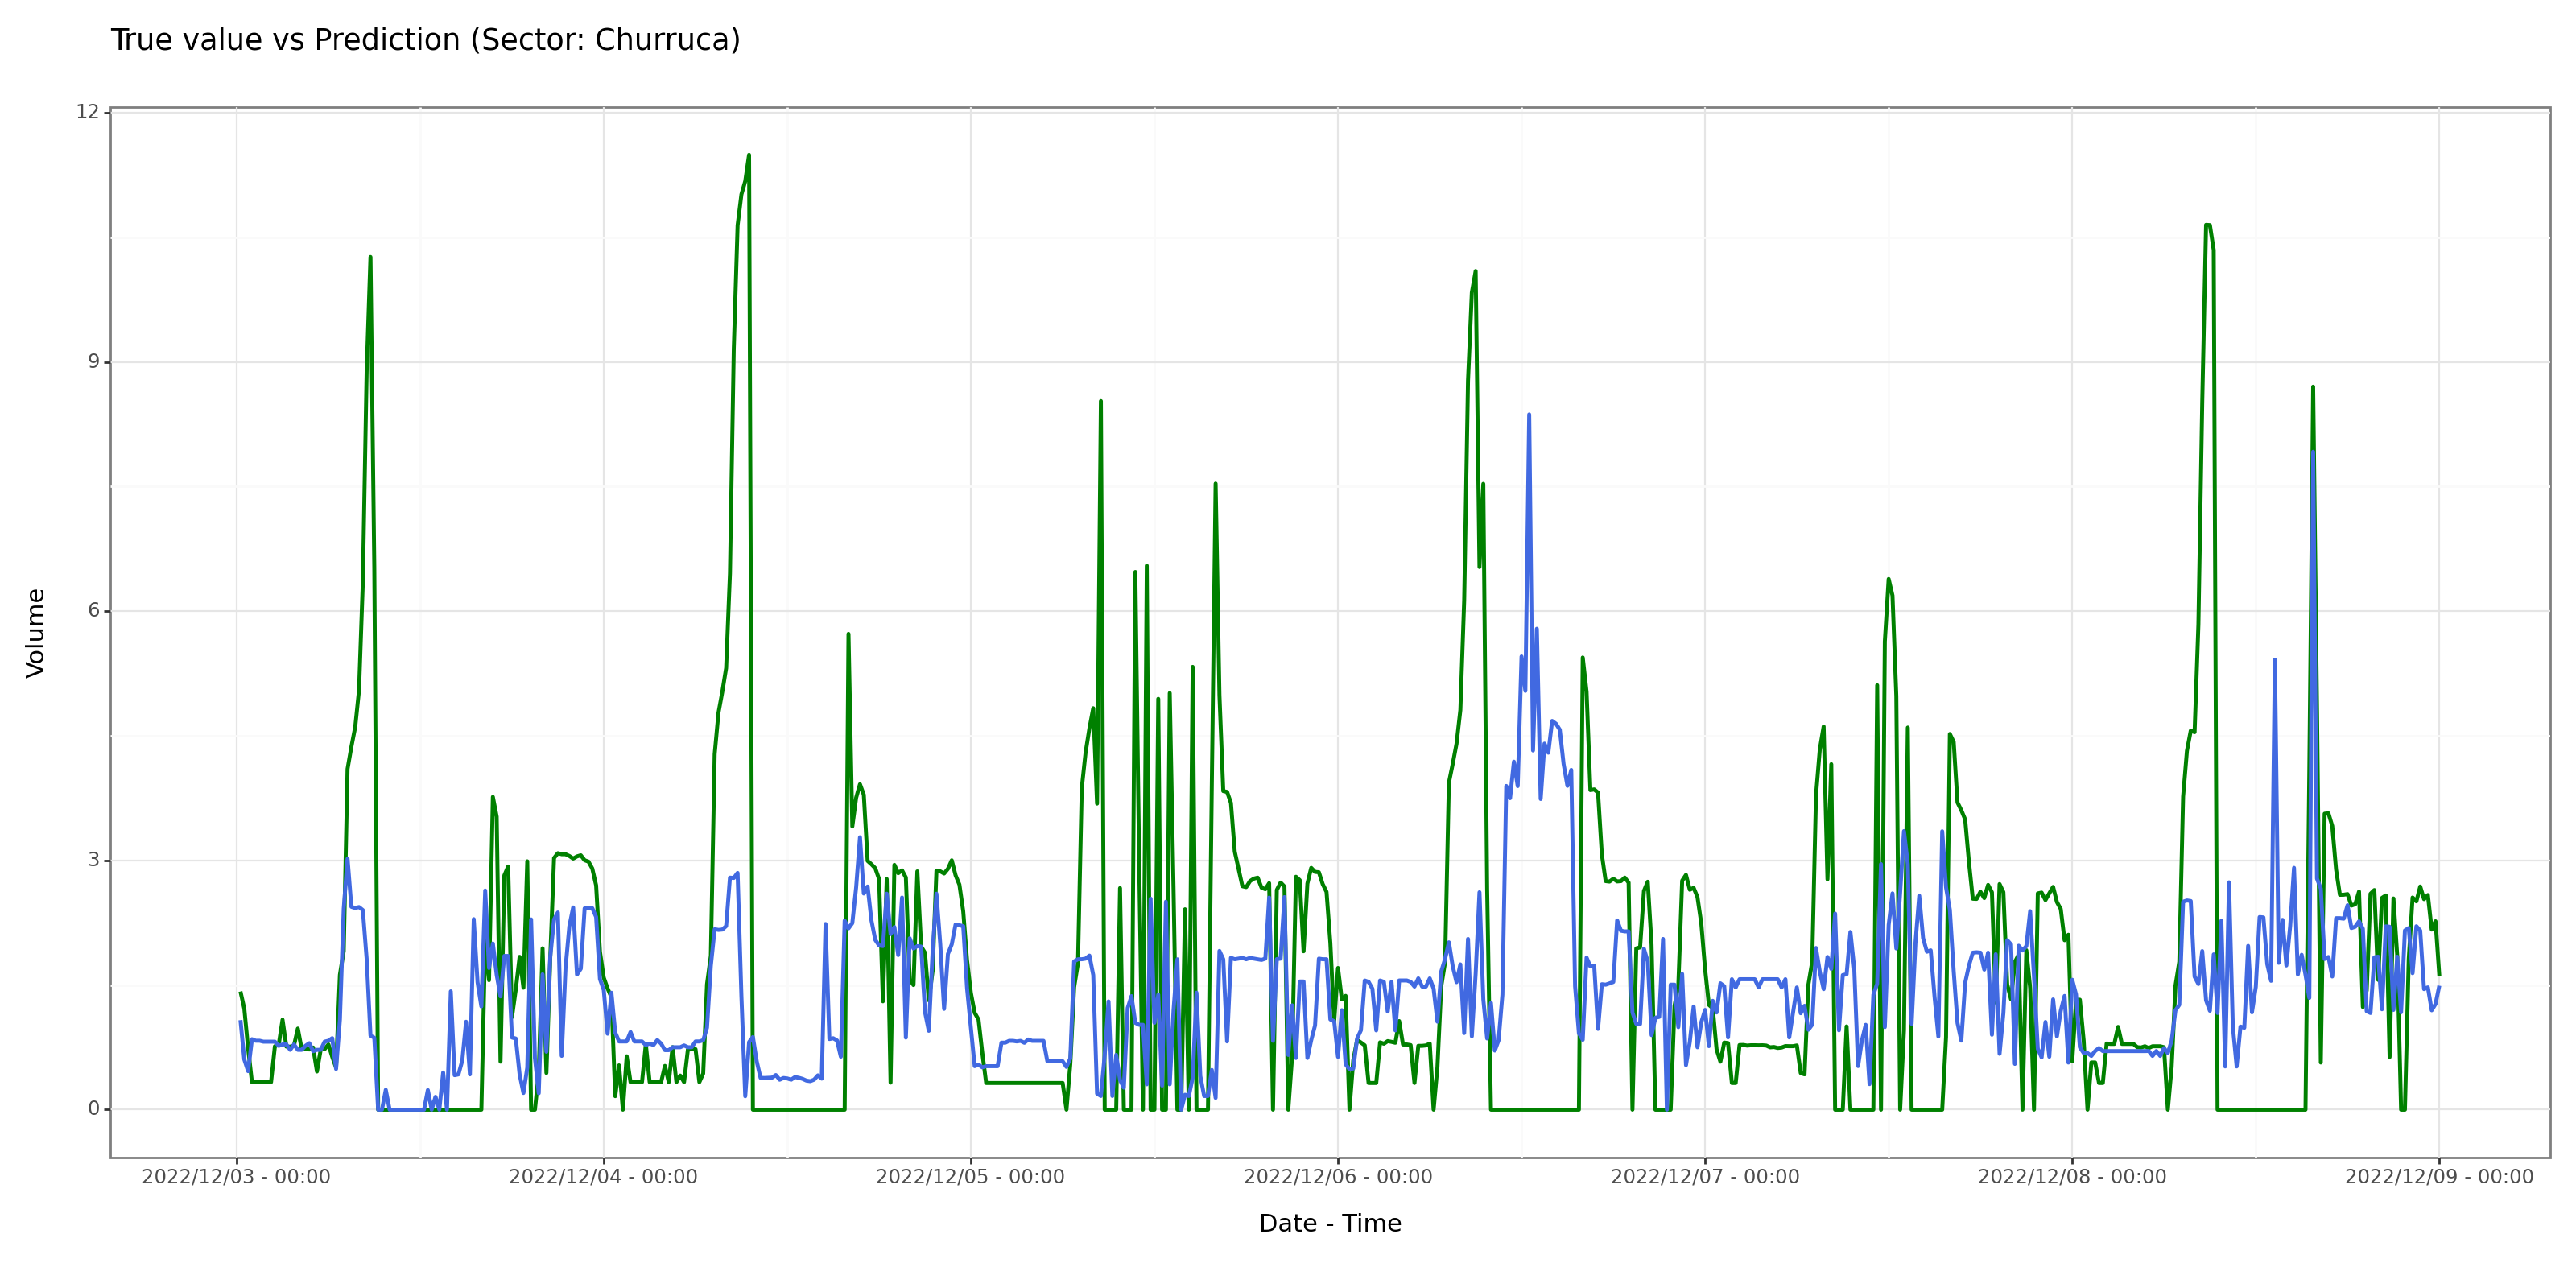

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


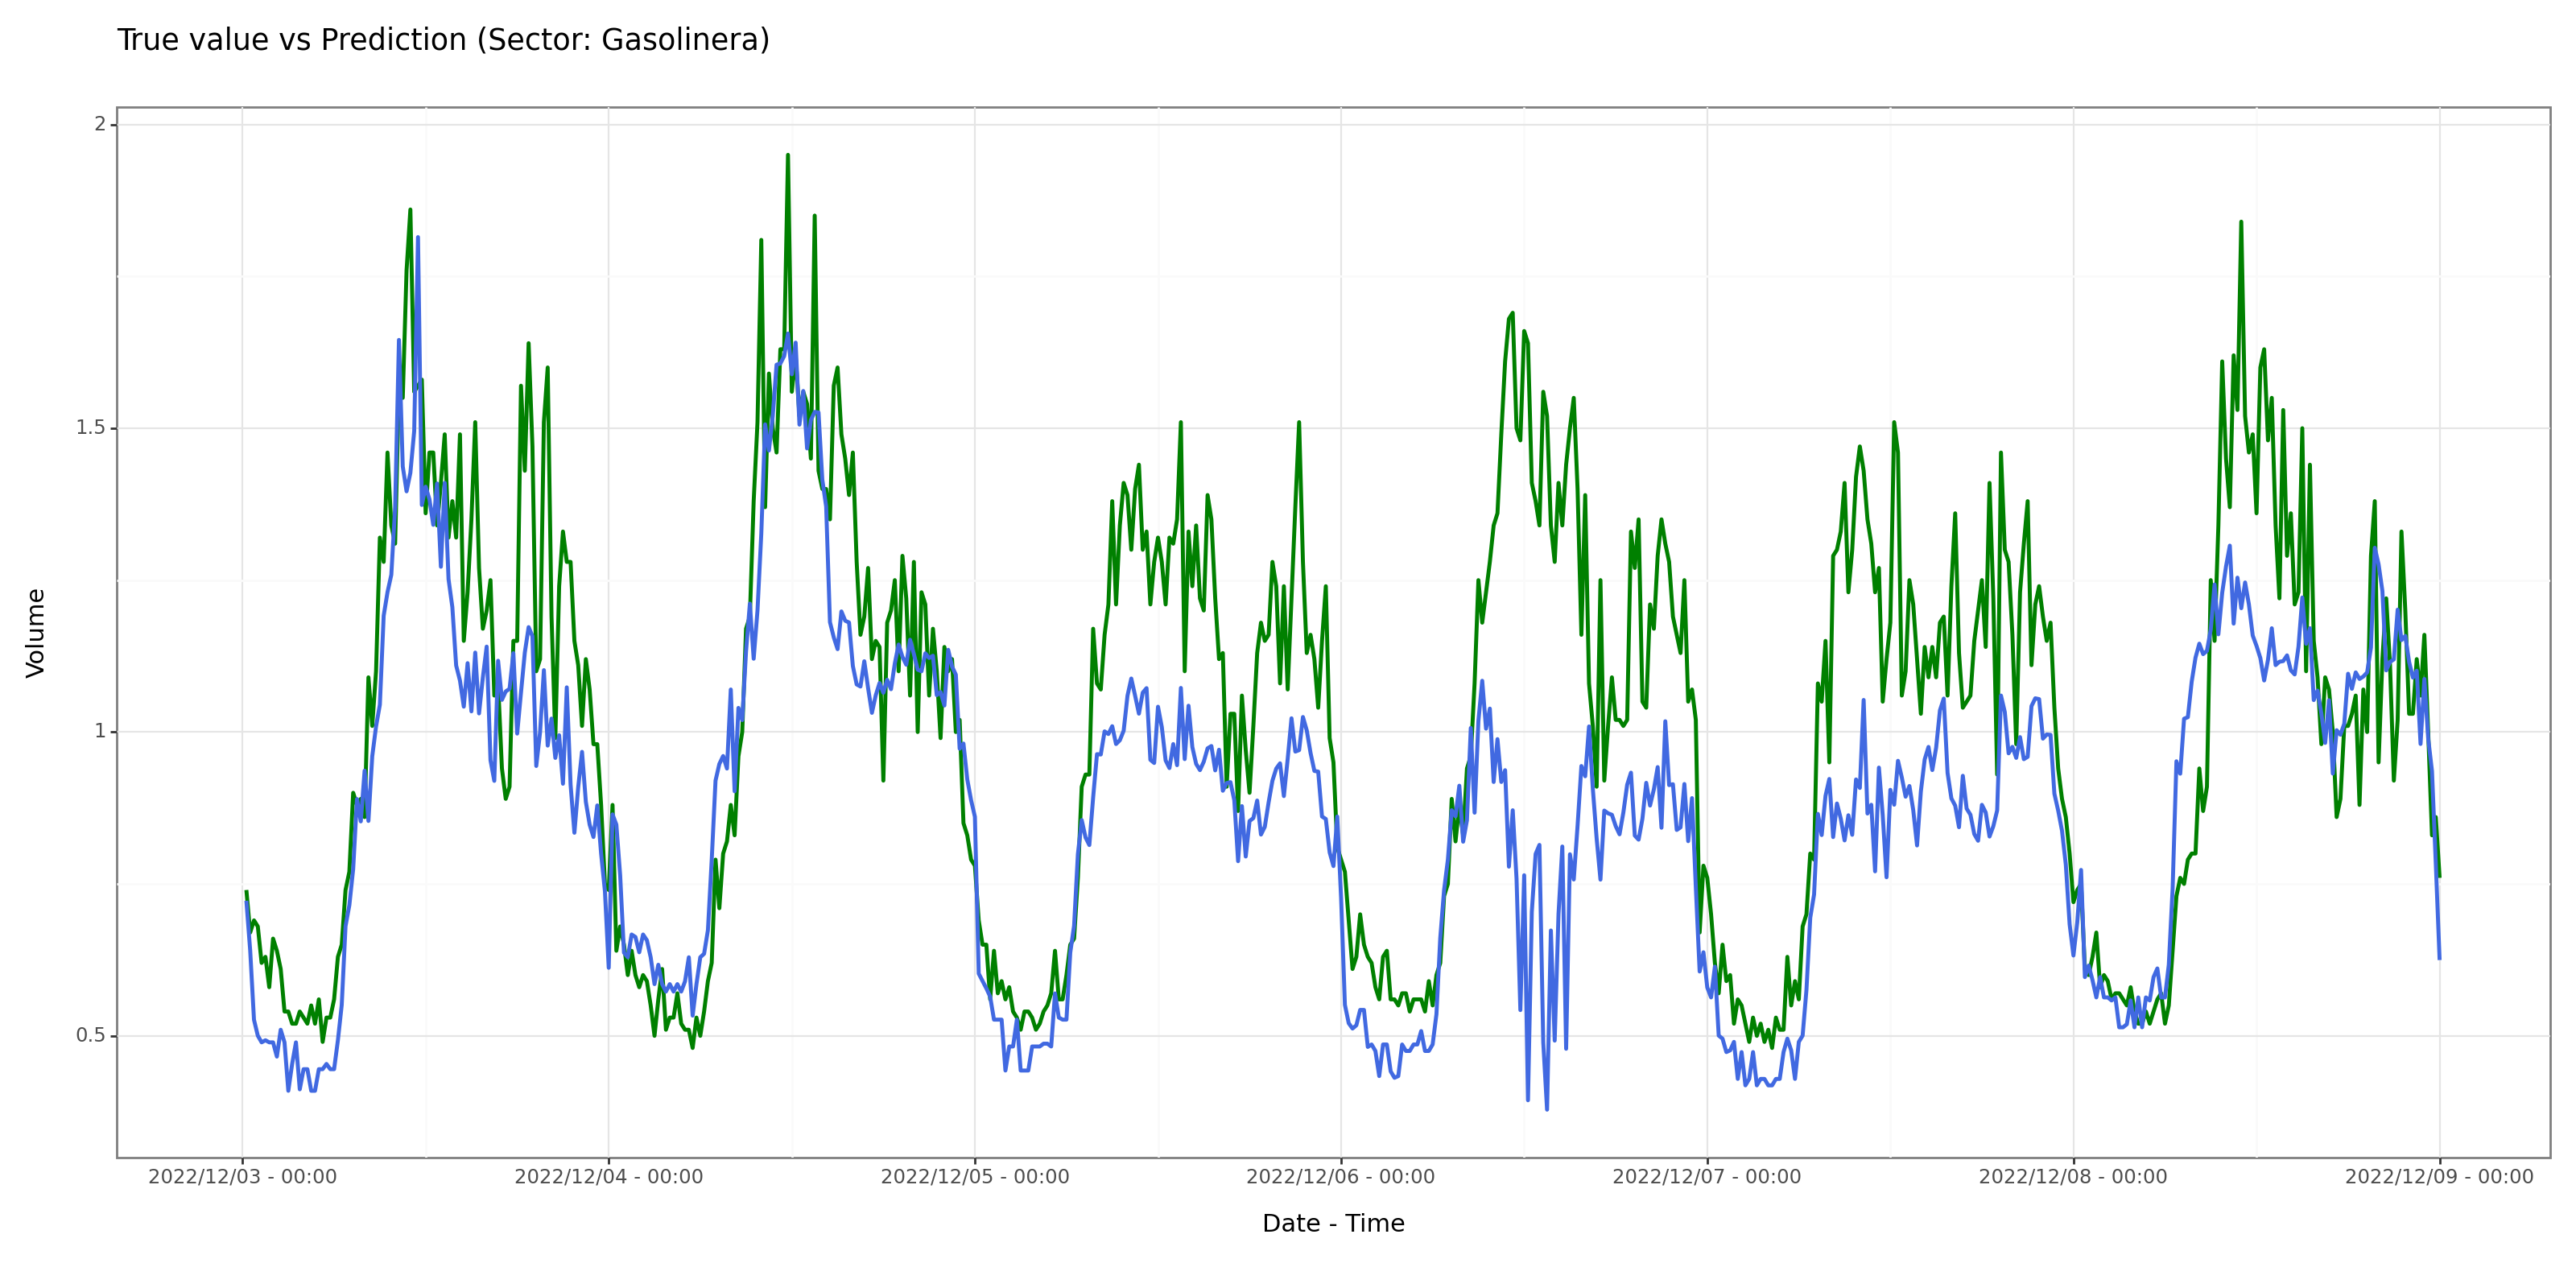

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


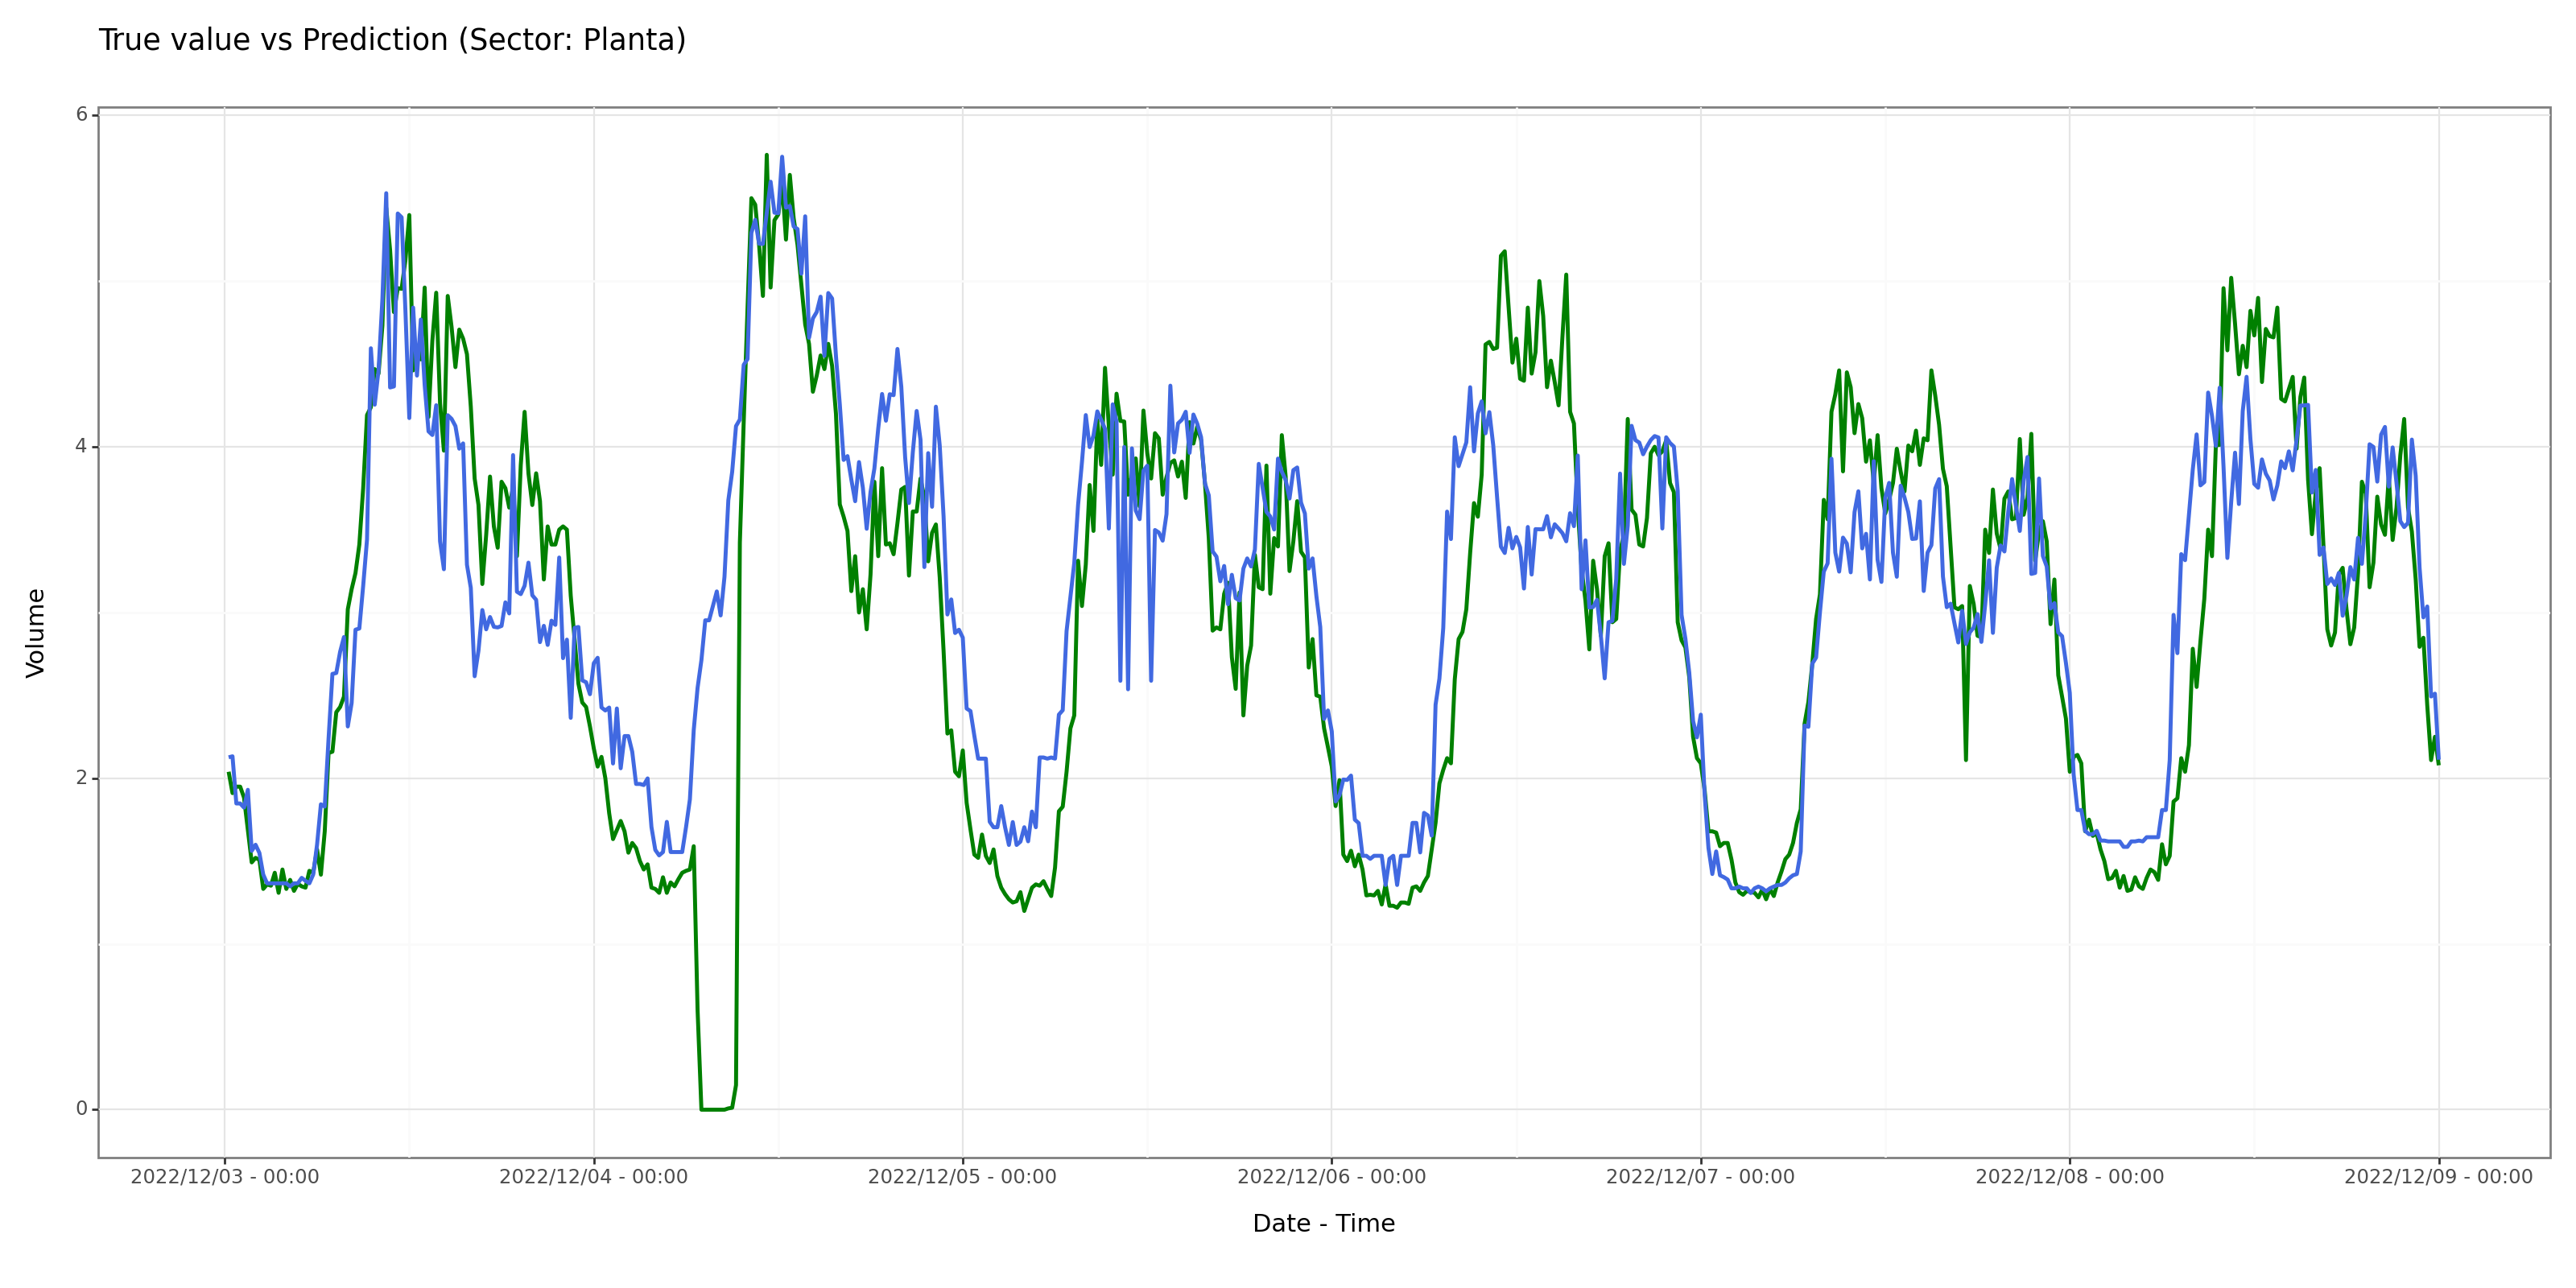

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


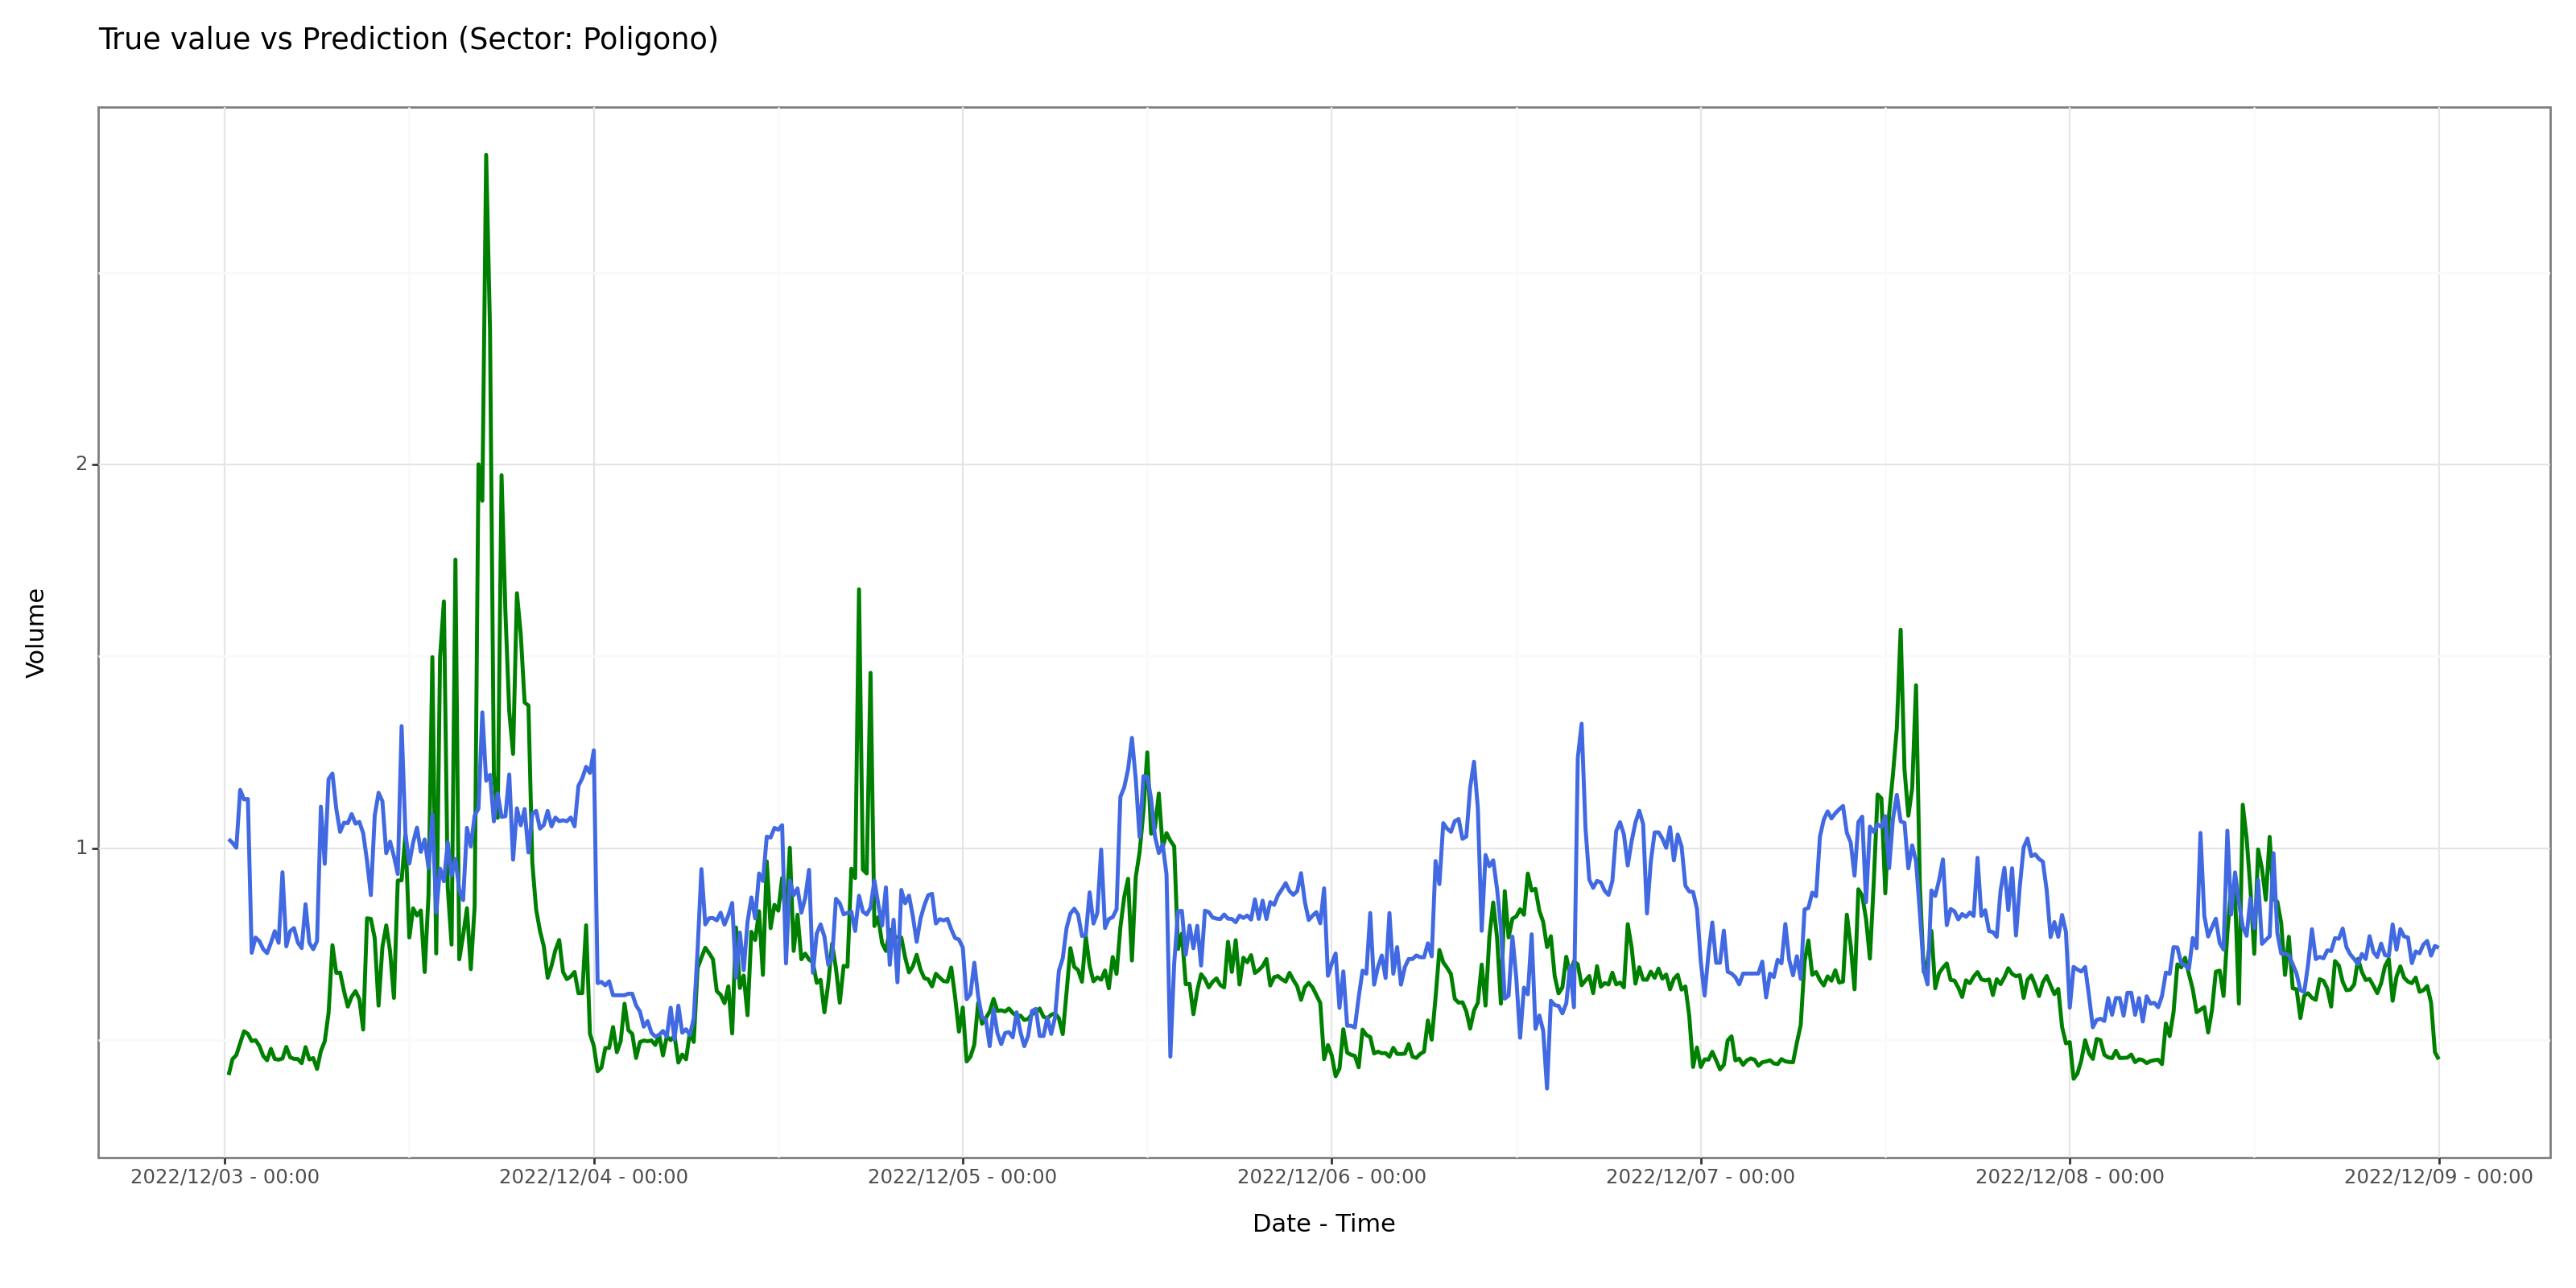

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


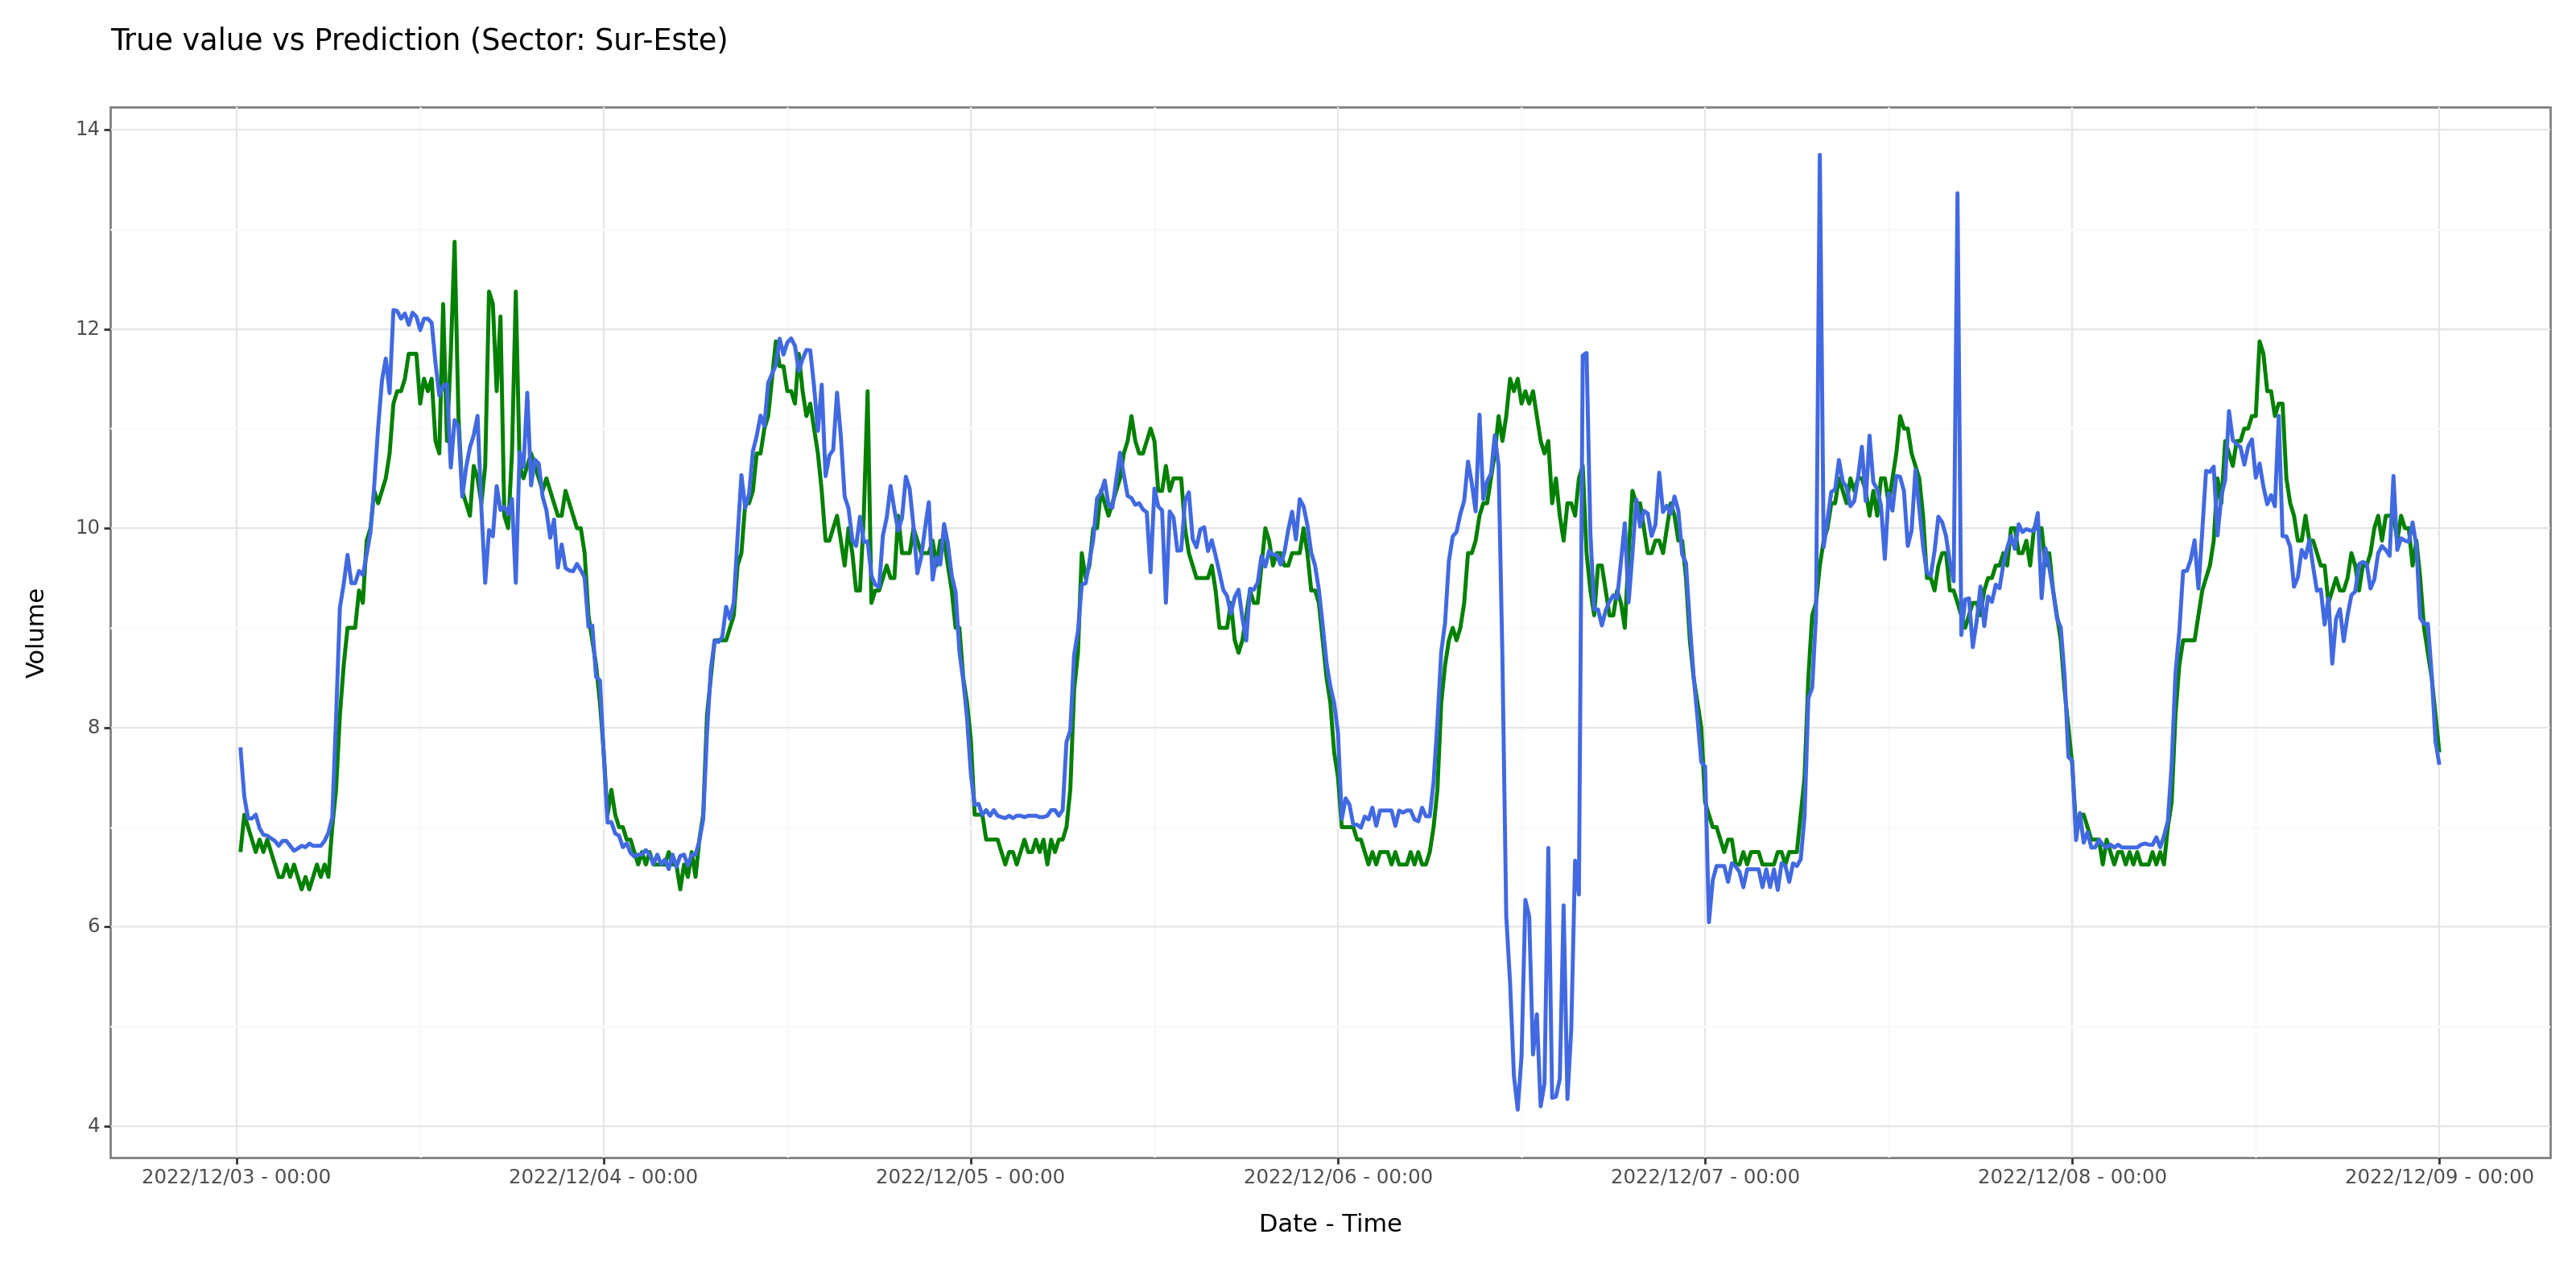

geom_path: Removed 96 rows containing missing values.
geom_path: Removed 96 rows containing missing values.
Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


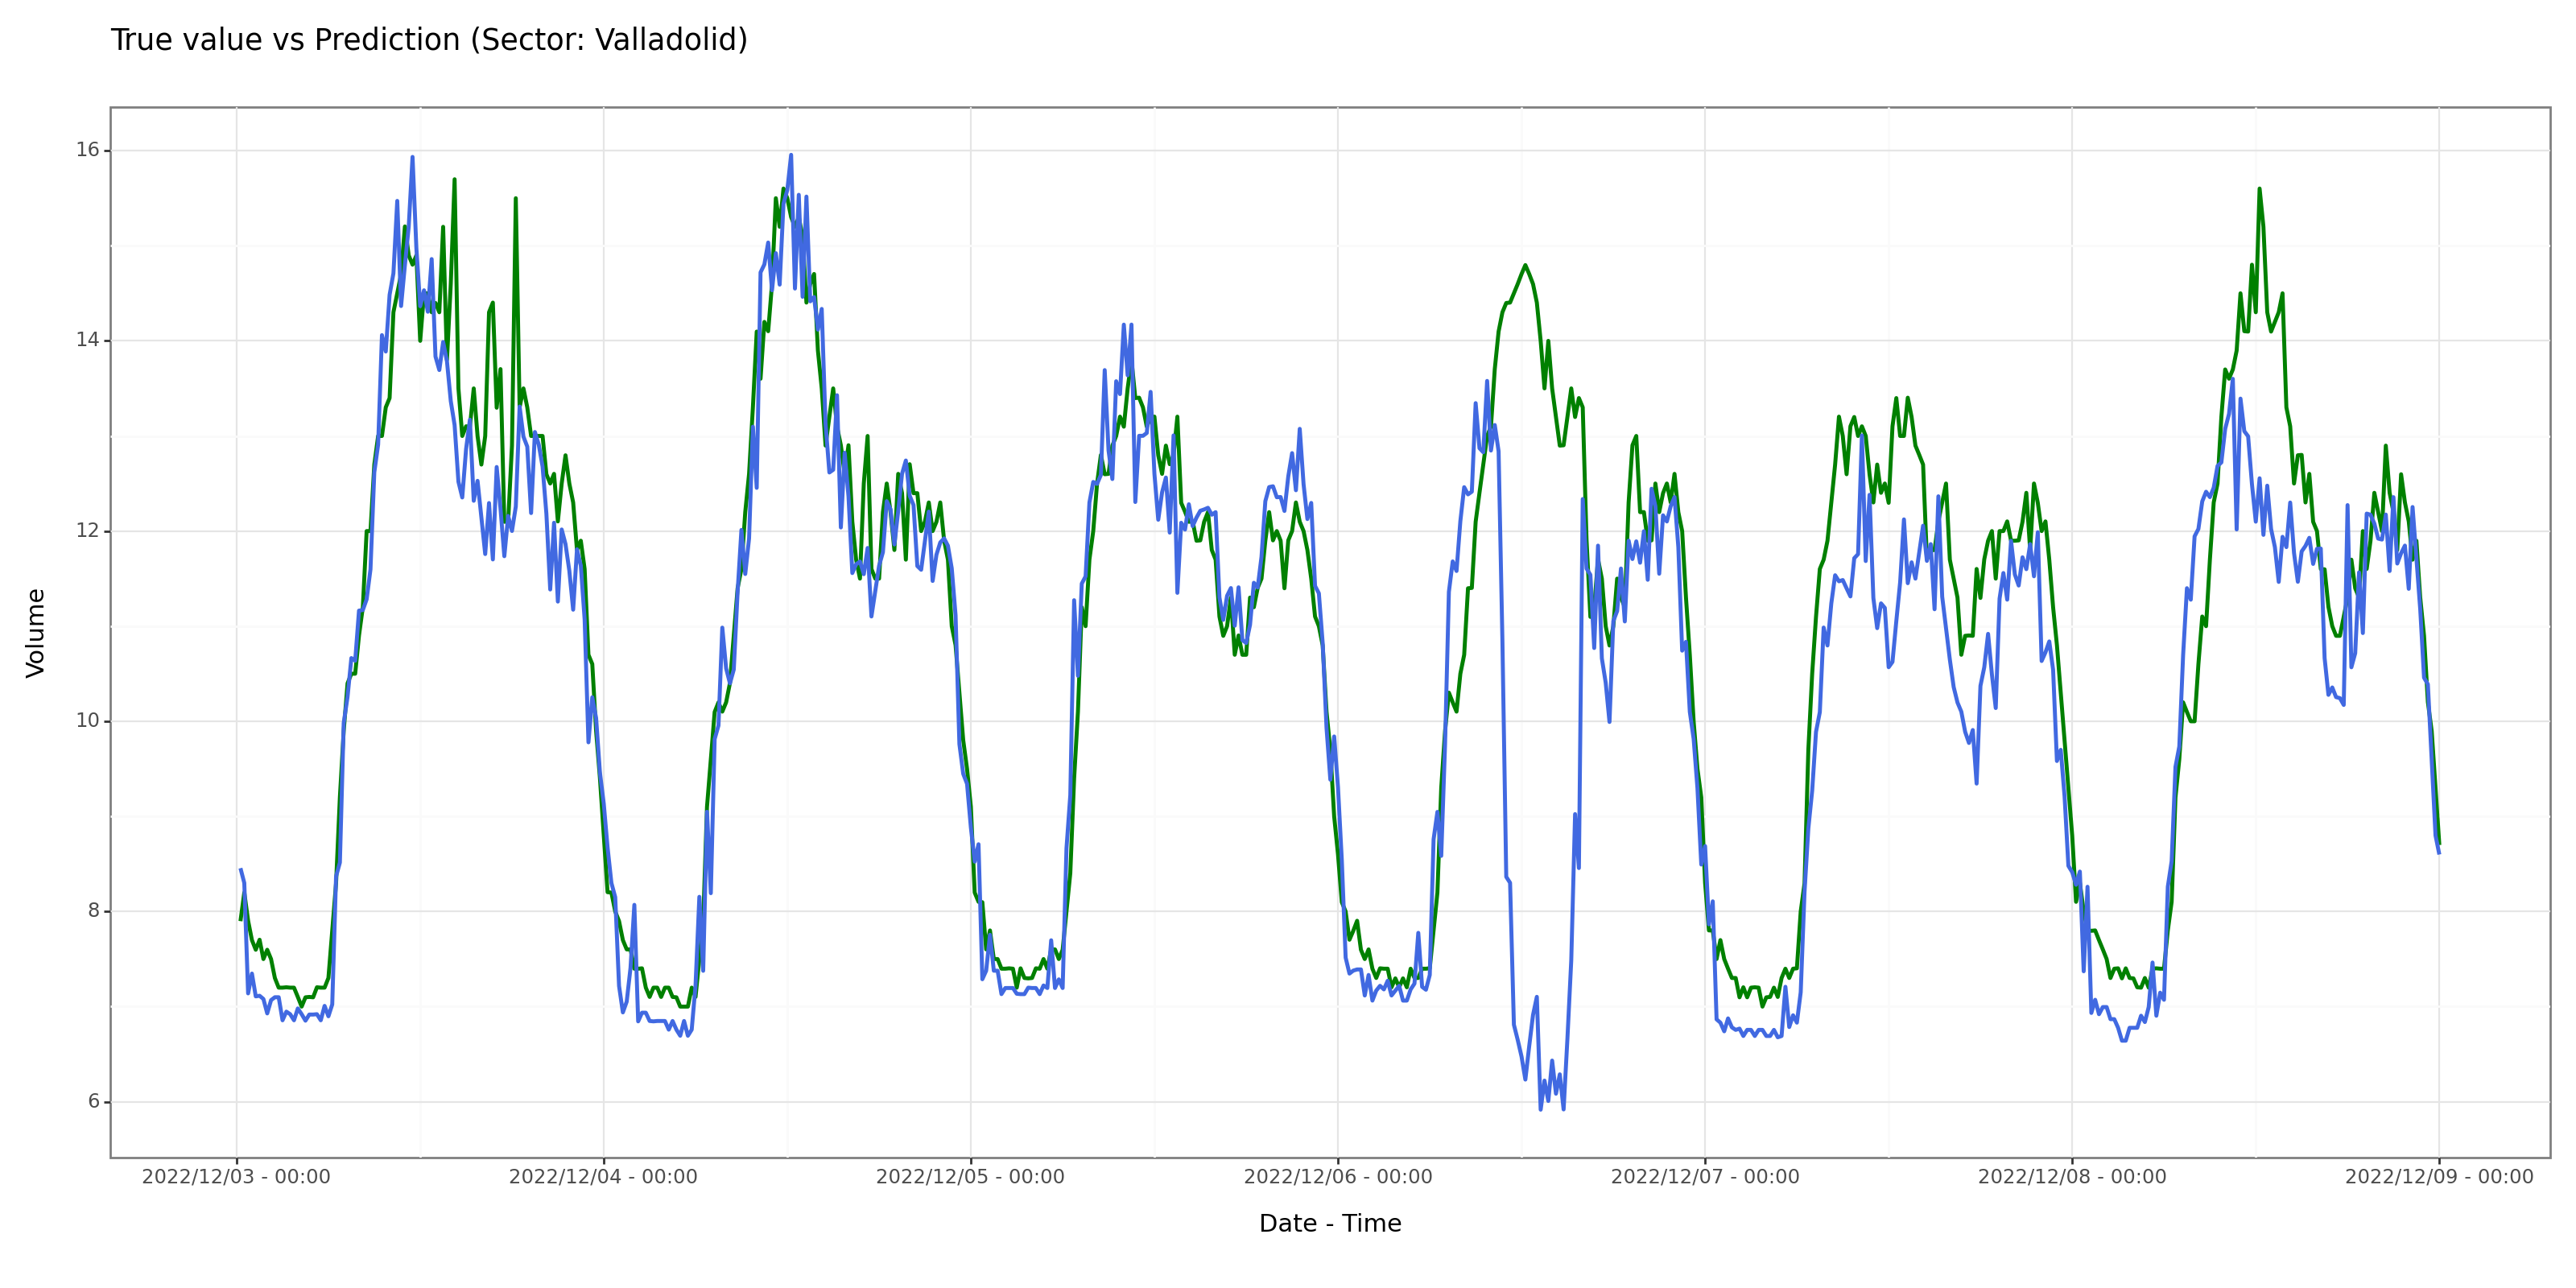

In [ ]:
for i in range(0,8):
  print(g_dict[i])

### Feature importance

In [ ]:
X = df_model[select_vars]
y = df_model[target_cols]
#Xd = xgboost.DMatrix(X, label=y)

In [ ]:
ML_model
#ML_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [ ]:
imp_df

RowKey_Date  N_DiaMes  N_Mes  N_Ano  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  \
0  2022-12-03    0.0180 0.0608 0.0305   0.0269   0.0093   0.0231   0.0582   

   V7_Centro  V7_Churruca  ...  V7_Planta  V7_Sur-Este  V14_Sur-Este  \
0     0.0114       0.3555  ...     0.0361       0.0510        0.0386   

   V7_Valladolid  V14_Valladolid  temp_7  solarenergy_7  mint_7  dew_7  \
0         0.1304          0.0083  0.0160         0.0087  0.0081 0.0076   

   precipcover_7  
0         0.0069  

[1 rows x 23 columns]

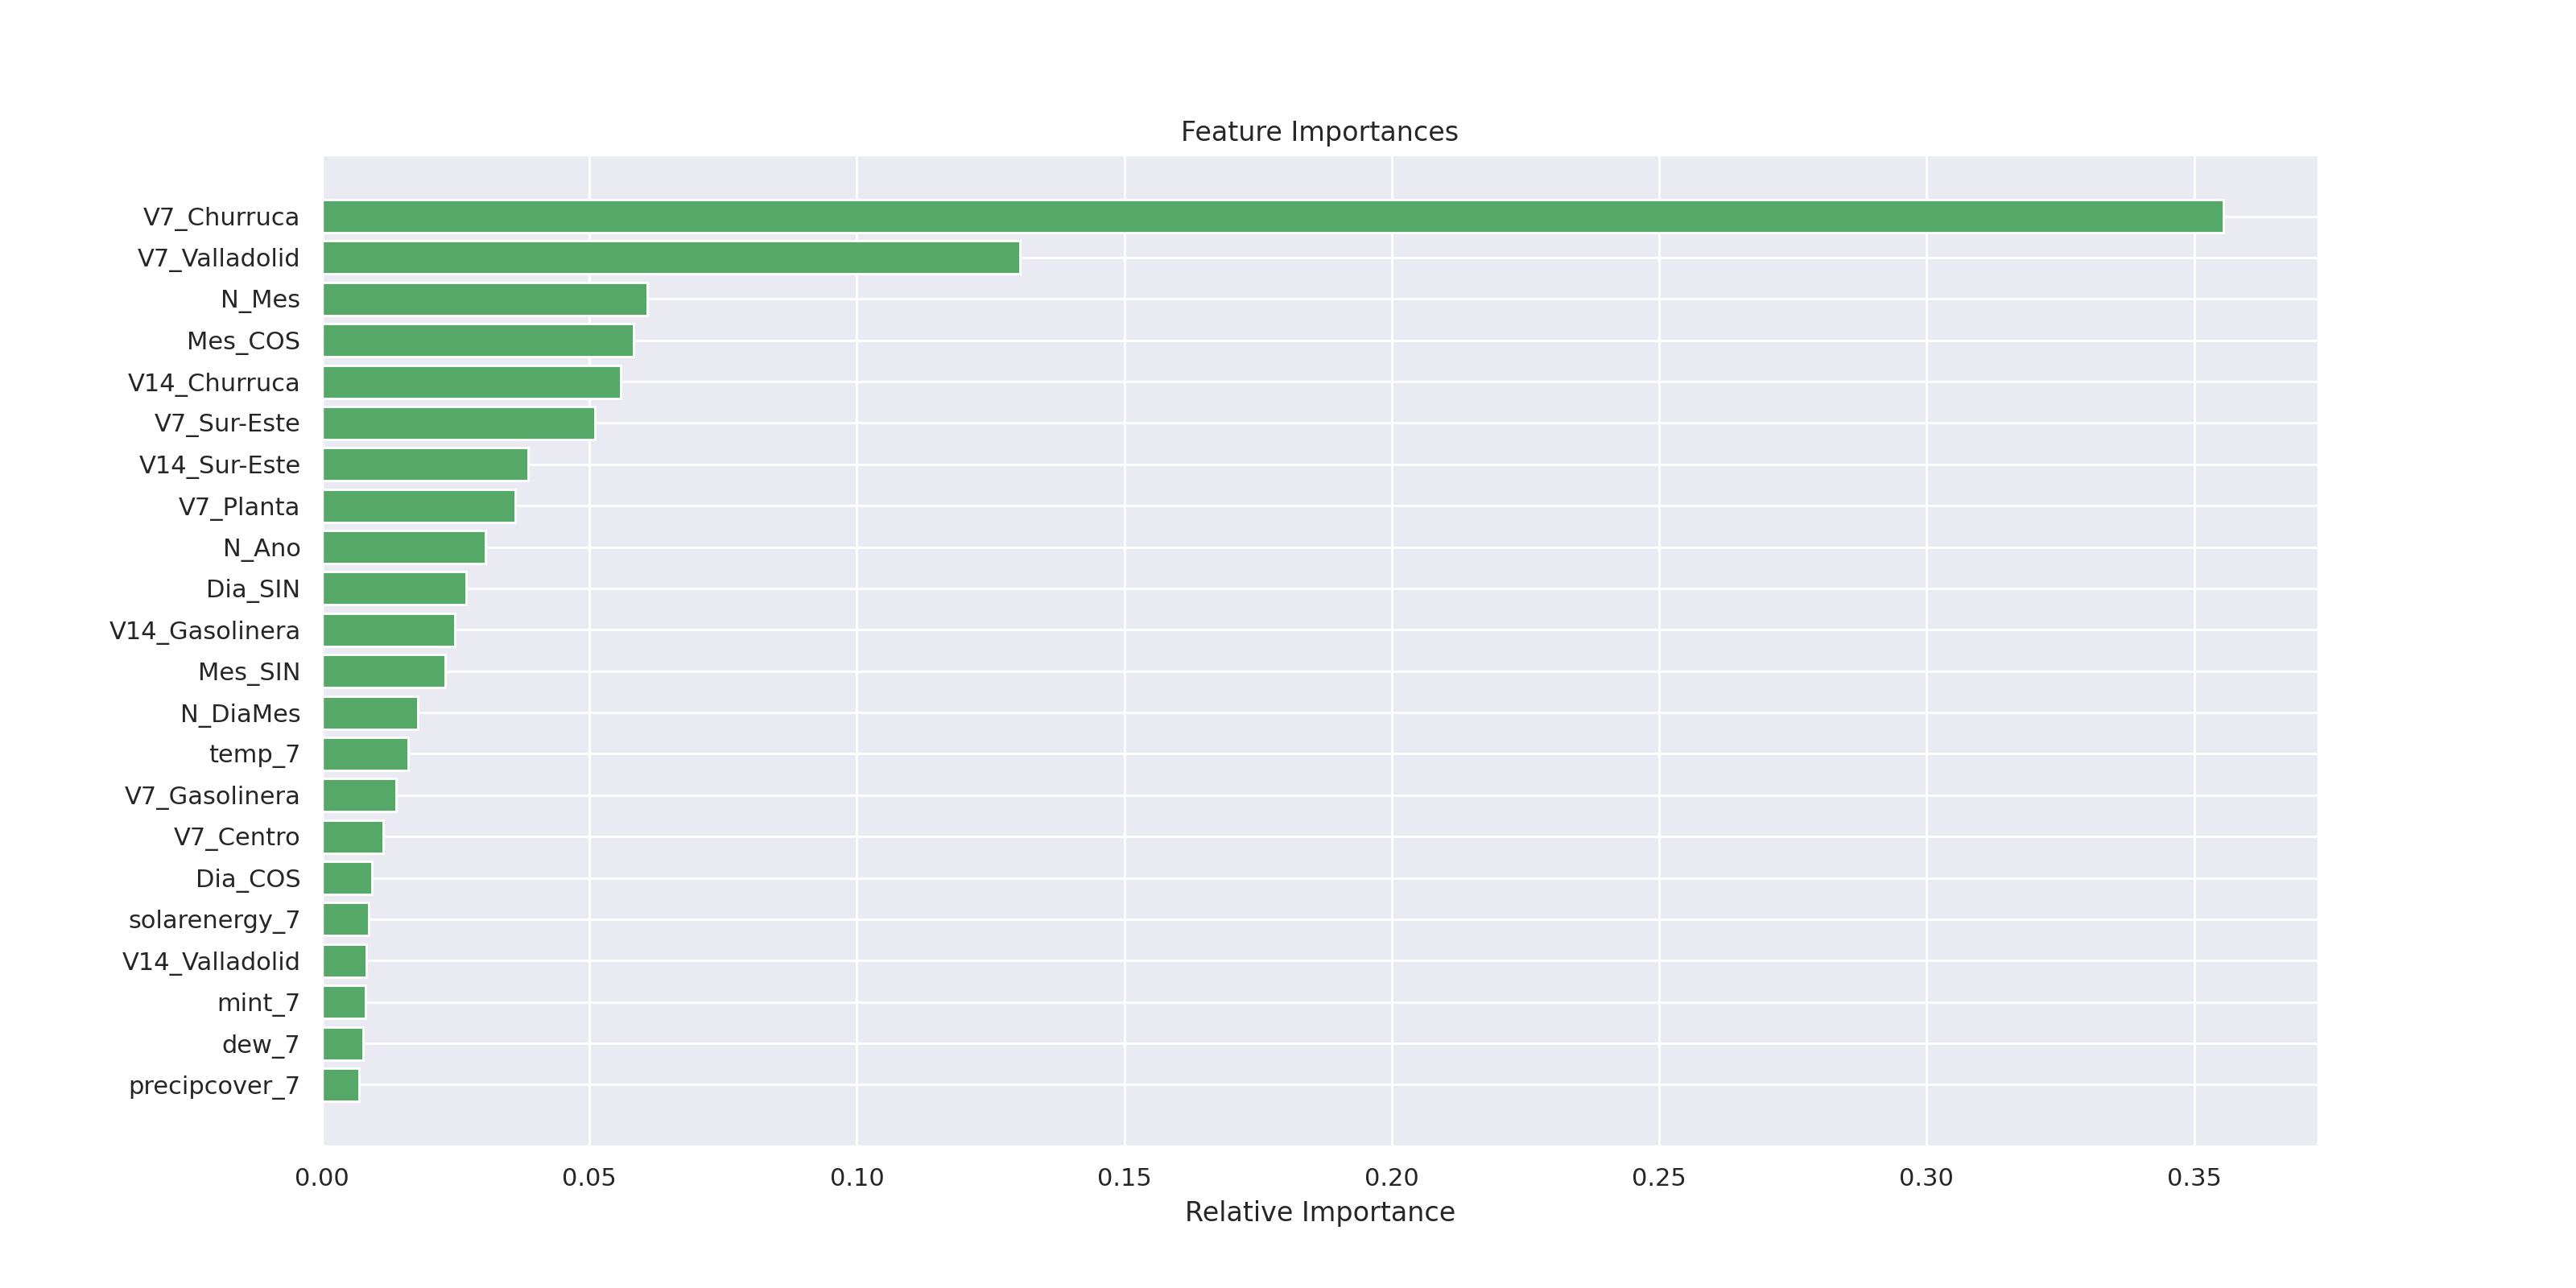

In [ ]:
importances = ML_model.feature_importances_
indices = np.argsort(importances)
features = select_vars
plt.figure(figsize=(16,8), dpi=100)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# compute SHAP values
explainer = shap.TreeExplainer(ML_model)
shap_values = explainer.shap_values(X)

[12:19:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


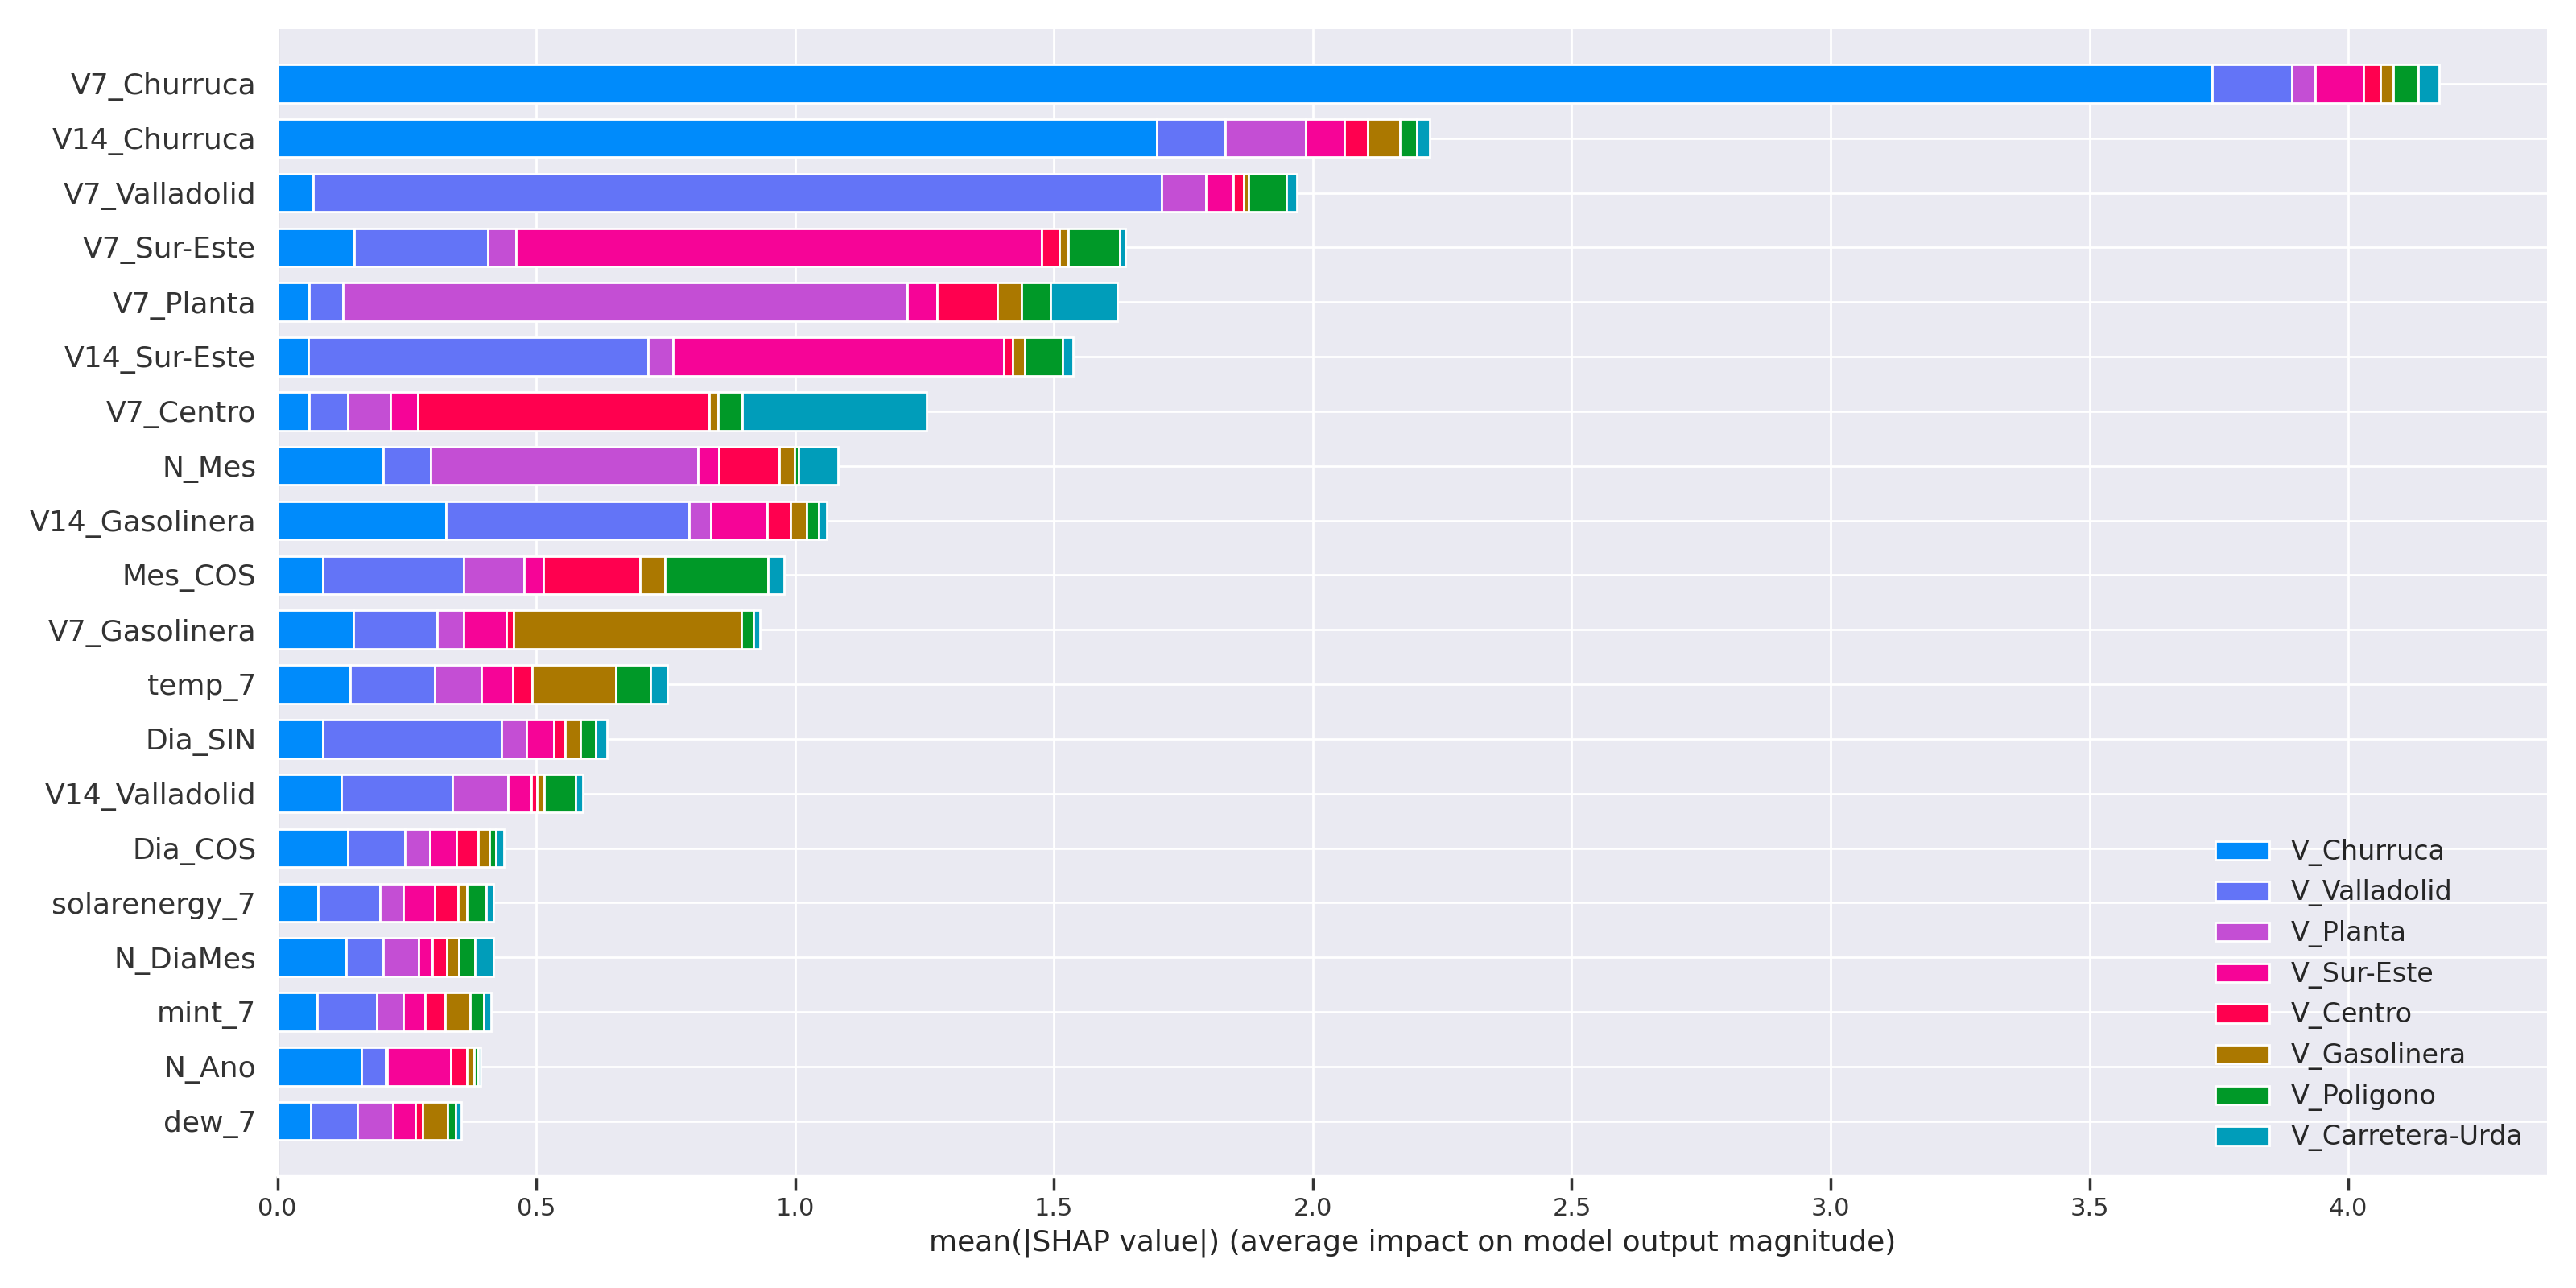

In [ ]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names=target_cols, feature_names=X.columns, plot_size=[16,8], title='Feature Importance')

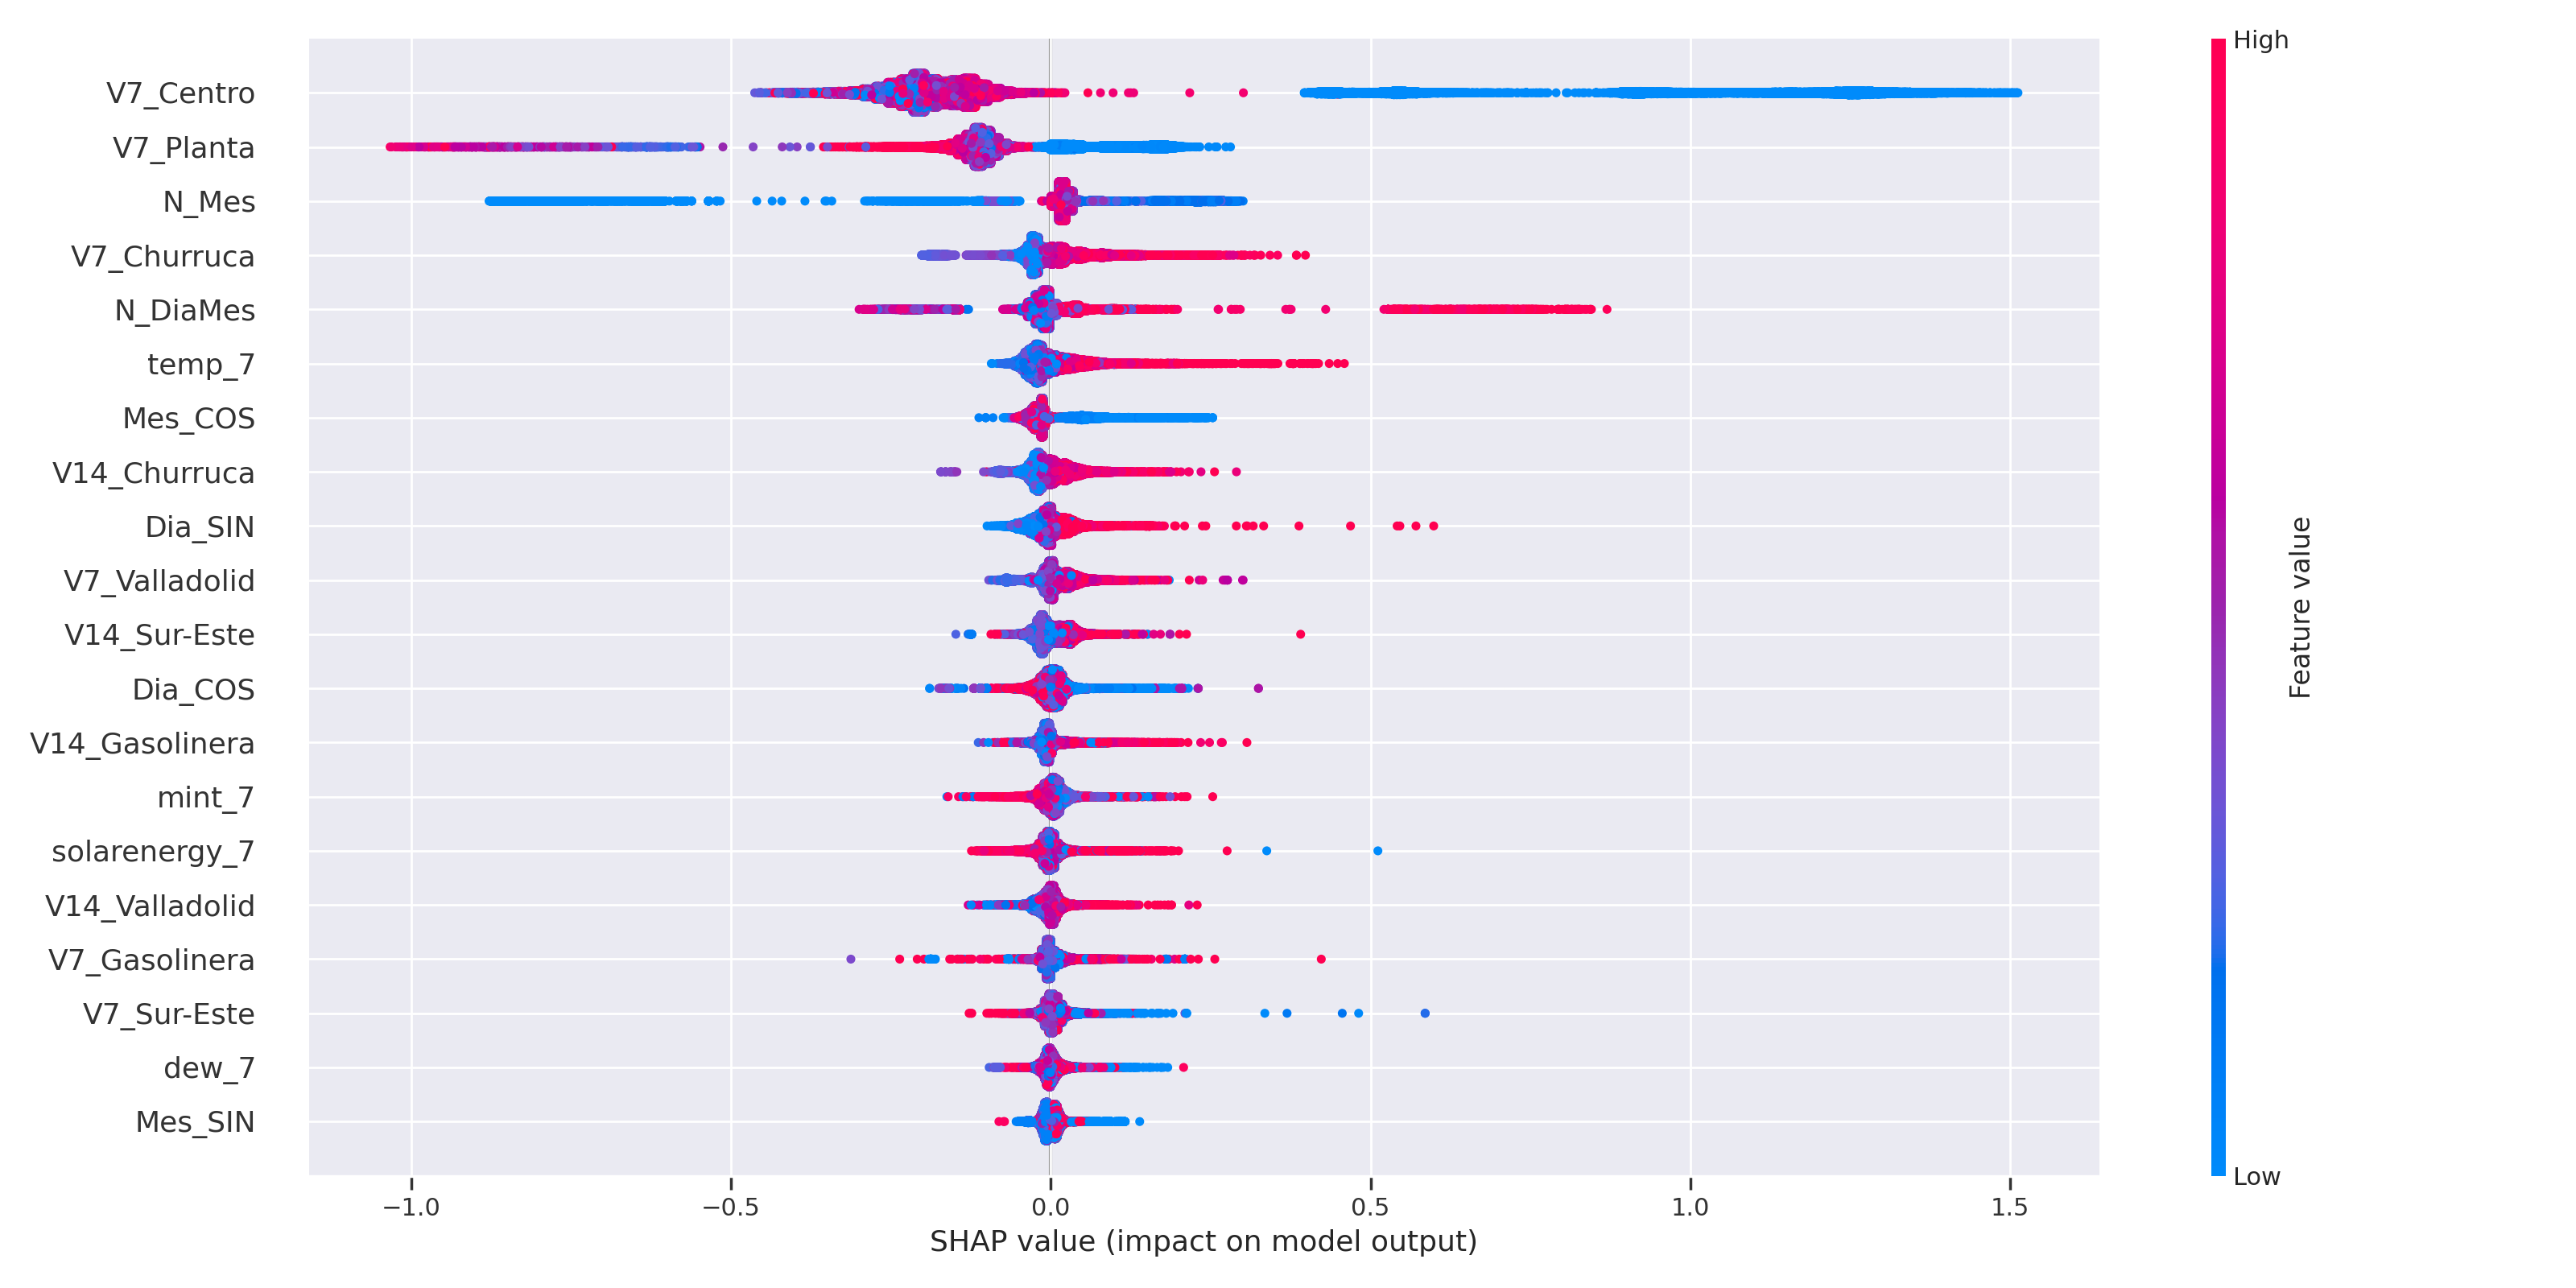

In [ ]:
shap.summary_plot(shap_values[0], X.values, feature_names = X.columns, plot_size=[16,8])

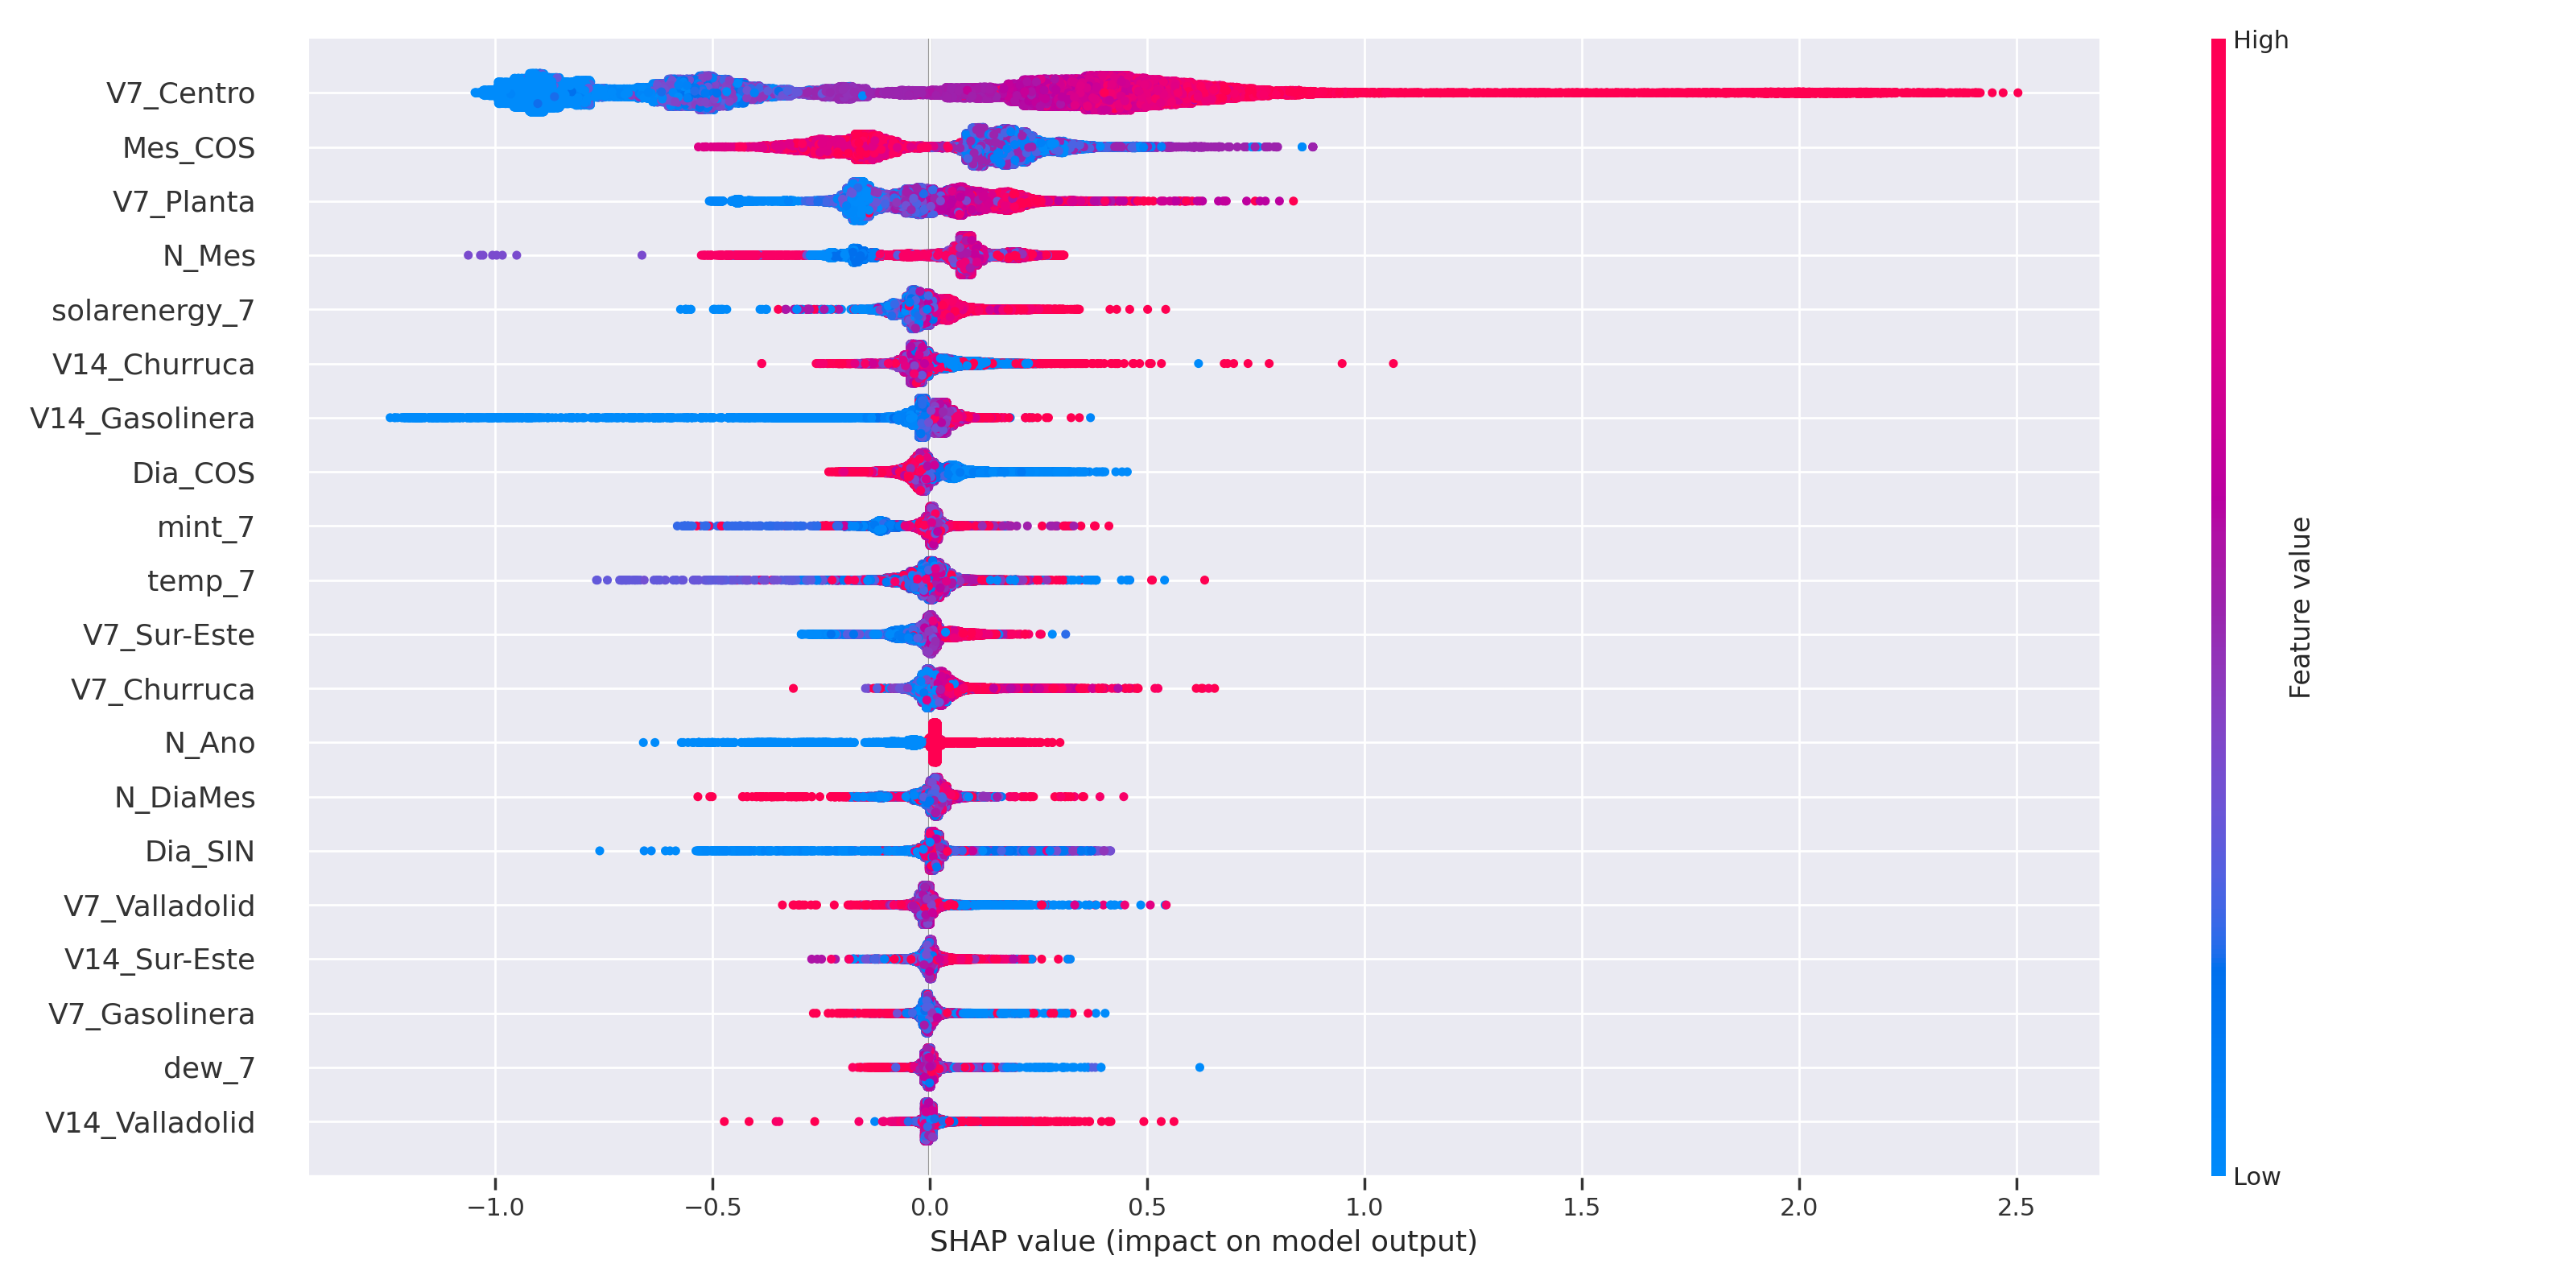

In [ ]:
shap.summary_plot(shap_values[1], X.values, feature_names=X.columns, plot_size=[16,8])

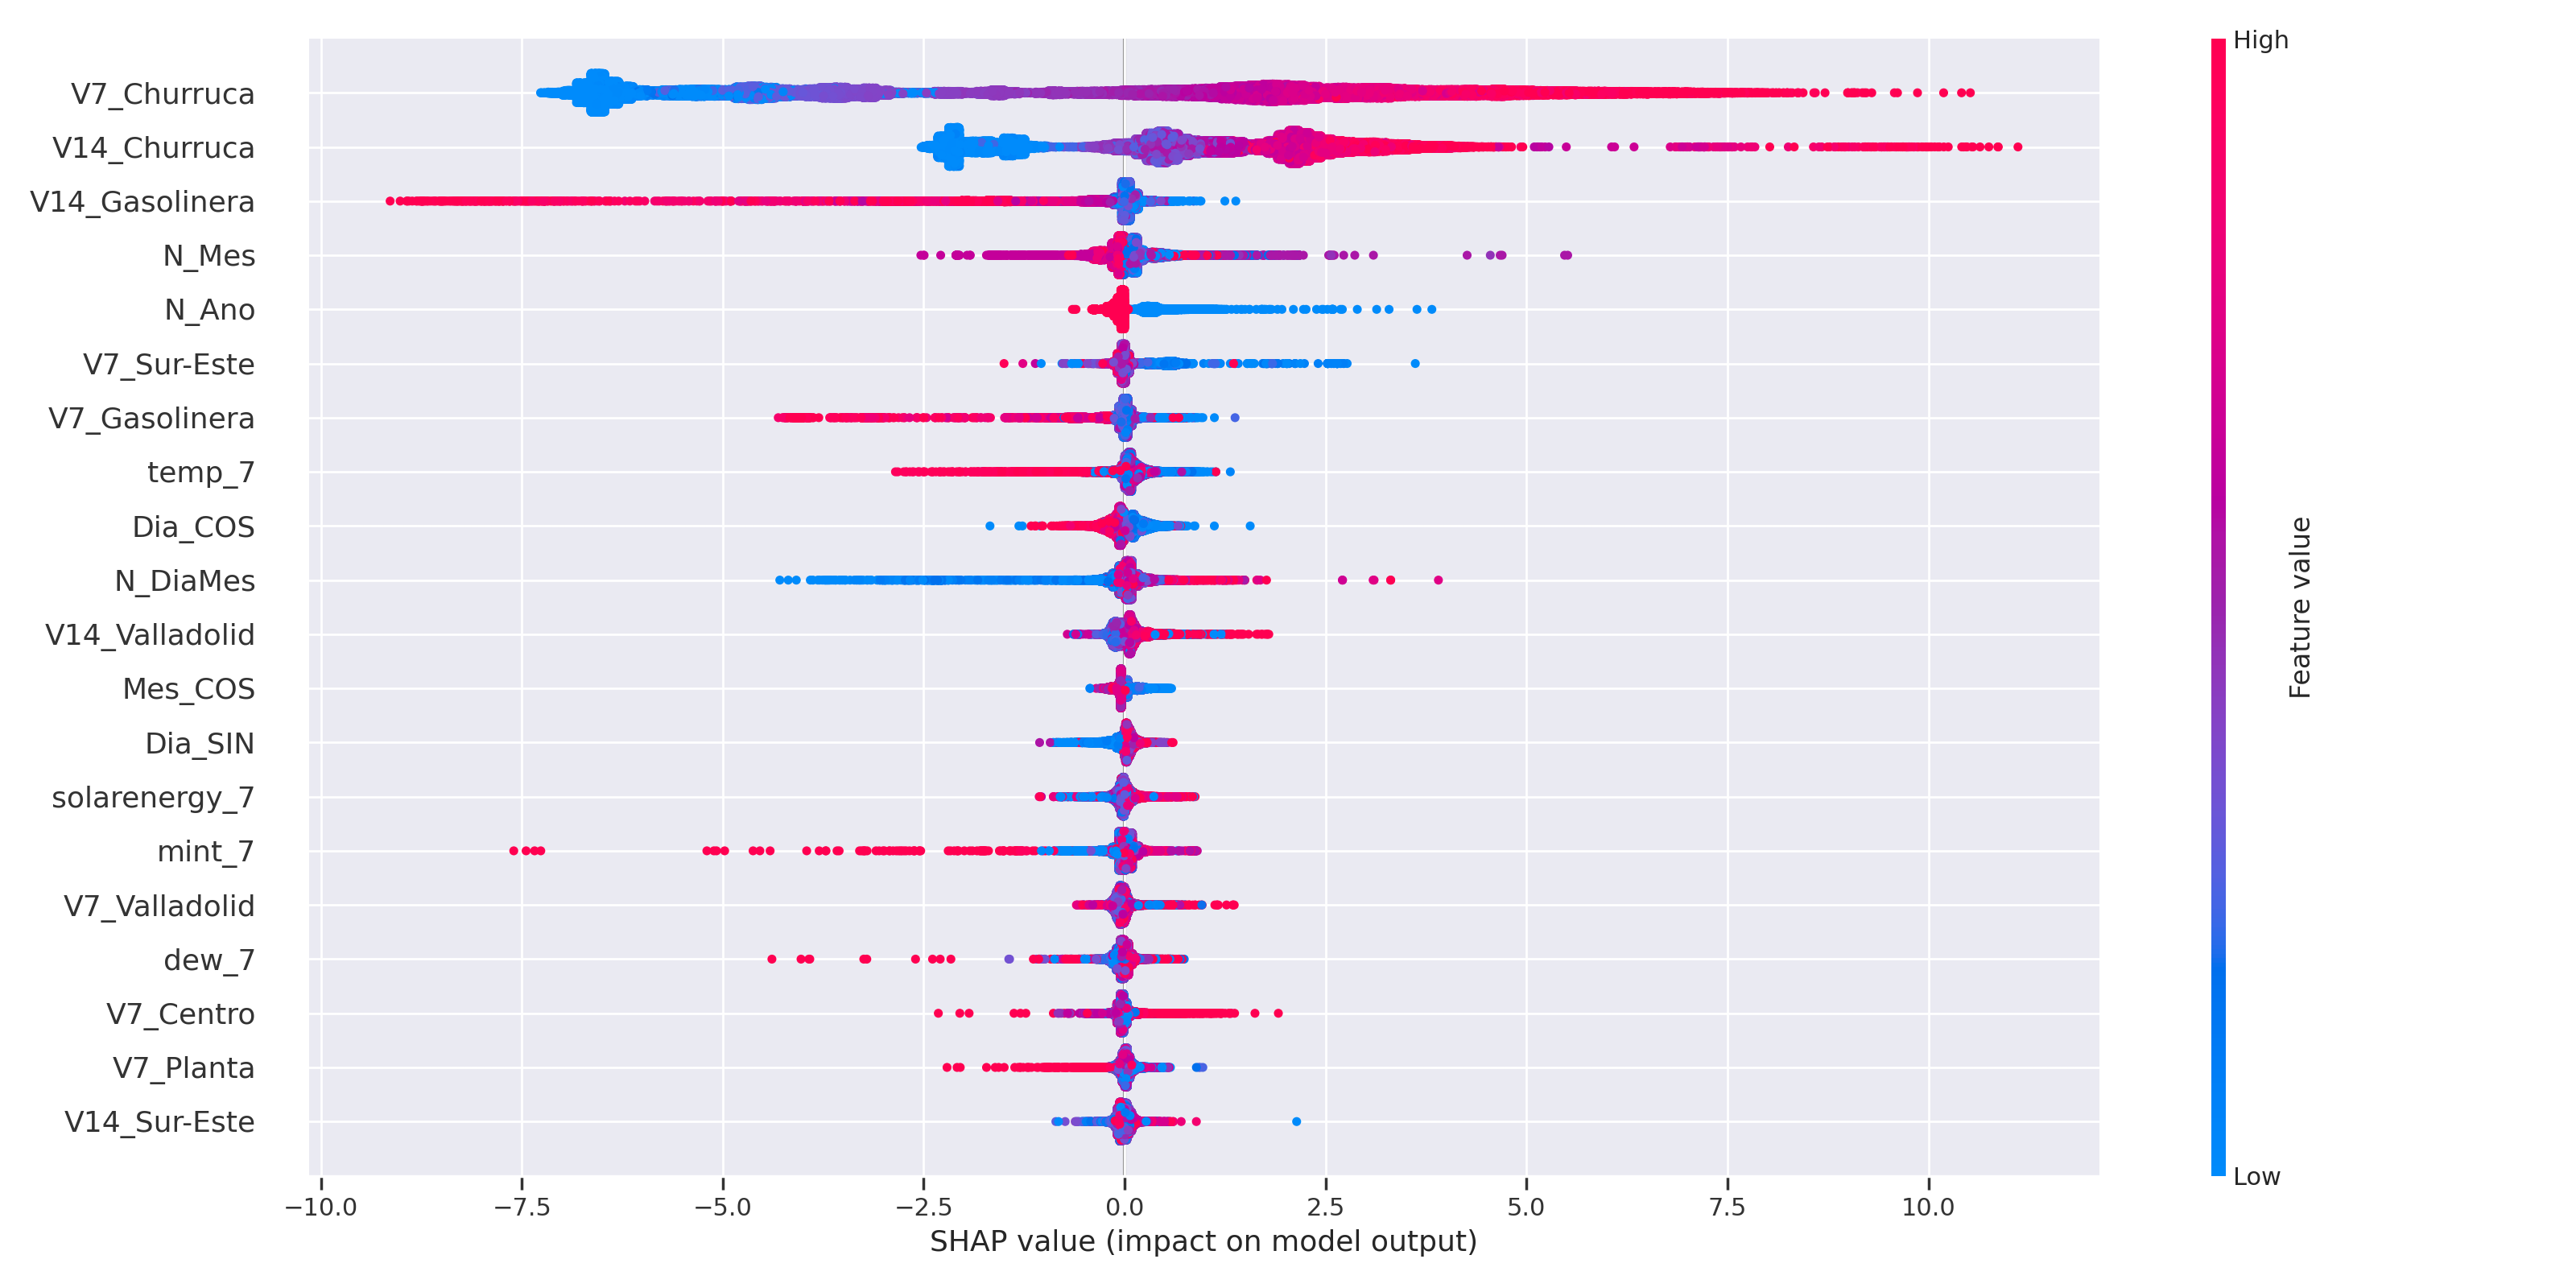

In [ ]:
shap.summary_plot(shap_values[2], X.values, feature_names = X.columns, plot_size=[16,8])

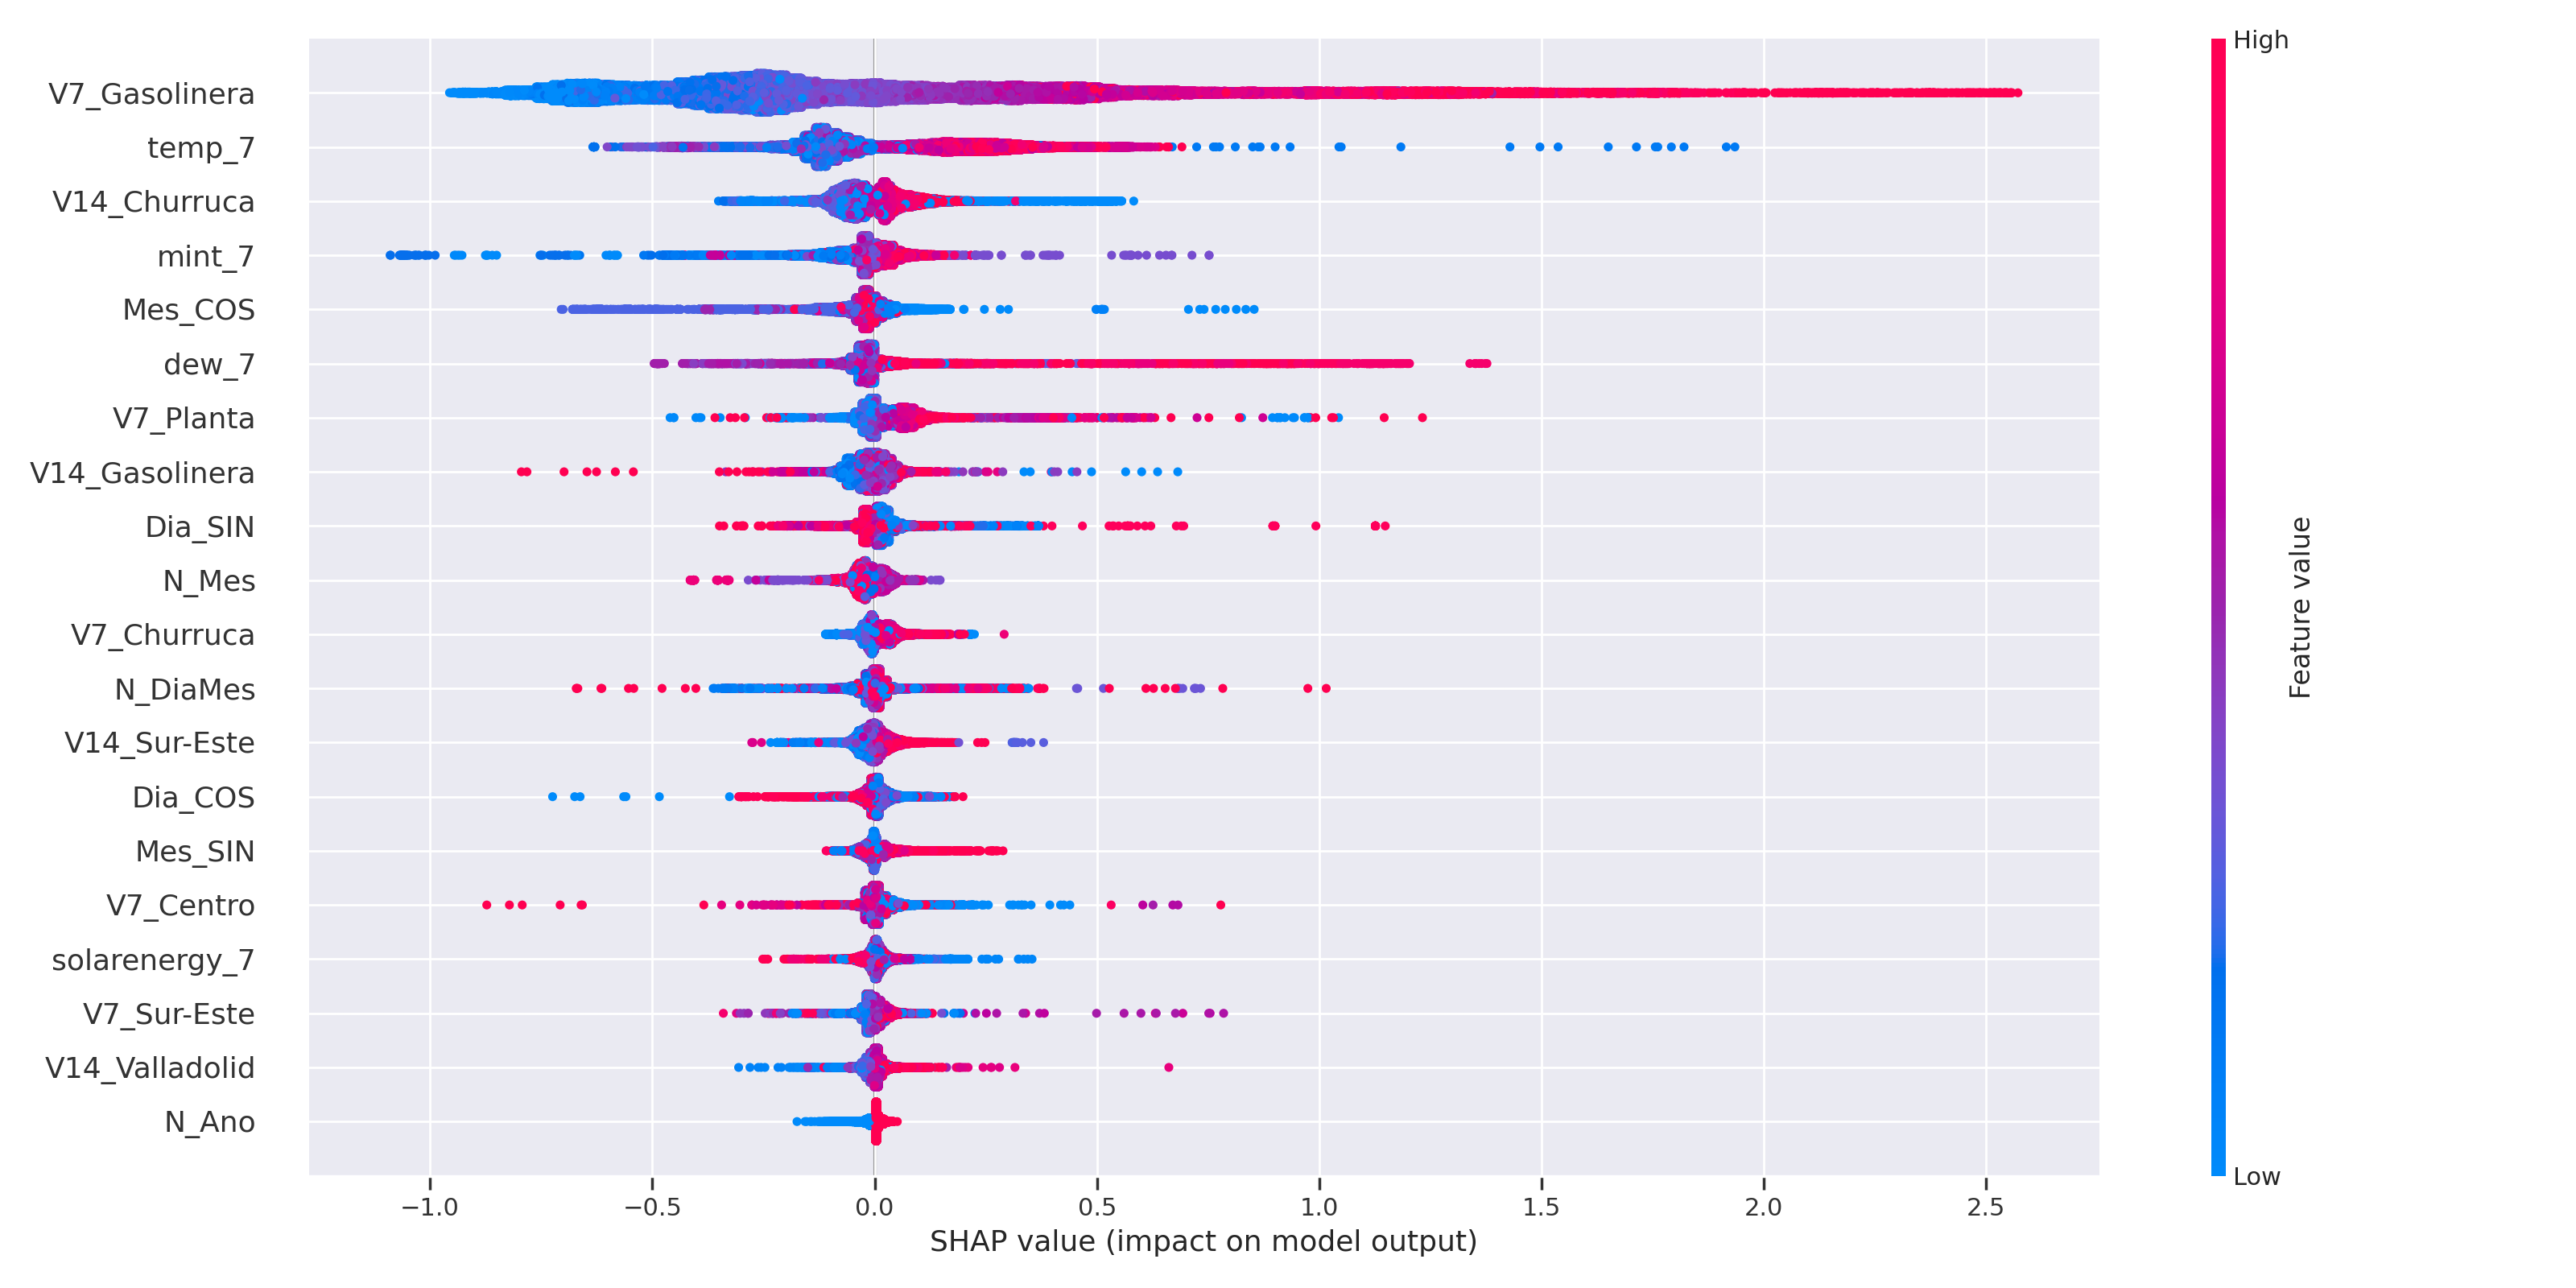

In [ ]:
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns, plot_size=[16,8])